In [1]:
%load_ext autoreload
%autoreload 2

import pymc as pm
import bambi as bmb
import itertools
#import pymc.sampling_jax
import seaborn as sns
import itertools as itools
sns.set_theme(context='paper', style='ticks')
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import numpy as np
import arviz as az
from matplotlib import pyplot as plt

from matplotlib import ticker as mticker
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import sklearn.metrics as skm
import matplotlib.patches as mpatch

import sys
sys.path.append('..')
from pfas_prep import PFAS as PFAS_prep
from PyPKMC import PyPKMC
import register_pfas_data as rpd

/data/tzurlind/Desktop/PKWG/manuscript_code/animal_pfas_manuscript/auxiliary_notebooks/../PyPKMC.py:36: UserWarning: jax libraries not installed. PyPKMC.sample(sampler='jax') cannot be used.
    Install using conda install -c conda-forge jax or mamba install jax
  warnings.warn("""jax libraries not installed. PyPKMC.sample(sampler='jax') cannot be used.


This notebook generates the figures for the results section of "Estimation of species- and sex-specific PFAS pharmacokinetics in mice, rats, and non-human primates using a Bayesian hierarchical methodology"

The list of figures:
1. Figure 3: Species- and PFAS-specific summary figure.
   * Uses the summary results to visualize the clearance, volume of distribution, and half-life
3. Figure 4: Allometric scaling results for clearance and volume of distribution
   * Uses [Bambi](https://bambinos.github.io/bambi/) to fit the allometric scaling power law model ($BW^{m}$) to investigate how allometric scaling assumptions apply to these PFAS.
5. Figure 5: HDI+ROPE decision making for comparing clearances
   * Compares rat clearances for male vs. female and IV vs. gavage routes of exposure

# Utility functions and definitions to be used throughout the results

## Preprocessing of Bayesian fitting results

This is done using two auxiliary functions.

`calc_PK` calculates the posterior estimates for each pharmacokinetic parameter while `map_BW` maps the body weight used for allometric scaling.

In [2]:
def calc_PK(row, indiv_level=False):
    global idata
    if row.model == '1-compartment':
        abbrev = '1cmpt'
    elif row.model == '2-compartment':
        abbrev = '2cmpt'
    else:
        row['CLC'] = np.nan
        row['Vd'] = np.nan
        row['CLC_mean'], row['CLC_lower'], row['CLC_upper'] = np.nan, np.nan, np.nan
        row['halft_mean'], row['halft_lower'], row['halft_upper'] = np.nan, np.nan, np.nan
        row['Vd_mean'], row['Vd_lower'], row['Vd_upper'] = np.nan, np.nan, np.nan
        return row
    #print(row.PFAS, row.sex, row.species, abbrev)
    trace = '../traces/%s_%s_%s_%s.nc'%(row.PFAS, row.sex, row.species, abbrev)
    idata = az.from_netcdf(trace)
    # Extract 1000 samples from the posterior for fitting
    row['CLC'] = az.extract(idata, num_samples=500, var_names='CLC [pop]').values
    row['Vd'] = az.extract(idata, num_samples=500, var_names='Vdss [pop]').values

    if indiv_level and 'dataset' in idata.posterior:
        all_doses = [float(x.split('-')[1].split(' ')[0]) for x in idata.posterior.dataset.values]
        all_routes = [x.split('-')[2] for x in idata.posterior.dataset.values]
        gavage_ind = [i for i, value in enumerate(all_routes) if value == 'gavage']
        min_dose_index = min(gavage_ind, key=lambda i: all_doses[i])
        print(idata.posterior.dataset.values)
        min_dataset = idata.posterior.dataset.values[min_dose_index]
        print(min_dataset)
        

        summary_CLC = az.summary(idata, var_names='CLC [indiv]', hdi_prob=0.95, kind="stats",round_to=20, coords={'dataset': min_dataset})
        summary_halft = az.summary(idata, var_names='halft [indiv]', hdi_prob=0.95, kind="stats",round_to=20, coords={'dataset': min_dataset})
        summary_Vd = az.summary(idata, var_names='Vdss [indiv]', hdi_prob=0.95, kind="stats",round_to=20, coords={'dataset': min_dataset})
        if 'fa' in idata.posterior:
            summary_fa = az.summary(idata, var_names='fa', hdi_prob=0.95, kind="stats",round_to=20, coords={'dataset': min_dataset})
            row['fa_mean'] = summary_fa.iloc[0,0]
            row['fa_lower'] = summary_fa.iloc[0,2]
            row['fa_upper'] = summary_fa.iloc[0,3]
    else:
        summary_CLC = az.summary(idata, var_names='CLC [pop]', hdi_prob=0.95, kind="stats",round_to=20)
        summary_halft = az.summary(idata, var_names='halft [pop]', hdi_prob=0.95, kind="stats",round_to=20)
        summary_Vd = az.summary(idata, var_names='Vdss [pop]', hdi_prob=0.95, kind="stats",round_to=20)
        if 'mu_fa' in idata.posterior:
            summary_fa = az.summary(idata, var_names='mu_fa', hdi_prob=0.95, kind="stats",round_to=20)
            row['fa_mean'] = summary_fa.iloc[0,0]
            row['fa_lower'] = summary_fa.iloc[0,2]
            row['fa_upper'] = summary_fa.iloc[0,3]
    row['CLC_mean'] = summary_CLC.iloc[0,0]
    row['CLC_lower'] = summary_CLC.iloc[0,2]
    row['CLC_upper'] = summary_CLC.iloc[0,3]
    
    row['halft_mean'] = summary_halft.iloc[0,0]
    row['halft_lower'] = summary_halft.iloc[0,2]
    row['halft_upper'] = summary_halft.iloc[0,3]
    
    row['Vd_mean'] = summary_Vd.iloc[0,0]
    row['Vd_lower'] = summary_Vd.iloc[0,2]
    row['Vd_upper'] = summary_Vd.iloc[0,3]
    row['trace_path'] = trace
    return row

def map_BW(row):
    """
    Table 4-2
    U.S. EPA. (1988b). Reference Physiological Parameters in
    Pharmacokinetic Modeling. U.S. Environmental Protection
    Agency, Washington, DC. EPA Report No. EPA/600/6-88/004.
    """
    BW_dict = {
        'mouse': { # Table 4-2
            'Male': 0.025,
            'Female': 0.025
        },
        'rat': { # Table 4-2
            'Male': 0.25,
            'Female': 0.25,
        },
        'primate': { # Chengelis
            'Male': 2.6,
            'Female': 2.6
        },
        'human': { # Table 4-2
            'Male': 80,
            'Female': 80
        }
    }
    row['BW'] = BW_dict[row.species][row.sex]
    return row    

## Define plotting keyword arguments for all figures

In [3]:
pfas_order = ['PFBA', 'PFBS', 'PFHxA', 'PFHxS', 'PFOA', 'PFOS', 'PFNA', 'PFDA']
species_order = ['mouse', 'rat', 'primate']
#species_order = ['rat', 'mouse', 'primate']
sex_order = ['Male', 'Female']
species_color = ['#1b9e77', '#d95f02', '#7570b3']

species_idx = dict(zip(species_order, species_color))

sex_marker = {'Male': 'o', 'Female': "^"}

## Create df with PK posteriors for each PFAS/species/sex

Generate the summary dataframe for the animal results from the hierarchical Bayesian model and the resulting model selection (`model_selecton.csv`)

In [4]:
df = pd.read_csv('../auxiliary/model_selecton.csv').dropna() # Load models and drop PFAS/species/sex that do not have data
df = df.apply(calc_PK, axis=1)
df = df.apply(map_BW, axis=1)
df.head()

,CLC,CLC_lower,CLC_mean,CLC_upper,PFAS,Vd,Vd_lower,Vd_mean,Vd_upper,fa_lower,fa_mean,fa_upper,halft_lower,halft_mean,halft_upper,model,sex,species,trace_path,BW
0,"[0.868364067018976, 1.3630541589308685, 0.5443...",0.102532,0.528658,0.981022,PFBA,"[0.19489358919389116, 0.16442210628325496, 0.2...",0.082941,0.216648,0.346501,0.556356,0.815359,0.999942,0.051952,0.347806,0.743953,2-compartment,Male,rat,../traces/PFBA_Male_rat_2cmpt.nc,0.250
1,"[1.3919098496897364, 1.6083247249542705, 1.976...",0.426959,1.888786,3.363823,PFBA,"[0.23190362137288636, 0.2985591755286782, 0.14...",0.068468,0.221396,0.390306,0.561287,0.814166,0.999474,0.013481,0.097923,0.215880,2-compartment,Female,rat,../traces/PFBA_Female_rat_2cmpt.nc,0.250
2,"[0.25540441234829375, 0.23320589808614736, 0.3...",0.137809,0.298209,0.466804,PFBA,"[0.28036097222355194, 0.26982866825744983, 0.1...",0.114517,0.288048,0.472245,NaN,NaN,NaN,0.194683,0.723916,1.336265,2-compartment,Male,mouse,../traces/PFBA_Male_mouse_2cmpt.nc,0.025
3,"[0.7891679297767314, 0.9605614783958204, 0.827...",0.378586,0.866640,1.385283,PFBA,"[0.23345745033953436, 0.4919877706528401, 0.21...",0.102061,0.214073,0.331661,NaN,NaN,NaN,0.063839,0.186139,0.342735,2-compartment,Female,mouse,../traces/PFBA_Female_mouse_2cmpt.nc,0.025
4,"[2.0185041202917833, 1.5663732687429353, 1.994...",1.545945,2.061029,2.576409,PFBA,"[0.39497891953808184, 0.6279773772802021, 0.43...",0.335476,0.592225,0.869248,NaN,NaN,NaN,0.148063,0.197074,0.247579,2-compartment,Male,primate,../traces/PFBA_Male_primate_2cmpt.nc,2.600


# Figure 3: Summary PK across PFAS/species/sex

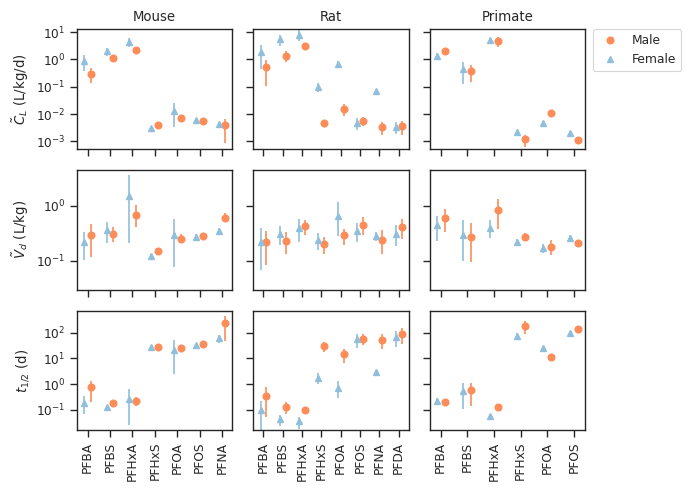

In [11]:
# All PK params on same plot
fig, ax = plt.subplots(3,3, figsize=(7, 5), sharex='col', sharey='row')

label_dict = {
    'CLC': r'$\~C_L$ (L/kg/d)',
    'Vd': r'$\~V_d$ (L/kg)',
    'halft': r'$t_{1/2}$ (d)'
}

color_dict = {
    'Male': '#fc8d59',
    'Female': '#91bfdb'
    
}

markersize=10
linewidth=4

for i, species in enumerate(['mouse', 'rat', 'primate']):
    for j, pk_param in enumerate(['CLC', 'Vd', 'halft']):
        ax[j,0].set_ylabel(label_dict[pk_param])#, fontsize=20)
        
        species_male = df[(df.species==species) & (df.sex=='Male')]#.dropna()
        species_female = df[(df.species==species) & (df.sex=='Female')]#.dropna()

        # Jitter male and female points
        x_male = np.arange(len(species_male.PFAS))+0.15
        x_female = np.arange(len(species_female.PFAS))-0.15

        ax[j,i].plot(x_male, species_male[pk_param+'_mean'], sex_marker['Male'], color=color_dict['Male'], label='Male')#, markersize=markersize)
        ax[j,i].vlines(x_male, species_male[pk_param+'_lower'], species_male[pk_param+'_upper'], color_dict['Male'])#, linewidth=linewidth)
        ax[j,i].plot(x_female, species_female[pk_param+'_mean'], sex_marker['Female'], color=color_dict['Female'], label='Female')#, markersize=markersize, markeredgewidth=2)
        ax[j,i].vlines(x_female, species_female[pk_param+'_lower'], species_female[pk_param+'_upper'], color_dict['Female'])#, linewidth=linewidth)

        if pk_param == 'CLC':
            ax[j,i].set_title(species.capitalize())#, fontsize=24)
        ax[j,i].set_xticks(np.arange(len(species_male.PFAS)), labels=species_male.PFAS)
        ax[j,i].set_yscale('log')
        ax[j,i].yaxis.set_major_locator(mticker.LogLocator(numticks=999))
        #ax[j,i].yaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))

        # turn minor ticks off
        ax[j,i].yaxis.set_minor_locator(mticker.NullLocator())
for i, species in enumerate(['Mouse', 'Rat', 'Primate']):
    for label in ax[-1,i].get_xticklabels():
        label.set_rotation(90)
        label.set_ha('center')
        #label.set_fontsize(18)

#ax[1,0].set_ylim(bottom=0.005)
ax[1,0].set_ylim(bottom=0.03)
ax[0,2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)#, fontsize=16)
#ax[1].legend(bbox_to_anchor=(0.5, -0.05), loc='lower center', borderaxespad=0, ncols=2)
fig.tight_layout()
#fig.savefig('./figures/Figure3.svg')
#fig.savefig('./figures/Figure3.pdf') ## FIGURE XX

## Supplemental figure

Overlay posterior distributions for clearance across species

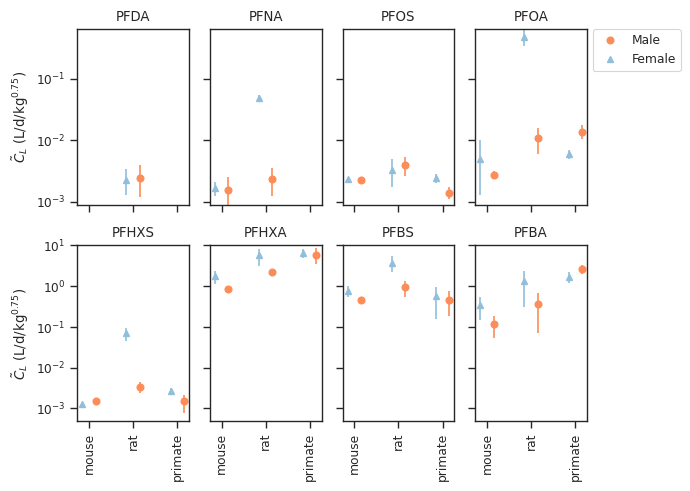

In [56]:
# All PK params on same plot
fig, axs = plt.subplots(2,4, figsize=(7, 5), sharex=True, sharey='row')
ax = axs.flatten()
label_dict = {
    'CLC': r'$\~C_L$ (L/d/kg$^{0.75}$)',
    'Vd': r'$\~V_d$ (L/kg)',
    'halft': r'$t_{1/2}$ (d)'
}

color_dict = {
    'Male': '#fc8d59',
    'Female': '#91bfdb'
    
}
mapper = {'mouse': 0, 'rat': 1, 'primate': 2}

species_order = ['mouse', 'rat', 'primate']
markersize=10
linewidth=4
pk_param = 'CLC'
my_pfas_order = pfas_order[::-1]

for i, pfas in enumerate(my_pfas_order):
    #ax[j,0].set_ylabel(label_dict[pk_param])#, fontsize=20)
    
    pfas_male = df[(df.PFAS==pfas) & (df.sex=='Male')].copy()#.dropna()
    pfas_male['col1'] = pd.Categorical(pfas_male['species'], categories=species_order, ordered=True)
    pfas_male = pfas_male.sort_values(by='col1')
    pfas_male['pos'] = pfas_male['species'].map(mapper)
    
    pfas_female = df[(df.PFAS==pfas) & (df.sex=='Female')].copy()#.dropna()
    pfas_female['col1'] = pd.Categorical(pfas_female['species'], categories=species_order, ordered=True)
    pfas_female = pfas_female.sort_values(by='col1')
    pfas_female['pos'] = pfas_female['species'].map(mapper)

    # Jitter male and female points
    #x_male = np.arange(len(pfas_male.species))+0.15
    #x_female = np.arange(len(pfas_female.species))-0.15

    ax[i].plot(pfas_male['pos']+0.15, pfas_male[pk_param+'_mean']*(pfas_male['BW']/pfas_male['BW']**0.75), sex_marker['Male'], color=color_dict['Male'], label='Male')#, markersize=markersize)
    ax[i].vlines(pfas_male['pos']+0.15, pfas_male[pk_param+'_lower']*(pfas_male['BW']/pfas_male['BW']**0.75), pfas_male[pk_param+'_upper']*(pfas_male['BW']/pfas_male['BW']**0.75), color_dict['Male'])#, linewidth=linewidth)
    ax[i].plot(pfas_female['pos']-0.15, pfas_female[pk_param+'_mean']*(pfas_female['BW']/pfas_female['BW']**0.75), sex_marker['Female'], color=color_dict['Female'], label='Female')#, markersize=markersize, markeredgewidth=2)
    ax[i].vlines(pfas_female['pos']-0.15, pfas_female[pk_param+'_lower']*(pfas_female['BW']/pfas_female['BW']**0.75), pfas_female[pk_param+'_upper']*(pfas_female['BW']/pfas_female['BW']**0.75), color_dict['Female'])#, linewidth=linewidth)

    ax[i].set_xticks(np.arange(len(pfas_male.species)), labels=pfas_male.species)
    ax[i].set_yscale('log')
    ax[i].yaxis.set_major_locator(mticker.LogLocator(numticks=999))
    #ax[j,i].yaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))

    # turn minor ticks off
    ax[i].yaxis.set_minor_locator(mticker.NullLocator())
    ax[i].set_title(pfas.upper())
for i in range(4):
    for label in axs[-1,i].get_xticklabels():
        label.set_rotation(90)
        label.set_ha('center')
        #label.set_fontsize(18)

axs[0,0].set_ylabel(label_dict['CLC'])#, fontsize=20)
axs[1,0].set_ylabel(label_dict['CLC'])
#ax[1,0].set_ylim(bottom=0.005)
#axs[1,0].set_ylim(bottom=0.03)
axs[0,3].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)#, fontsize=16)
#ax[1].legend(bbox_to_anchor=(0.5, -0.05), loc='lower center', borderaxespad=0, ncols=2)
fig.tight_layout()
fig.savefig('./figures/Suppl_CLC.svg')
fig.savefig('./figures/Suppl_CLC.pdf') ## FIGURE XX

# Figure 4: Allometric scaling of clearance and volume of distribution

The allometric scaling equation to fit is:

$PK = b*BW^m$.

In this analysis we evaluation two PK parameters (PK): Volume of distribution (V) and clearance (CL). We then use a log-transformation of the allometric scaling equation to allow for linear regression fitting in Bambi.

$log(PK) = log(b) + m*log(BW)$

However, we are not fitting $m$ and instead assuming $m = 1$ for `Vd` and $m = 0.75$ for `CL`. Therefore, we define

$lnPK_{fit} = log(PK) - m*log(BW)$

$lnPK_{fit} = log(b)$

and fit $log(b)$ for each PFAS/sex combination in the dataset.

In [6]:
# Helper function to expand species predictions
def expand_grid(data_dict):
    rows = itertools.product(*data_dict.values())
    return pd.DataFrame.from_records(rows, columns=data_dict.keys())

# Set the markersize and linewidth for the CL and V plots
markersize=8
linewidth=2

## Prep posterior PK data

From the original summary dataframe (`df`) include variables necessary for fitting the allometric power law equation

In [7]:
# Animal PK results
df_fit = df.copy()
df_fit.dropna(axis=0, how='any', inplace=True) # Remove PFAS that don't have measurements
df_fit = df_fit.loc[df_fit.groupby(['PFAS', 'sex'])['PFAS'].transform('size') > 1] # Only keep PFAS that have > 1 clearance
df_fit['CL'] = (df_fit['CLC_mean']*df_fit['BW']).astype(float)
df_fit['V'] = (df_fit['Vd_mean']*df_fit['BW']).astype(float)
df_fit['lnBW'] = np.log(df_fit['BW'])
df_fit['lnCL'] = np.log(df_fit['CL'])
df_fit['lnV'] = np.log(df_fit['V'])
df_fit['lnCL_fit'] = df_fit['lnCL'] - df_fit['lnBW']*0.75 # For fitting Clearance
df_fit['lnV_fit'] = df_fit['lnV'] - df_fit['lnBW']*1 # For fitting volume of distribution

pfas_idx, pfas_codes = pd.factorize(df_fit['PFAS'])
sex_idx, sex_codes = pd.factorize(df_fit['sex'])
#coords = {'PFAS': pfas_codes}
coords = {'PFAS': pfas_codes, 'sex': sex_codes}

In [8]:
color = sns.color_palette("deep", len(pfas_order))
color_idx = dict(zip(pfas_order, color))

species_order = ['mouse', 'rat', 'primate', 'human']
color_species = sns.color_palette("deep", len(species_order))
color_species_idx = dict(zip(species_order, color_species))

In [9]:
# Human PK results
# Vd units in L/kg, Clearance units in L/kg/y
df_human = pd.read_csv('../auxiliary/Chiu_human.csv')
df_human = df_human[df_human.sex == 'Male'] # Assume male and female is same for human results
df_human = df_human.apply(map_BW, axis=1)
human_BW = df_human.BW.unique()[0] # Use default human BW (80 kg)
df_human

,PFAS,sex,species,model,CLC_mean,CLC_lower,CLC_upper,halft_mean,halft_lower,halft_upper,Vd_mean,Vd_lower,Vd_upper,BW
0,PFHxS,Male,human,1-compartment,0.025,0.012,0.039,2.35,1.65,3.16,0.29,0.17,0.45,80
2,PFOA,Male,human,1-compartment,0.095,0.074,0.126,3.14,2.69,3.73,0.43,0.32,0.59,80
4,PFOS,Male,human,1-compartment,0.066,0.048,0.092,3.36,2.52,4.42,0.32,0.22,0.47,80
6,PFNA,Male,human,1-compartment,0.056,0.033,0.093,2.35,1.65,3.16,0.19,0.11,0.30,80
8,PFHxA,Male,human,1-compartment,16.100,16.000,16.200,NaN,NaN,NaN,NaN,NaN,NaN,80
9,PFBA,Male,human,1-compartment,43.800,43.700,43.900,NaN,NaN,NaN,NaN,NaN,NaN,80
10,PFBS,Male,human,1-compartment,1.314,1.313,1.315,NaN,NaN,NaN,NaN,NaN,NaN,80


## Fit the models

Using Bambi, we fit a clearance model where $lnCL_{fit} = log(CL) - 0.75*log(BW)$ and a volume of distribution model where $lnV_{fit} = log(V) - 1*log(BW)$

`C(PFAS):C(sex)` allows for a $log(b)$ to be fit for every PFAS/sex combination.

In [10]:
data = df_fit[['lnV_fit', 'lnCL_fit', 'sex', 'PFAS']].copy()
V_model = bmb.Model("lnV_fit ~ 0 + C(PFAS):C(sex)", data)
CL_model = bmb.Model("lnCL_fit ~ 0 + C(PFAS):C(sex)", data)

In [11]:
# Run the volume of distribution model
V_idata = V_model.fit(tune=4000, draws=4000, random_seed=12345)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, C(PFAS):C(sex)]


Output()

Sampling 4 chains for 4_000 tune and 4_000 draw iterations (16_000 + 16_000 draws total) took 11 seconds.


In [12]:
# Run the clearance model
CL_idata = CL_model.fit(tune=4000, draws=4000, random_seed=12345)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, C(PFAS):C(sex)]


Output()

Sampling 4 chains for 4_000 tune and 4_000 draw iterations (16_000 + 16_000 draws total) took 12 seconds.


## Volume of distribution

$V = b*BW^m$

Results for volume of distribution allometric scaling where $m=1$

Plots are generated based on the fits to available mouse, rat, and primate data. For each PFAS/sex combination, human volume of distribution (L/kg) are presented assuming a human mass of 80 kg.

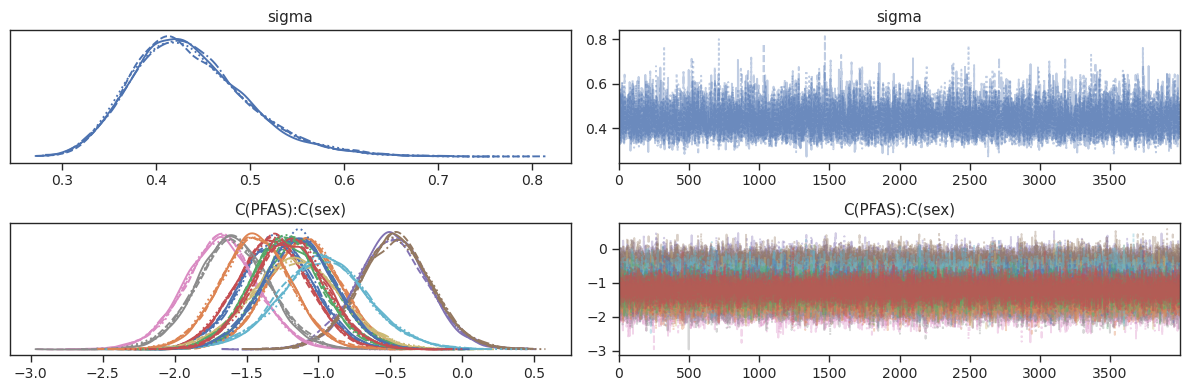

In [13]:
# Trace for each PFAS/sex combination log(b)
az.plot_trace(V_idata)
plt.tight_layout()

In [14]:
az.summary(V_idata) # summary of log(b) results

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,0.437,0.062,0.328,0.555,0.001,0.000,11939.0,11756.0,1.0
"C(PFAS):C(sex)[PFBA, Female]",-1.290,0.257,-1.777,-0.809,0.001,0.001,32387.0,12158.0,1.0
"C(PFAS):C(sex)[PFBA, Male]",-1.099,0.254,-1.596,-0.642,0.002,0.001,26601.0,11601.0,1.0
"C(PFAS):C(sex)[PFBS, Female]",-1.140,0.256,-1.617,-0.648,0.001,0.001,30183.0,11464.0,1.0
"C(PFAS):C(sex)[PFBS, Male]",-1.322,0.251,-1.784,-0.841,0.001,0.001,29984.0,12292.0,1.0
"C(PFAS):C(sex)[PFHxA, Female]",-0.485,0.252,-0.963,-0.009,0.001,0.001,31614.0,12800.0,1.0
"C(PFAS):C(sex)[PFHxA, Male]",-0.469,0.253,-0.953,0.001,0.001,0.001,35298.0,12500.0,1.0
"C(PFAS):C(sex)[PFHxS, Female]",-1.677,0.256,-2.150,-1.182,0.001,0.001,29929.0,12118.0,1.0
"C(PFAS):C(sex)[PFHxS, Male]",-1.593,0.255,-2.067,-1.106,0.001,0.001,32570.0,12550.0,1.0
"C(PFAS):C(sex)[PFNA, Female]",-1.166,0.312,-1.749,-0.572,0.002,0.001,33546.0,11595.0,1.0


PFBA, Male: 0.33 (0.2 - 0.53)
PFBA, Female: 0.28 (0.17 - 0.45)
PFBS, Male: 0.27 (0.17 - 0.43)
PFBS, Female: 0.32 (0.2 - 0.52)
PFHxA, Male: 0.63 (0.39 - 1)
PFHxA, Female: 0.62 (0.38 - 0.99)
PFHxS, Male: 0.2 (0.13 - 0.33)
PFHxS, Female: 0.19 (0.12 - 0.31)
PFOA, Male: 0.24 (0.15 - 0.38)
PFOA, Female: 0.32 (0.2 - 0.52)
PFOS, Male: 0.3 (0.19 - 0.49)
PFOS, Female: 0.29 (0.18 - 0.48)
PFNA, Male: 0.38 (0.2 - 0.68)
PFNA, Female: 0.31 (0.17 - 0.56)


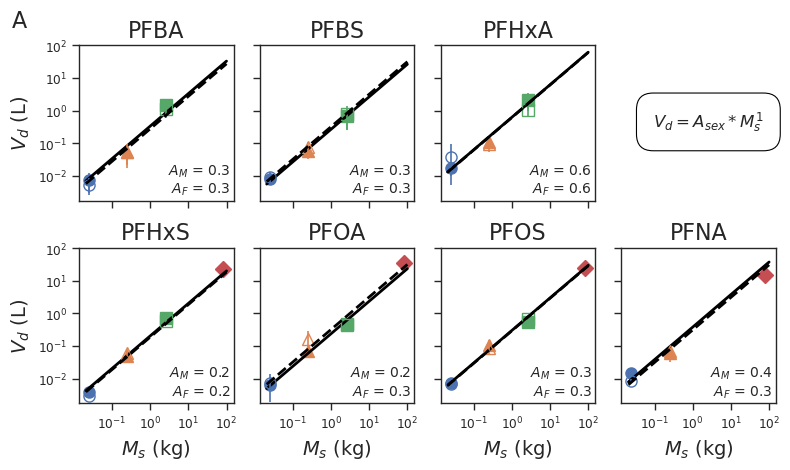

In [15]:
BW_min = min(np.log(df_fit['BW']).min(), np.log(df_human['BW']).min())
BW_max = max(np.log(df_fit['BW']).max(), np.log(df_human['BW']).max())
lnBW_pred = np.linspace(BW_min- np.abs(BW_min*0.05), BW_max + np.abs(BW_max*0.05), 100)
data_test = expand_grid({'PFAS': pfas_codes, 'sex': sex_order})

fig, axs = plt.subplots(2, 4, figsize=(8, 4+0.7), sharex=True, sharey=True)
axs[0,3].remove()
ax = axs.flatten()
plot_PFAS = ['PFHxS', 'PFOA', 'PFOS', 'PFNA']
marker_order = ['o', '^', 's', 'D']
preds = V_model.predict(V_idata, kind="response", data=data_test, inplace=False) # Predict lnV_fit for each PFAS/sex combination across the lnBW range
#lnV_fit_mean = az.extract(preds['posterior'])['lnV_fit_mean']
lnV_fit_mean = az.extract(preds['posterior'])['mu']
for i, PFAS in enumerate(pfas_codes):
    if i >= 3:
        cur_ax = ax[i+1]
    else:
        cur_ax = ax[i]

    A_txt = []
    for k, sex in enumerate(sex_codes):        
        for j, species in enumerate(['mouse', 'rat', 'primate', 'human']):
            if species != 'human':
                if species in df_fit.loc[df_fit.PFAS==PFAS, 'species'].unique():
                    BW = df_fit.loc[(df_fit.PFAS==PFAS) & (df_fit.species==species) & (df_fit.sex==sex), 'BW'].values[0]
                    Vd_mean = df_fit.loc[(df_fit.PFAS==PFAS) & (df_fit.species==species) & (df_fit.sex==sex), 'Vd_mean'].values[0]*BW
                    Vd_low = df_fit.loc[(df_fit.PFAS==PFAS) & (df_fit.species==species) & (df_fit.sex==sex), 'Vd_lower'].values[0]*BW
                    Vd_high = df_fit.loc[(df_fit.PFAS==PFAS) & (df_fit.species==species) & (df_fit.sex==sex), 'Vd_upper'].values[0]*BW
                else:
                    continue

                if sex == 'Male':
                    cur_ax.plot(BW, Vd_mean, marker_order[j], markersize=markersize, color=color_species_idx[species])
                else:
                    cur_ax.plot(BW, Vd_mean, marker_order[j], markersize=markersize, fillstyle="none", color=color_species_idx[species])
                cur_ax.vlines(BW, Vd_low, Vd_high, color=color_species_idx[species])
            
            
            else:
                BW = df_human.loc[(df_human.PFAS==PFAS) & (df_human.species==species) & (df_human.sex==sex), 'BW']
                Vd_mean = df_human.loc[(df_human.PFAS==PFAS) & (df_human.species==species) & (df_human.sex==sex), 'Vd_mean']*BW
                Vd_low = df_human.loc[(df_human.PFAS==PFAS) & (df_human.species==species) & (df_human.sex==sex), 'Vd_lower']*BW
                Vd_high = df_human.loc[(df_human.PFAS==PFAS) & (df_human.species==species) & (df_human.sex==sex), 'Vd_upper']*BW
                cur_ax.plot(BW, Vd_mean, marker_order[j], markersize=markersize, color=color_species_idx[species])
                cur_ax.vlines(BW, Vd_low, Vd_high, color=color_species_idx[species])
        idx = data_test[(data_test.PFAS == PFAS) & (data_test.sex == sex)].index[0]
        lnV = lnV_fit_mean[idx].values[:, np.newaxis] + 1*lnBW_pred # Transform back to log(PK) = lnPK_fit + m*lnBW
        if sex == 'Male':
            cur_ax.plot(np.exp(lnBW_pred), np.exp(lnV.mean(axis=0)), color='black', linewidth=linewidth)  
        if sex == 'Female':
            cur_ax.plot(np.exp(lnBW_pred), np.exp(lnV.mean(axis=0)), '--', color='black', linewidth=linewidth) 
        cur_ax.set_xscale('log')
        cur_ax.set_yscale('log')
        cur_ax.yaxis.set_major_locator(mticker.LogLocator(numticks=999))
        cur_ax.xaxis.set_major_locator(mticker.LogLocator(numticks=999))
        cur_ax.yaxis.set_minor_locator(mticker.NullLocator())
        cur_ax.xaxis.set_minor_locator(mticker.NullLocator())
        cur_ax.set_title(PFAS, fontsize=16)
        
        # Add coefficient to figure
        intercept = np.exp(lnV_fit_mean[idx].values.mean())
        A_txt.append('$A_{%s}$ = %0.1g'%(sex[0], intercept))
        lnV_human = lnV_fit_mean[idx].values + 1*np.log(human_BW)
        human_V_mean = np.exp(lnV_human.mean())
        low, high = np.exp(az.hdi(lnV_human))
        print('%s, %s: %0.2g (%0.2g - %0.2g)'%(PFAS, sex, human_V_mean/human_BW, low/human_BW, high/human_BW)) # Human predicted Vd (L/kg)
    cur_ax.text(0.98, 0.02, '\n'.join(A_txt), fontsize=10, va='bottom', ha='right', transform=cur_ax.transAxes)
                
_ = fig.text(0.96, 0.75, '$V_{d} = A_{sex}*M_s^{1}$', fontsize=12, va='center', ha='right', bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=1'))

axs[0,0].set_ylabel('$V_{d}$ (L)', fontsize=14)
axs[1,0].set_ylabel('$V_{d}$ (L)', fontsize=14)
axs[1,0].set_xlabel('$M_s$ (kg)', fontsize=14)
axs[1,1].set_xlabel('$M_s$ (kg)', fontsize=14)
axs[1,2].set_xlabel('$M_s$ (kg)', fontsize=14)
axs[1,3].set_xlabel('$M_s$ (kg)', fontsize=14)
    
#fig.legend(loc='upper right', bbox_to_anchor=(0.95, 0.9), fontsize=20, markerscale=2)
fig.text(0.02, 0.99, 'A', fontsize=16, va='top', ha='left')
fig.tight_layout()
fig.savefig('./figures/Figure4A.svg')
fig.savefig('./figures/Figure4A.pdf') ## FIGURE XX

## Clearance

$V = b*BW^m$

Results for clearance allometric scaling where $m=0.75$

Plots are generated based on the fits to available mouse, rat, and primate data. For each PFAS/sex combination, human clearance (L/y/kg) are presented assuming a human mass of 80 kg.

PFBA, Male: 59.5 (13.2 - 247)
PFBA, Female: 112 (25.4 - 489)
PFBS, Male: 71.4 (15 - 287)
PFBS, Female: 144 (33.9 - 608)
PFHxA, Male: 275 (66.1 - 1.15e+03)
PFHxA, Female: 490 (116 - 2.08e+03)
PFHxS, Male: 0.24 (0.0531 - 0.978)
PFHxS, Female: 0.753 (0.162 - 2.99)
PFOA, Male: 0.911 (0.208 - 4.07)
PFOA, Female: 2.94 (0.665 - 12.2)
PFOS, Male: 0.279 (0.0631 - 1.25)
PFOS, Female: 0.322 (0.0723 - 1.33)
PFNA, Male: 0.233 (0.039 - 1.49)
PFNA, Female: 1.1 (0.19 - 7.19)


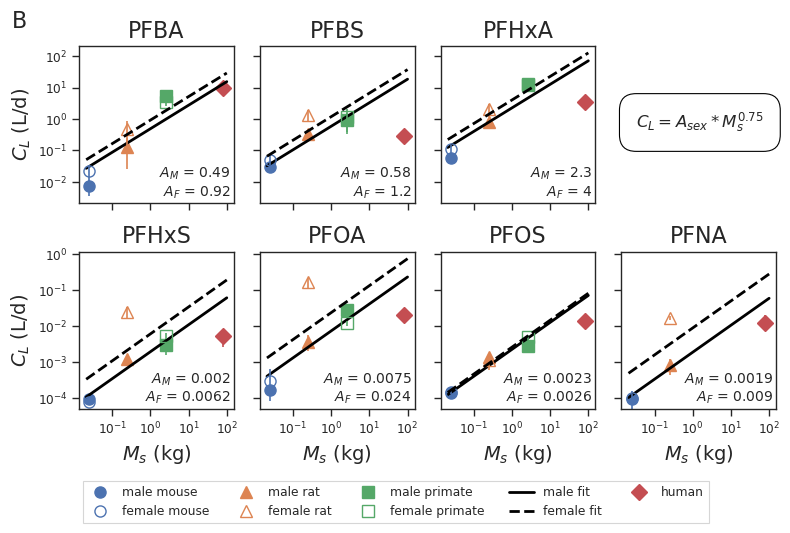

In [16]:
BW_min = min(np.log(df_fit['BW']).min(), np.log(df_human['BW']).min())
BW_max = max(np.log(df_fit['BW']).max(), np.log(df_human['BW']).max())
lnBW_pred = np.linspace(BW_min- np.abs(BW_min*0.05), BW_max + np.abs(BW_max*0.05), 100)
data_test = expand_grid({'PFAS': pfas_codes, 'sex': sex_order})

fig, axs = plt.subplots(2, 4, figsize=(8, 4+0.7), sharex=True, sharey='row')
axs[0,3].remove()
ax = axs.flatten()
plot_PFAS = ['PFHxS', 'PFOA', 'PFOS', 'PFNA']
marker_order = ['o', '^', 's', 'D']
preds = CL_model.predict(CL_idata, kind="mean", data=data_test, inplace=False)
#lnCL_fit_mean = az.extract(preds['posterior'])['lnCL_fit_mean']
lnCL_fit_mean = az.extract(preds['posterior'])['mu']
for i, PFAS in enumerate(pfas_codes):
    if i >= 3:
        cur_ax = ax[i+1]
    else:
        cur_ax = ax[i]

    A_txt = []
    for k, sex in enumerate(sex_codes):        
        for j, species in enumerate(['mouse', 'rat', 'primate', 'human']):
            if species != 'human':
                if species in df_fit.loc[df_fit.PFAS==PFAS, 'species'].unique():
                    BW = df_fit.loc[(df_fit.PFAS==PFAS) & (df_fit.species==species) & (df_fit.sex==sex), 'BW'].values[0]
                    CL_mean = df_fit.loc[(df_fit.PFAS==PFAS) & (df_fit.species==species) & (df_fit.sex==sex), 'CLC_mean'].values[0]*BW
                    CL_low = df_fit.loc[(df_fit.PFAS==PFAS) & (df_fit.species==species) & (df_fit.sex==sex), 'CLC_lower'].values[0]*BW
                    CL_high = df_fit.loc[(df_fit.PFAS==PFAS) & (df_fit.species==species) & (df_fit.sex==sex), 'CLC_upper'].values[0]*BW
                else:
                    continue

                if sex == 'Male':
                    cur_ax.plot(BW, CL_mean, marker_order[j], markersize=markersize, color=color_species_idx[species])
                else:
                    cur_ax.plot(BW, CL_mean, marker_order[j], markersize=markersize, fillstyle="none", color=color_species_idx[species])
                cur_ax.vlines(BW, CL_low, CL_high, color=color_species_idx[species])
            
            
            else:
                BW = df_human.loc[(df_human.PFAS==PFAS) & (df_human.species==species) & (df_human.sex==sex), 'BW']
                CL_mean = df_human.loc[(df_human.PFAS==PFAS) & (df_human.species==species) & (df_human.sex==sex), 'CLC_mean']*BW/365.
                CL_low = df_human.loc[(df_human.PFAS==PFAS) & (df_human.species==species) & (df_human.sex==sex), 'CLC_lower']*BW/365.
                CL_high = df_human.loc[(df_human.PFAS==PFAS) & (df_human.species==species) & (df_human.sex==sex), 'CLC_upper']*BW/365.
                cur_ax.plot(BW, CL_mean, marker_order[j], markersize=markersize, color=color_species_idx[species])
                cur_ax.vlines(BW, CL_low, CL_high, color=color_species_idx[species])
                
        idx = data_test[(data_test.PFAS == PFAS) & (data_test.sex == sex)].index[0]
        lnCL = lnCL_fit_mean[idx].values[:, np.newaxis] + 0.75*lnBW_pred # Transform back to log(PK) = lnPK_fit + m*lnBW
        if sex == 'Male':
            cur_ax.plot(np.exp(lnBW_pred), np.exp(lnCL.mean(axis=0)), color='black', linewidth=linewidth)
            #cur_ax.fill_between(np.exp(lnBW_pred), np.exp(az.hdi(lnCL)[:,0]), np.exp(az.hdi(lnCL)[:,1]), color='C0')
        if sex == 'Female':
            cur_ax.plot(np.exp(lnBW_pred), np.exp(lnCL.mean(axis=0)), '--', color='black', linewidth=linewidth)
            #cur_ax.fill_between(np.exp(lnBW_pred), np.exp(az.hdi(lnCL)[:,0]), np.exp(az.hdi(lnCL)[:,1]), color='C1')
        
        cur_ax.set_xscale('log')
        cur_ax.set_yscale('log')
        cur_ax.yaxis.set_major_locator(mticker.LogLocator(numticks=999))
        cur_ax.xaxis.set_major_locator(mticker.LogLocator(numticks=999))
        cur_ax.yaxis.set_minor_locator(mticker.NullLocator())
        cur_ax.xaxis.set_minor_locator(mticker.NullLocator())
        cur_ax.set_title(PFAS, fontsize=16)
        
        # Add coefficient to figure
        intercept = np.exp(lnCL_fit_mean[idx].values.mean())
        A_txt.append('$A_{%s}$ = %0.2g'%(sex[0], intercept))
        lnCL_human = lnCL_fit_mean[idx].values + 0.75*np.log(human_BW)
        human_CL_mean = np.exp(lnCL_human.mean())
        low, high = np.exp(az.hdi(lnCL_human))
        print('%s, %s: %0.3g (%0.3g - %0.3g)'%(PFAS, sex, human_CL_mean*365./human_BW, low*365./human_BW, high*365./human_BW)) # Human predicted CLC (L/y/kg)
        
    cur_ax.text(0.98, 0.02, '\n'.join(A_txt), fontsize=10, va='bottom', ha='right', transform=cur_ax.transAxes)
                
_ = fig.text(0.96, 0.75, '$C_{L} = A_{sex}*M_s^{0.75}$', fontsize=12, va='center', ha='right', bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=1'))

axs[0,0].set_ylabel('$C_{L}$ (L/d)', fontsize=14)
axs[1,0].set_ylabel('$C_{L}$ (L/d)', fontsize=14)
axs[1,0].set_xlabel('$M_s$ (kg)', fontsize=14)
axs[1,1].set_xlabel('$M_s$ (kg)', fontsize=14)
axs[1,2].set_xlabel('$M_s$ (kg)', fontsize=14)
axs[1,3].set_xlabel('$M_s$ (kg)', fontsize=14)
    
#fig.legend(loc='upper right', bbox_to_anchor=(0.95, 0.9), fontsize=20, markerscale=2)
fig.text(0.02, 0.99, 'B', fontsize=16, va='top', ha='left')
fig.tight_layout()

fig.subplots_adjust(bottom=0.14)#, wspace=0.33)
marker_order = ['o', '^', 's', 'D']
color_species_idx[species]
legend_elements = [Line2D([0], [0], marker=marker_order[0], color='white', markeredgecolor=color_species_idx['mouse'], markerfacecolor=color_species_idx['mouse'], label='male mouse', markersize=markersize),
                   Line2D([0], [0], marker=marker_order[0], color='white', markeredgecolor=color_species_idx['mouse'], fillstyle="none", label='female mouse', markersize=markersize),
                   
                   Line2D([0], [0], marker=marker_order[1], color='white', markeredgecolor=color_species_idx['rat'], markerfacecolor=color_species_idx['rat'], label='male rat', markersize=markersize),
                   Line2D([0], [0], marker=marker_order[1], color='white', markeredgecolor=color_species_idx['rat'], fillstyle="none", label='female rat', markersize=markersize),
                   
                   Line2D([0], [0], marker=marker_order[2], color='white', markeredgecolor=color_species_idx['primate'], markerfacecolor=color_species_idx['primate'], label='male primate', markersize=markersize),
                   Line2D([0], [0], marker=marker_order[2], color='white', markeredgecolor=color_species_idx['primate'], fillstyle="none", label='female primate', markersize=markersize),
                   
                   
                   Line2D([0], [0], color='black', lw=linewidth, linestyle='-', label='male fit', markersize=markersize),
                   Line2D([0], [0], color='black', lw=linewidth, linestyle='--', label='female fit', markersize=markersize),

                   Line2D([0], [0], marker=marker_order[3], color='white', markeredgecolor=color_species_idx['human'], markerfacecolor=color_species_idx['human'], label='human', markersize=markersize),
                   
                   #Line2D([0], [0], marker='o', color='black', markeredgecolor='black', label='No decision', markersize=markersize, fillstyle="none"),
                  ]
                          
axs[0, 1].legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0), bbox_transform=fig.transFigure, fancybox=False, shadow=False, ncol=5)
fig.savefig('./figures/Figure4B.svg')
fig.savefig('./figures/Figure4B.pdf') ## FIGURE XX

# Figure 5: HDI+ROPE for comparing clearances

Differences in clearance are compared for two scenarios:
1. Male vs Female
   * Compare population-level clearances bewtween male and female animals
3. IV vs. gavage
   * Compare dataset-level clearances in rats for sex- and dose-matched IV vs. gavage clearance.

In [8]:
pfas_db = '../PFAS.db'
pfas_tmp = PFAS_prep(pfas_db, pfas_file = '../auxiliary/pfas_master.csv')#, hero_only=1289834) #

# Map HERO ID to study citation
study_mapper = {
    '2325359': 'Chang, 2008', 
    '1326734': 'Olsen, 2009',
    '5387170': 'Huang, 2019',
    '5916078': 'Dzierlenga, 2019',
    '3749289': 'Kim, 2016',
    '4239569': 'Kim, 2018',
    '6302380': 'Kemper, 2003',
    '5063958': 'Kim, 2019',
    '6579272': 'Lau, 2020',
    '2850314': 'Gannon, 2011',
    '2850396': 'Chengelis, 2009',
    '6822782': 'Daikin, 2010',
    '1289834': 'Sundstrom, 2012',
    '2919359': 'Lou, 2009',
    '1289832': 'Chang, 2012',
    '2919268': 'Tatum-Gibbs, 2011'
    
               }
markersize=7 # marker size for this section

## Male vs. Female

CURRENTLY ON PFBA
PFBA Male mouse
   PFAS   sex species          model                                                CLC                                                 Vd  CLC_mean  CLC_lower  CLC_upper  halft_mean  halft_lower  halft_upper   Vd_mean  Vd_lower  Vd_upper                          trace_path     BW
2  PFBA  Male   mouse  2-compartment  [0.2942641589226058, 0.19886721100195395, 0.34...  [0.2688641233225825, 0.22559301925517766, 0.21...  0.298209   0.137809   0.466804    0.723916     0.194683     1.336265  0.288048  0.114517  0.472245  ../traces/PFBA_Male_mouse_2cmpt.nc  0.025
Hero ID available:  [2325359]
dropping duplicated column
Hero ID used:  [2325359]
PFBA_Male_mouse_2cmpt
hierarchical model, 2-compartment
Checking metrics...
Pass all metrics = True
Assign pareto...
PFBA Female mouse
   PFAS     sex species          model                                                CLC                                                 Vd  CLC_mean  CLC_lower  CLC_upper  halft_mean 

,mean,sd,hdi_2.5%,hdi_97.5%,25%,75%,ROPE_prob,ROPE,PFAS
mouse,3.149,1.377,0.932,5.785,2.283,3.712,1.735,No Decision,PFBA
rat,4.437,3.552,0.347,10.213,2.500,5.250,2.670,No Decision,PFBA
primate,0.661,0.130,0.417,0.914,0.571,0.737,13.510,No Decision,PFBA


DONE WITH PFBA
CURRENTLY ON PFBS
PFBS Male mouse
   PFAS   sex species          model                                                CLC                                                 Vd  CLC_mean  CLC_lower  CLC_upper  halft_mean  halft_lower  halft_upper  Vd_mean  Vd_lower  Vd_upper                          trace_path     BW
8  PFBS  Male   mouse  2-compartment  [1.196850401001407, 0.9581424626888579, 1.2752...  [0.28140501261765993, 0.27947981434198027, 0.3...  1.149508    0.92788   1.394159    0.186244      0.15443     0.221081   0.3095    0.2166  0.403822  ../traces/PFBS_Male_mouse_2cmpt.nc  0.025
Hero ID available:  [1326734 2850396 5387170 6579272]
dropping duplicated column
Hero ID used:  [6579272]
PFBS_Male_mouse_2cmpt
single level model, 2-compartment
Checking metrics...
Pass all metrics = True
Assign pareto...
PFBS Female mouse
   PFAS     sex species          model                                                CLC                                                 Vd  CLC_me

,mean,sd,hdi_2.5%,hdi_97.5%,25%,75%,ROPE_prob,ROPE,PFAS
mouse,1.726,0.341,1.103,2.427,1.489,1.929,4.125,No Decision,PFBS
rat,4.238,1.325,1.858,6.812,3.328,4.949,0.005,Reject Null,PFBS
primate,1.377,0.814,0.206,2.753,0.891,1.656,29.197,No Decision,PFBS


DONE WITH PFBS
CURRENTLY ON PFHxA
PFHxA Male mouse
     PFAS   sex species          model                                                CLC                                                 Vd  CLC_mean  CLC_lower  CLC_upper  halft_mean  halft_lower  halft_upper   Vd_mean  Vd_lower  Vd_upper                           trace_path     BW
14  PFHxA  Male   mouse  2-compartment  [1.8472024914904588, 2.484651588648317, 2.1183...  [0.4602963995703461, 0.6486868943670268, 0.629...  2.206694   1.841286   2.594592    0.214918     0.140878     0.308521  0.686878  0.401116   1.03806  ../traces/PFHxA_Male_mouse_2cmpt.nc  0.025
Hero ID available:  [2850314 2850396 3859701 5916078 6822782]
dropping duplicated column
Hero ID used:  [2850314]
PFHxA_Male_mouse_2cmpt
single level model, 2-compartment
Checking metrics...
Pass all metrics = True
Assign pareto...
PFHxA Female mouse
     PFAS     sex species          model                                                CLC                                     

,mean,sd,hdi_2.5%,hdi_97.5%,25%,75%,ROPE_prob,ROPE,PFAS
mouse,2.028,0.412,1.249,2.860,1.766,2.256,1.250,Reject Null,PFHxA
rat,2.620,0.630,1.374,3.853,2.203,2.983,0.625,Reject Null,PFHxA
primate,1.134,0.311,0.596,1.747,0.920,1.297,54.190,No Decision,PFHxA


DONE WITH PFHxA
CURRENTLY ON PFHxS
PFHxS Male mouse
     PFAS   sex species          model                                                CLC                                                 Vd  CLC_mean  CLC_lower  CLC_upper  halft_mean  halft_lower  halft_upper   Vd_mean  Vd_lower  Vd_upper                           trace_path     BW
20  PFHxS  Male   mouse  1-compartment  [0.0037558823456891968, 0.003922563148564389, ...  [0.15366112642955607, 0.14655378692692875, 0.1...  0.003809   0.003488   0.004133   27.397326    25.625428    29.450666  0.150581   0.13384  0.168028  ../traces/PFHxS_Male_mouse_1cmpt.nc  0.025
Hero ID available:  [1289834 3749289 4239569 5387170]
No BW info for mouse in 1289834, using defaults
No BW info for mouse in 1289834, using defaults
No BW info for mouse in 1289834, using defaults
No BW info for mouse in 1289834, using defaults
No BW info for mouse in 1289834, using defaults
No BW info for mouse in 1289834, using defaults
No BW info for mouse in 1289834, usi

,mean,sd,hdi_2.5%,hdi_97.5%,25%,75%,ROPE_prob,ROPE,PFAS
mouse,0.824,0.013,0.80,0.847,0.816,0.831,97.735,No Decision,PFHxS
rat,20.993,5.048,11.84,30.859,17.475,23.802,0.000,Reject Null,PFHxS
primate,1.958,1.050,1.04,3.151,1.528,2.151,3.230,No Decision,PFHxS


DONE WITH PFHxS
CURRENTLY ON PFOA
PFOA Male mouse
    PFAS   sex species          model                                                CLC                                                 Vd  CLC_mean  CLC_lower  CLC_upper  halft_mean  halft_lower  halft_upper   Vd_mean  Vd_lower  Vd_upper                          trace_path     BW
26  PFOA  Male   mouse  2-compartment  [0.006334728183386047, 0.006748957077618257, 0...  [0.24740050306929567, 0.24715046741511373, 0.2...  0.006938   0.006085   0.007771   25.630496    20.119525    31.968723  0.252157  0.205973  0.303788  ../traces/PFOA_Male_mouse_2cmpt.nc  0.025
Hero ID available:  [2919359 2990271 3749227 3749289 3858670 3859701 5916078 6302380]
No BW info for mouse in 2919359, using defaults
No BW info for mouse in 2919359, using defaults
No BW info for mouse in 2919359, using defaults
No BW info for mouse in 2919359, using defaults
No BW info for mouse in 2919359, using defaults
No BW info for mouse in 2919359, using defaults
No BW info

,mean,sd,hdi_2.5%,hdi_97.5%,25%,75%,ROPE_prob,ROPE,PFAS
mouse,1.797,1.028,0.407,3.673,1.153,2.152,21.235,No Decision,PFOA
rat,46.945,13.843,22.453,74.168,37.310,54.345,0.000,Reject Null,PFOA
primate,0.437,0.069,0.309,0.574,0.389,0.478,0.005,Reject Null,PFOA


DONE WITH PFOA
CURRENTLY ON PFOS
PFOS Male mouse
    PFAS   sex species          model                                                CLC                                                 Vd  CLC_mean  CLC_lower  CLC_upper  halft_mean  halft_lower  halft_upper   Vd_mean  Vd_lower  Vd_upper                          trace_path     BW
32  PFOS  Male   mouse  1-compartment  [0.005366727576039903, 0.005657752545862089, 0...  [0.3083561986876927, 0.29262325234867254, 0.29...  0.005587   0.005177   0.006009   35.490518    32.351155    38.554533  0.285961  0.257003  0.315222  ../traces/PFOS_Male_mouse_1cmpt.nc  0.025
Hero ID available:  [1289832 3749289 3859701 5387170]
No BW info for mouse in 1289832, using defaults
No BW info for mouse in 1289832, using defaults
No BW info for mouse in 1289832, using defaults
No BW info for mouse in 1289832, using defaults
No BW info for mouse in 1289832, using defaults
No BW info for mouse in 1289832, using defaults
No BW info for mouse in 1289832, using defa

,mean,sd,hdi_2.5%,hdi_97.5%,25%,75%,ROPE_prob,ROPE,PFAS
mouse,1.039,0.054,0.929,1.142,1.001,1.075,99.745,Accept Null,PFOS
rat,0.868,0.270,0.417,1.419,0.685,1.006,45.050,No Decision,PFOS
primate,1.763,0.265,1.268,2.297,1.585,1.917,0.680,Reject Null,PFOS


DONE WITH PFOS
CURRENTLY ON PFNA
PFNA Male mouse
    PFAS   sex species          model                                                CLC                                                 Vd  CLC_mean  CLC_lower  CLC_upper  halft_mean  halft_lower  halft_upper   Vd_mean  Vd_lower  Vd_upper                          trace_path     BW
38  PFNA  Male   mouse  2-compartment  [0.0051826004118298965, 0.005248521929439709, ...  [0.537407465289062, 0.5461789209076269, 0.5672...  0.003928   0.000828   0.006354  227.459627    46.698764   445.872398  0.602612  0.508477  0.729341  ../traces/PFNA_Male_mouse_2cmpt.nc  0.025
Hero ID available:  [2919268 3858670 3859701 5063958]
dropping duplicated column
Hero ID used:  [2919268]
PFNA_Male_mouse_2cmpt
single level model, 2-compartment
Checking metrics...
Pass all metrics = True
Assign pareto...
PFNA Female mouse
    PFAS     sex species          model                                                CLC                                                 Vd  C

,mean,sd,hdi_2.5%,hdi_97.5%,25%,75%,ROPE_prob,ROPE,PFAS
mouse,2.082,13.206,0.381,3.733,0.839,1.342,47.57,No Decision,PFNA
rat,22.095,6.475,11.249,34.638,17.880,24.965,0.00,Reject Null,PFNA


DONE WITH PFNA
CURRENTLY ON PFDA
PFDA Male mouse
Empty DataFrame
Columns: [PFAS, sex, species, model, CLC, Vd, CLC_mean, CLC_lower, CLC_upper, halft_mean, halft_lower, halft_upper, Vd_mean, Vd_lower, Vd_upper, trace_path, BW]
Index: []
PFDA Female mouse
Empty DataFrame
Columns: [PFAS, sex, species, model, CLC, Vd, CLC_mean, CLC_lower, CLC_upper, halft_mean, halft_lower, halft_upper, Vd_mean, Vd_lower, Vd_upper, trace_path, BW]
Index: []
PFDA Male rat
    PFAS   sex species          model                                                CLC                                                 Vd  CLC_mean  CLC_lower  CLC_upper  halft_mean  halft_lower  halft_upper   Vd_mean  Vd_lower  Vd_upper                        trace_path    BW
42  PFDA  Male     rat  2-compartment  [0.0038853035435691564, 0.004224764687085321, ...  [0.3472691726993422, 0.4077806991976767, 0.389...  0.003459   0.001682    0.00554   88.404604    35.632493    153.25351  0.405538  0.249158  0.578981  ../traces/PFDA_Male_rat_

,mean,sd,hdi_2.5%,hdi_97.5%,25%,75%,ROPE_prob,ROPE,PFAS
rat,1.013,0.409,0.356,1.801,0.732,1.208,41.45,No Decision,PFDA


DONE WITH PFDA


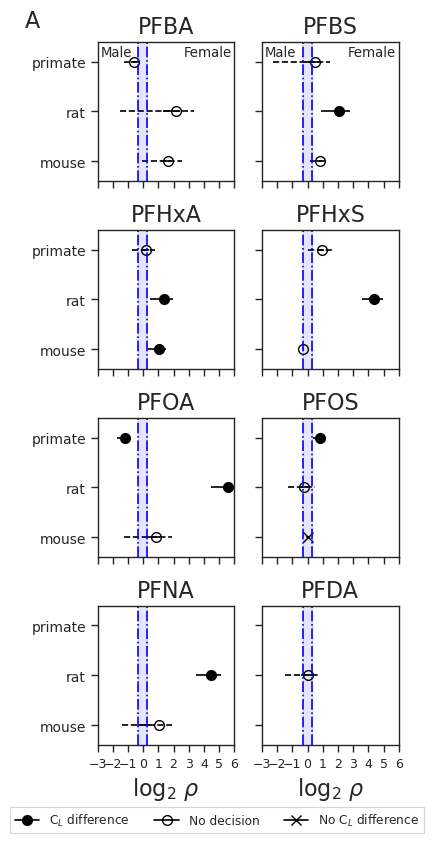

In [18]:
func_dict = {
            "25%": lambda x: np.percentile(x, 25),
            "75%": lambda x: np.percentile(x, 75)
            }
param = 'CLC [pop]'
rope=[0.8, 1.2] # ROPE represents +/- 20% difference in clearance
#fig, axs = plt.subplots(2, 4, figsize=(4*4, 2*4), sharex=True)
#fig, axs = plt.subplots(4, 2, figsize=(2*4, 4*4), sharey=True, sharex=True)
fig, axs = plt.subplots(4, 2, figsize=(4, 8), sharey=True, sharex=True)
ax = axs.flatten()
effect_df_list = []
for i, pfas in enumerate(pfas_order):
    print('CURRENTLY ON %s' % pfas)
    store_effect = []
    for species in species_order:
        CLCs = []
        for sex in sex_order:
            print(pfas, sex, species)
            model_row = df.loc[(df.PFAS == pfas) & (df.sex == sex) & (df.species == species)]
            print(model_row)
            if model_row.empty:
                continue
            pfas_data = pfas_tmp.get_processed_data(chemical=pfas, sex=sex, species=species)
            if (pfas == 'PFOA') and (sex=='Female') and (species=='rat'):
                pfas_data = pfas_data[~pfas_data.hero_id.isin([3858670])] # Remove 3858670
            elif (pfas == 'PFHxA') and (sex == 'Male') and (species == 'primate'): # Remove LoD issue data
                pfas_data = pfas_data[pfas_data.time_cor < 2]
            elif (pfas == 'PFHxA') and (sex == 'Female') and (species == 'primate'): # Remove LoD issue data
                pfas_data = pfas_data[pfas_data.time_cor < 1]
            
            pfas_model = PyPKMC(pfas_data, time_label='time_cor', y_obs_label='conc_mean_cor', sd_obs_label='conc_sd_cor',
                         route_label='route_idx', dose_label='dose_mg', BW_label='BW_cor', 
                         study_label='hero_id', dataset_label='dataset_str', indiv_label='aidx')
            pfas_model.sample(model_type=model_row['model'].values[0], load_trace=True)
            CLCs.append(pfas_model._trace.posterior[param])
        if CLCs:
            effect = CLCs[1] / CLCs[0]
            probability_within_rope = 100*((effect > rope[0]) & (effect <= rope[1])).mean()
            effect_summary = az.summary(effect, hdi_prob=0.95, kind='stats', stat_funcs=func_dict)
            effect_summary['ROPE_prob'] = np.round(probability_within_rope.values, 3)
            if (effect_summary.loc[param, 'hdi_2.5%'] > rope[0]) and (effect_summary.loc[param, 'hdi_97.5%'] < rope[1]):
                effect_summary['ROPE'] = 'Accept Null'
            #elif (effect < rope[0]).all() | (effect > rope[1]).all():
            elif (effect_summary.loc[param, 'hdi_2.5%'] > rope[1]) or (effect_summary.loc[param, 'hdi_97.5%'] < rope[0]):
                effect_summary['ROPE'] = 'Reject Null'
            else:
                effect_summary['ROPE'] = 'No Decision'

            study_lbl = '%s' % species
            effect_summary = effect_summary.rename(index={param:study_lbl})
            store_effect.append(effect_summary)
    effect_df = pd.concat(store_effect)
    effect_df['PFAS'] = pfas
    effect_df_list.append(effect_df)
    display(effect_df)
    ax[i].margins(y=0.2)
    # Reject Null plots
    if 'Reject Null' in effect_df.ROPE.values:
        l1 = ax[i].plot(effect_df.loc[effect_df.ROPE == 'Reject Null', 'mean'], effect_df.loc[effect_df.ROPE == 'Reject Null'].index, 'o', color='black', markersize=markersize, label='C$_L$ difference')
        ax[i].hlines(effect_df.loc[effect_df.ROPE == 'Reject Null'].index, effect_df.loc[effect_df.ROPE == 'Reject Null', '25%'], effect_df.loc[effect_df.ROPE == 'Reject Null', '75%'], color='black')#, linewidth=3)
        ax[i].hlines(effect_df.loc[effect_df.ROPE == 'Reject Null'].index, effect_df.loc[effect_df.ROPE == 'Reject Null', 'hdi_2.5%'], effect_df.loc[effect_df.ROPE == 'Reject Null', 'hdi_97.5%'], color='black')
    
    # Accept Null plots
    if 'Accept Null' in effect_df.ROPE.values:
        ax[i].plot(effect_df.loc[effect_df.ROPE == 'Accept Null', 'mean'], effect_df.loc[effect_df.ROPE == 'Accept Null'].index, 'x', color='black', markersize=markersize)
        ax[i].hlines(effect_df.loc[effect_df.ROPE == 'Accept Null'].index, effect_df.loc[effect_df.ROPE == 'Accept Null', '25%'], effect_df.loc[effect_df.ROPE == 'Accept Null', '75%'], color='black')#, linewidth=3)
        ax[i].hlines(effect_df.loc[effect_df.ROPE == 'Accept Null'].index, effect_df.loc[effect_df.ROPE == 'Accept Null', 'hdi_2.5%'], effect_df.loc[effect_df.ROPE == 'Accept Null', 'hdi_97.5%'], color='black')
   
    # No decicion plots
    if 'No Decision' in effect_df.ROPE.values:
        l2 = ax[i].plot(effect_df.loc[effect_df.ROPE == 'No Decision', 'mean'], effect_df.loc[effect_df.ROPE == 'No Decision'].index, 'o', color='black', fillstyle="none", markersize=markersize, label = 'No difference')
        ax[i].hlines(effect_df.loc[effect_df.ROPE == 'No Decision'].index, effect_df.loc[effect_df.ROPE == 'No Decision', '25%'], effect_df.loc[effect_df.ROPE == 'No Decision', '75%'], color='black', linestyle='-')#, linewidth=3, )
        ax[i].hlines(effect_df.loc[effect_df.ROPE == 'No Decision'].index, effect_df.loc[effect_df.ROPE == 'No Decision', 'hdi_2.5%'], effect_df.loc[effect_df.ROPE == 'No Decision', 'hdi_97.5%'], color='black', linestyle='--')

    ylims = ax[i].get_ylim()

    ax[i].axvspan(*rope, alpha=0.1, color='blue')
    ax[i].vlines(rope[0], *ylims, linestyle = '-.', color='blue')
    ax[i].vlines(rope[1], *ylims, linestyle = '-.', color='blue')
    _ = ax[i].set_ylim(ylims)
    ax[i].set_title(pfas, fontsize=16)
    ax[i].set_xscale('log', base=2)
    ax[i].tick_params(axis='y', labelsize=10)
    print('DONE WITH %s' % pfas)
    #break
    #if i == 1:
    #    break
    

for ax in axs[-1,:]:
    #ax.set_xlabel(r'log_2 $\rho$\nfold change', fontsize=16)
    ax.set_xlim([2**-3, 2**6])
    ax.xaxis.set_major_locator(mticker.LogLocator(numticks=999, base=2))
    ax.xaxis.set_major_formatter(mticker.LogFormatterExponent(base=2, labelOnlyBase=True))
    ax.set_xlabel(r'log$_2$ $\rho$', fontsize=16)
    ax.tick_params(axis='x', labelsize=9)

axs[0,0].text(0.02, 0.9, 'Male', transform = axs[0,0].transAxes, ha='left')
axs[0,0].text(0.98, 0.9, 'Female', transform = axs[0,0].transAxes, ha='right')
axs[0,1].text(0.02, 0.9, 'Male', transform = axs[0,1].transAxes, ha='left')
axs[0,1].text(0.98, 0.9, 'Female', transform = axs[0,1].transAxes, ha='right')


#fig.supxlabel(r'$log_2 \rho$', x=0.5, fontsize=16, horizontalalignment='center')
#axs[0,0].text(-0.3, 1.3, 'A', transform=axs[0,0].transAxes, fontsize=16, va='top', ha='right')
#axs[0,1].legend(loc='upper right')
fig.text(0.02, 0.99, 'A', fontsize=16, va='top', ha='left')
#fig.text(0.55, 0.02, r'log$_2$ $\rho$', fontsize=16, va='top', ha='center')
fig.tight_layout()
fig.subplots_adjust(bottom=0.07)#, wspace=0.33)
legend_elements = [Line2D([0], [0], marker='o', color='black', markeredgecolor='black', markerfacecolor='black', label='C$_L$ difference', markersize=markersize),
                   Line2D([0], [0], marker='o', color='black', markeredgecolor='black', label='No decision', markersize=markersize, fillstyle="none"),
                   Line2D([0], [0], marker='x', color='black', markeredgecolor='black', label='No C$_L$ difference', markersize=markersize, fillstyle="none"),
                  
                  ]
                          
axs[0, 1].legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0), bbox_transform=fig.transFigure, fancybox=False, shadow=False, ncol=3)

summary_df = pd.concat(effect_df_list)

summary_df.to_csv('Male_vs_Female_ROPE.csv')
fig.savefig('./figures/Figure5A.svg', bbox_inches='tight')
fig.savefig('./figures/Figure5A.pdf', bbox_inches='tight') 

In [19]:
summary_df.head(10)

,mean,sd,hdi_2.5%,hdi_97.5%,25%,75%,ROPE_prob,ROPE,PFAS
mouse,3.149,1.377,0.932,5.785,2.283,3.712,1.735,No Decision,PFBA
rat,4.437,3.552,0.347,10.213,2.500,5.250,2.670,No Decision,PFBA
primate,0.661,0.130,0.417,0.914,0.571,0.737,13.510,No Decision,PFBA
mouse,1.726,0.341,1.103,2.427,1.489,1.929,4.125,No Decision,PFBS
rat,4.238,1.325,1.858,6.812,3.328,4.949,0.005,Reject Null,PFBS
primate,1.377,0.814,0.206,2.753,0.891,1.656,29.197,No Decision,PFBS
mouse,2.028,0.412,1.249,2.860,1.766,2.256,1.250,Reject Null,PFHxA
rat,2.620,0.630,1.374,3.853,2.203,2.983,0.625,Reject Null,PFHxA
primate,1.134,0.311,0.596,1.747,0.920,1.297,54.190,No Decision,PFHxA
mouse,0.824,0.013,0.800,0.847,0.816,0.831,97.735,No Decision,PFHxS


## IV vs. Gavage

CURRENTLY ON PFBA
   PFAS   sex species          model                                                CLC                                                 Vd  CLC_mean  CLC_lower  CLC_upper  halft_mean  halft_lower  halft_upper   Vd_mean  Vd_lower  Vd_upper                          trace_path     BW
2  PFBA  Male   mouse  2-compartment  [0.20582334232192645, 0.2592942573565695, 0.27...  [0.19812454584924669, 0.2080266936234688, 0.09...  0.298209   0.137809   0.466804    0.723916     0.194683     1.336265  0.288048  0.114517  0.472245  ../traces/PFBA_Male_mouse_2cmpt.nc  0.025
Hero ID available:  [2325359]
dropping duplicated column
Hero ID used:  [2325359]
PFBA_Male_mouse_2cmpt
hierarchical model, 2-compartment
Checking metrics...
Pass all metrics = True
Assign pareto...
codes:  []
   PFAS   sex species          model                                                CLC                                                 Vd  CLC_mean  CLC_lower  CLC_upper  halft_mean  halft_lower  halft_upper

,mean,sd,hdi_2.5%,hdi_97.5%,25%,75%,ROPE_prob,ROPE,sex,PFAS
"Chang, 2008 (30,m)",2.455,0.678,1.766,3.585,2.089,2.600,0.000,Reject Null,Male,PFBA
"Chang, 2008 (30,f)",1.951,0.668,1.161,3.052,1.584,2.131,1.145,No Decision,Female,PFBA


DONE WITH PFBA
CURRENTLY ON PFBS
   PFAS   sex species          model                                                CLC                                                 Vd  CLC_mean  CLC_lower  CLC_upper  halft_mean  halft_lower  halft_upper  Vd_mean  Vd_lower  Vd_upper                          trace_path     BW
8  PFBS  Male   mouse  2-compartment  [1.3141128293160196, 1.1835937317640153, 1.296...  [0.2769085435298247, 0.36351742725555625, 0.36...  1.149508    0.92788   1.394159    0.186244      0.15443     0.221081   0.3095    0.2166  0.403822  ../traces/PFBS_Male_mouse_2cmpt.nc  0.025
Hero ID available:  [1326734 2850396 5387170 6579272]
dropping duplicated column
Hero ID used:  [6579272]
PFBS_Male_mouse_2cmpt
single level model, 2-compartment
Checking metrics...
Pass all metrics = True
Assign pareto...
   PFAS   sex species          model                                                CLC                                                 Vd  CLC_mean  CLC_lower  CLC_upper  halft_mean

,mean,sd,hdi_2.5%,hdi_97.5%,25%,75%,ROPE_prob,ROPE,sex,PFAS
"Olsen, 2009 (30,m)",1.576,0.580,0.656,2.691,1.195,1.832,22.510,No Decision,Male,PFBS
"Huang, 2019 (4,m)",1.341,0.325,0.819,1.949,1.129,1.476,36.560,No Decision,Male,PFBS
"Olsen, 2009 (30,f)",1.537,0.373,0.955,2.269,1.285,1.705,14.255,No Decision,Female,PFBS
"Huang, 2019 (4,f)",2.036,0.485,1.234,2.980,1.711,2.272,0.635,Reject Null,Female,PFBS


DONE WITH PFBS
CURRENTLY ON PFHxA
     PFAS   sex species          model                                                CLC                                                 Vd  CLC_mean  CLC_lower  CLC_upper  halft_mean  halft_lower  halft_upper   Vd_mean  Vd_lower  Vd_upper                           trace_path     BW
14  PFHxA  Male   mouse  2-compartment  [1.961917559533119, 1.9988361485011026, 2.2931...  [0.9848322103402367, 0.5585377966423032, 0.764...  2.206694   1.841286   2.594592    0.214918     0.140878     0.308521  0.686878  0.401116   1.03806  ../traces/PFHxA_Male_mouse_2cmpt.nc  0.025
Hero ID available:  [2850314 2850396 3859701 5916078 6822782]
dropping duplicated column
Hero ID used:  [2850314]
PFHxA_Male_mouse_2cmpt
single level model, 2-compartment
Checking metrics...
Pass all metrics = True
Assign pareto...
     PFAS   sex species          model                                                CLC                                                 Vd  CLC_mean  CLC_lower  C

,mean,sd,hdi_2.5%,hdi_97.5%,25%,75%,ROPE_prob,ROPE,sex,PFAS
"Dzierlenga, 2019 (40,m)",1.320,0.222,0.97,1.751,1.160,1.442,32.395,No Decision,Male,PFHxA
"Dzierlenga, 2019 (40,f)",1.912,0.631,0.95,3.104,1.465,2.239,8.240,No Decision,Female,PFHxA


DONE WITH PFHxA
CURRENTLY ON PFHxS
     PFAS   sex species          model                                                CLC                                                 Vd  CLC_mean  CLC_lower  CLC_upper  halft_mean  halft_lower  halft_upper   Vd_mean  Vd_lower  Vd_upper                           trace_path     BW
20  PFHxS  Male   mouse  1-compartment  [0.003806125987733776, 0.0038223603404020537, ...  [0.1562719127435079, 0.1586039126881562, 0.141...  0.003809   0.003488   0.004133   27.397326    25.625428    29.450666  0.150581   0.13384  0.168028  ../traces/PFHxS_Male_mouse_1cmpt.nc  0.025
Hero ID available:  [1289834 3749289 4239569 5387170]
No BW info for mouse in 1289834, using defaults
No BW info for mouse in 1289834, using defaults
No BW info for mouse in 1289834, using defaults
No BW info for mouse in 1289834, using defaults
No BW info for mouse in 1289834, using defaults
No BW info for mouse in 1289834, using defaults
No BW info for mouse in 1289834, using defaults
No BW

,mean,sd,hdi_2.5%,hdi_97.5%,25%,75%,ROPE_prob,ROPE,sex,PFAS
"Kim, 2016 (4,m)",1.519,0.360,1.016,2.249,1.272,1.673,14.057,No Decision,Male,PFHxS
"Kim, 2018 (10,m)",0.820,0.341,0.255,1.485,0.587,0.986,33.482,No Decision,Male,PFHxS
"Huang, 2019 (4,m)",0.980,0.210,0.605,1.384,0.846,1.084,71.664,No Decision,Male,PFHxS
"Kim, 2016 (4,f)",2.285,0.626,1.519,3.425,1.907,2.467,0.000,Reject Null,Female,PFHxS
"Kim, 2018 (1,f)",2.051,0.395,1.553,2.821,1.809,2.173,0.000,Reject Null,Female,PFHxS
"Kim, 2018 (4,f)",2.393,0.564,1.729,3.448,2.050,2.549,0.000,Reject Null,Female,PFHxS
"Huang, 2019 (4,f)",1.506,0.250,1.112,1.991,1.342,1.615,4.525,No Decision,Female,PFHxS


DONE WITH PFHxS
CURRENTLY ON PFOA
    PFAS   sex species          model                                                CLC                                                 Vd  CLC_mean  CLC_lower  CLC_upper  halft_mean  halft_lower  halft_upper   Vd_mean  Vd_lower  Vd_upper                          trace_path     BW
26  PFOA  Male   mouse  2-compartment  [0.007561398114753379, 0.006790058366996393, 0...  [0.25167639772629385, 0.234480592225243, 0.273...  0.006938   0.006085   0.007771   25.630496    20.119525    31.968723  0.252157  0.205973  0.303788  ../traces/PFOA_Male_mouse_2cmpt.nc  0.025
Hero ID available:  [2919359 2990271 3749227 3749289 3858670 3859701 5916078 6302380]
No BW info for mouse in 2919359, using defaults
No BW info for mouse in 2919359, using defaults
No BW info for mouse in 2919359, using defaults
No BW info for mouse in 2919359, using defaults
No BW info for mouse in 2919359, using defaults
No BW info for mouse in 2919359, using defaults
No BW info for mouse in 29

,mean,sd,hdi_2.5%,hdi_97.5%,25%,75%,ROPE_prob,ROPE,sex,PFAS
"Kim, 2016 (1,m)",1.245,0.219,0.883,1.658,1.108,1.340,46.965,No Decision,Male,PFOA
"Dzierlenga, 2019 (6,m)",1.512,0.284,1.031,2.065,1.319,1.653,9.660,No Decision,Male,PFOA
"Kemper, 2003 (1,m)",1.273,0.279,0.738,1.803,1.089,1.429,39.210,No Decision,Male,PFOA
"Kim, 2016 (1,f)",1.214,0.231,0.846,1.685,1.062,1.320,54.675,No Decision,Female,PFOA
"Dzierlenga, 2019 (40,f)",1.423,0.342,0.820,2.079,1.192,1.590,25.535,No Decision,Female,PFOA
"Kemper, 2003 (1,f)",1.920,0.330,1.373,2.575,1.699,2.085,0.050,Reject Null,Female,PFOA


DONE WITH PFOA
CURRENTLY ON PFOS
    PFAS   sex species          model                                                CLC                                                 Vd  CLC_mean  CLC_lower  CLC_upper  halft_mean  halft_lower  halft_upper   Vd_mean  Vd_lower  Vd_upper                          trace_path     BW
32  PFOS  Male   mouse  1-compartment  [0.005578569698668093, 0.005938875844925154, 0...  [0.2783123282462306, 0.290354399367698, 0.3091...  0.005587   0.005177   0.006009   35.490518    32.351155    38.554533  0.285961  0.257003  0.315222  ../traces/PFOS_Male_mouse_1cmpt.nc  0.025
Hero ID available:  [1289832 3749289 3859701 5387170]
No BW info for mouse in 1289832, using defaults
No BW info for mouse in 1289832, using defaults
No BW info for mouse in 1289832, using defaults
No BW info for mouse in 1289832, using defaults
No BW info for mouse in 1289832, using defaults
No BW info for mouse in 1289832, using defaults
No BW info for mouse in 1289832, using defaults
No BW info 

,mean,sd,hdi_2.5%,hdi_97.5%,25%,75%,ROPE_prob,ROPE,sex,PFAS
"Kim, 2016 (2,m)",1.624,0.444,0.899,2.488,1.339,1.813,10.815,No Decision,Male,PFOS
"Huang, 2019 (2,m)",1.481,0.350,0.958,2.161,1.253,1.631,17.790,No Decision,Male,PFOS
"Kim, 2016 (2,f)",1.508,0.442,0.947,2.367,1.247,1.640,17.360,No Decision,Female,PFOS
"Huang, 2019 (2,f)",2.886,0.653,1.858,4.091,2.467,3.153,0.000,Reject Null,Female,PFOS


DONE WITH PFOS
CURRENTLY ON PFNA
    PFAS   sex species          model                                                CLC                                                 Vd  CLC_mean  CLC_lower  CLC_upper  halft_mean  halft_lower  halft_upper   Vd_mean  Vd_lower  Vd_upper                          trace_path     BW
38  PFNA  Male   mouse  2-compartment  [0.0027979263046904643, 0.003503312382643152, ...  [0.5944382905885193, 0.6196937935483089, 0.569...  0.003928   0.000828   0.006354  227.459627    46.698764   445.872398  0.602612  0.508477  0.729341  ../traces/PFNA_Male_mouse_2cmpt.nc  0.025
Hero ID available:  [2919268 3858670 3859701 5063958]
dropping duplicated column
Hero ID used:  [2919268]
PFNA_Male_mouse_2cmpt
single level model, 2-compartment
Checking metrics...
Pass all metrics = True
Assign pareto...
    PFAS   sex species          model                                                CLC                                                 Vd  CLC_mean  CLC_lower  CLC_upper  halft

,mean,sd,hdi_2.5%,hdi_97.5%,25%,75%,ROPE_prob,ROPE,sex,PFAS
"Kim, 2019 (3,m)",1.326,0.751,0.356,2.643,0.875,1.558,35.380,No Decision,Male,PFNA
"Kim, 2019 (0.5,f)",1.032,0.106,0.829,1.237,0.963,1.090,93.175,No Decision,Female,PFNA
"Kim, 2019 (1,f)",1.081,0.114,0.889,1.321,1.002,1.142,86.475,No Decision,Female,PFNA
"Kim, 2019 (3,f)",1.211,0.143,0.965,1.489,1.110,1.292,50.750,No Decision,Female,PFNA


DONE WITH PFNA
CURRENTLY ON PFDA
Empty DataFrame
Columns: [PFAS, sex, species, model, CLC, Vd, CLC_mean, CLC_lower, CLC_upper, halft_mean, halft_lower, halft_upper, Vd_mean, Vd_lower, Vd_upper, trace_path, BW]
Index: []
    PFAS   sex species          model                                                CLC                                                 Vd  CLC_mean  CLC_lower  CLC_upper  halft_mean  halft_lower  halft_upper   Vd_mean  Vd_lower  Vd_upper                        trace_path    BW
42  PFDA  Male     rat  2-compartment  [0.0037891608008026267, 0.0038201999970064724,...  [0.3450696740425878, 0.35307974552205224, 0.35...  0.003459   0.001682    0.00554   88.404604    35.632493    153.25351  0.405538  0.249158  0.578981  ../traces/PFDA_Male_rat_2cmpt.nc  0.25
Hero ID available:  [3858670 5063958 5916078]
dropping duplicated column
Hero ID used:  [3858670 5063958 5916078]
PFDA_Male_rat_2cmpt
hierarchical model, 2-compartment
Checking metrics...
Pass all metrics = True
Assign p

,mean,sd,hdi_2.5%,hdi_97.5%,25%,75%,ROPE_prob,ROPE,sex,PFAS
"Kim, 2019 (1,m)",0.583,0.212,0.248,0.989,0.455,0.660,9.555,No Decision,Male,PFDA
"Dzierlenga, 2019 (2,m)",1.953,0.706,0.863,3.404,1.556,2.191,4.160,No Decision,Male,PFDA
"Kim, 2019 (1,f)",1.083,0.315,0.640,1.737,0.891,1.190,66.605,No Decision,Female,PFDA
"Dzierlenga, 2019 (2,f)",2.586,0.879,1.688,3.955,2.126,2.785,0.000,Reject Null,Female,PFDA


DONE WITH PFDA


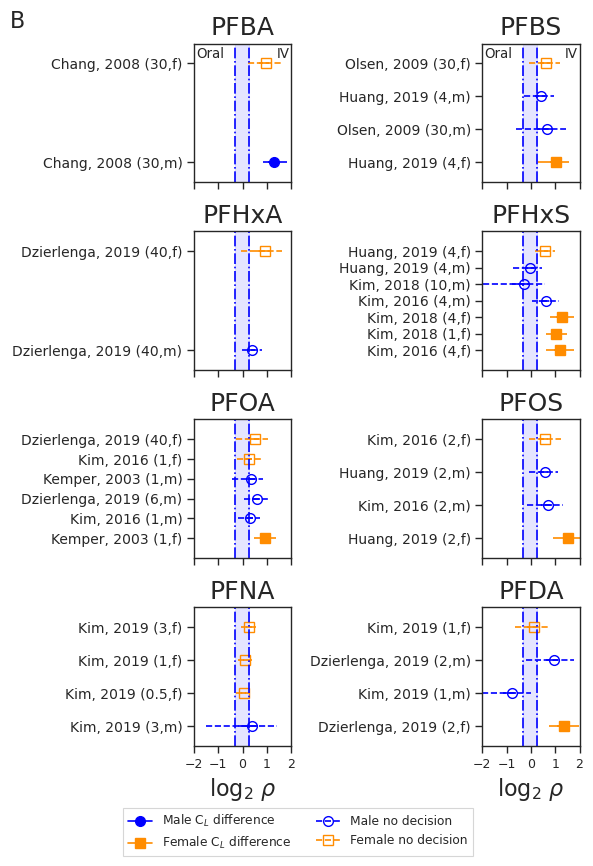

In [33]:
func_dict = {
            "25%": lambda x: np.percentile(x, 25),
            "75%": lambda x: np.percentile(x, 75)
            }
hdi_prob = 0.95
high_result = round(100*(1+hdi_prob)/2, 4)
low_result = round(100*(1-hdi_prob)/2, 4)
low_perc = str(int(low_result)) if low_result.is_integer() else str(low_result)
high_perc = str(int(high_result)) if high_result.is_integer() else str(high_result)

hdi_low = 'hdi_' + low_perc + '%'
hdi_high = 'hdi_' + high_perc + '%'
param = 'CLC [indiv]'
#param = 'halft_beta [indiv]'
#rope=[0.9, 1.1]
rope=[0.8, 1.2]
#fig, axs = plt.subplots(2, 4, figsize=(4*4, 2*4), sharex=True)
#fig, axs = plt.subplots(4, 2, figsize=(2*4, 4*4), sharex=True)
fig, axs = plt.subplots(4, 2, figsize=(6, 8), sharex=True)

ax = axs.flatten()
effect_df_list = []
for i, pfas in enumerate(pfas_order):
    print('CURRENTLY ON %s' % pfas)
    store_effect = []
    for sex in sex_order:
        for species in species_order:
            if species == 'primate':
                continue
            model_row = df.loc[(df.PFAS == pfas) & (df.sex == sex) & (df.species == species)]
            print(model_row)
            if model_row.empty:
                continue
            pfas_data = pfas_tmp.get_processed_data(chemical=pfas, sex=sex, species=species)
            if (pfas == 'PFOA') and (sex=='Female') and (species=='rat'):
                pfas_data = pfas_data[~pfas_data.hero_id.isin([3858670])] # Remove 3858670
            
            pfas_model = PyPKMC(pfas_data, time_label='time_cor', y_obs_label='conc_mean_cor', sd_obs_label='conc_sd_cor',
                         route_label='route_idx', dose_label='dose_mg', BW_label='BW_cor', 
                         study_label='hero_id', dataset_label='dataset_str', indiv_label='aidx')
            pfas_model.sample(model_type=model_row['model'].values[0], load_trace=True)
            if param not in pfas_model._trace.posterior:
                continue
            print('codes: ', pfas_model.iv_oral_codes)
            if pfas_model.iv_oral_codes:
                iv_oral_pairs = [pfas_model.iv_oral_codes[i:i + 2] for i in range(0, len(pfas_model.iv_oral_codes), 2)]
                for j, iv_oral in enumerate(iv_oral_pairs):
                    iv, oral = iv_oral
                    #effect = (pfas_model._trace.posterior[param].sel(dataset=iv) - pfas_model._trace.posterior[param].sel(dataset=oral))/ pfas_model._trace.posterior[param].sel(dataset=iv)
                    effect = pfas_model._trace.posterior[param].sel(dataset=iv) / pfas_model._trace.posterior[param].sel(dataset=oral)
                    probability_within_rope = 100*((effect > rope[0]) & (effect <= rope[1])).mean()
                    effect_summary = az.summary(effect, hdi_prob=hdi_prob, kind='stats', stat_funcs=func_dict)
                    effect_summary['ROPE_prob'] = np.round(probability_within_rope.values, 3)
                    
                    if (effect_summary.loc[param, hdi_low] > rope[0]) and (effect_summary.loc[param, hdi_high] < rope[1]):
                        effect_summary['ROPE'] = 'Accept Null'
                    #elif (effect < rope[0]).all() | (effect > rope[1]).all():
                    elif (effect_summary.loc[param, hdi_low] > rope[1]) or (effect_summary.loc[param, hdi_high] < rope[0]):
                        effect_summary['ROPE'] = 'Reject Null'
                    else:
                        effect_summary['ROPE'] = 'No Decision'
                    
                    hero_id, dose, _ = iv.split('-')
                    #study_lbl = '%s\n%s %s: %s' % (study_mapper[hero_id], sex.lower(), species, dose)
                    mgkg_dose = float(dose.split(' ')[0])
                    if mgkg_dose >=1:
                        study_lbl = '%s (%s,%s)' % (study_mapper[hero_id], int(mgkg_dose), sex.lower()[0])
                    else:
                        study_lbl = '%s (%0.1f,%s)' % (study_mapper[hero_id], mgkg_dose, sex.lower()[0])
                    effect_summary = effect_summary.rename(index={param:study_lbl})
                    effect_summary['sex'] = sex
                    store_effect.append(effect_summary)
    effect_df = pd.concat(store_effect)
    effect_df['PFAS'] = pfas
    effect_df_list.append(effect_df)
    display(effect_df)
    #ax[i].plot(effect_df.iloc[:, 0], effect_df.index, 'bo')
    ax[i].margins(y=0.2)
    # Reject Null plots
    if 'Reject Null' in effect_df.ROPE.values:
        #ax[i].plot(effect_df.loc[effect_df.ROPE == 'Reject Null', 'mean'], effect_df.loc[effect_df.ROPE == 'Reject Null'].index, 'o', color='blue', markersize=markersize)
        
        ax[i].plot(effect_df.loc[(effect_df.ROPE == 'Reject Null') & (effect_df.sex == 'Male'), 'mean'], effect_df.loc[(effect_df.ROPE == 'Reject Null') & (effect_df.sex == 'Male')].index, 'o', color='blue', markersize=markersize)
        ax[i].plot(effect_df.loc[(effect_df.ROPE == 'Reject Null') & (effect_df.sex == 'Female'), 'mean'], effect_df.loc[(effect_df.ROPE == 'Reject Null') & (effect_df.sex == 'Female')].index, 's', color='darkorange',  markersize=markersize)
        
        ax[i].hlines(effect_df.loc[(effect_df.ROPE == 'Reject Null') & (effect_df.sex == 'Male')].index, effect_df.loc[(effect_df.ROPE == 'Reject Null') & (effect_df.sex == 'Male'), '25%'], effect_df.loc[(effect_df.ROPE == 'Reject Null') & (effect_df.sex == 'Male'), '75%'], color='blue')#, linewidth=3)
        ax[i].hlines(effect_df.loc[(effect_df.ROPE == 'Reject Null') & (effect_df.sex == 'Female')].index, effect_df.loc[(effect_df.ROPE == 'Reject Null') & (effect_df.sex == 'Female'), '25%'], effect_df.loc[(effect_df.ROPE == 'Reject Null') & (effect_df.sex == 'Female'), '75%'], color='darkorange')#, linewidth=3)
        
        ax[i].hlines(effect_df.loc[(effect_df.ROPE == 'Reject Null') & (effect_df.sex == 'Male')].index, effect_df.loc[(effect_df.ROPE == 'Reject Null') & (effect_df.sex == 'Male'), hdi_low], effect_df.loc[(effect_df.ROPE == 'Reject Null') & (effect_df.sex == 'Male'), hdi_high], color='blue')
        ax[i].hlines(effect_df.loc[(effect_df.ROPE == 'Reject Null') & (effect_df.sex == 'Female')].index, effect_df.loc[(effect_df.ROPE == 'Reject Null') & (effect_df.sex == 'Female'), hdi_low], effect_df.loc[(effect_df.ROPE == 'Reject Null') & (effect_df.sex == 'Female'), hdi_high], color='darkorange')
    
    # Accept Null plots
    if 'Accept Null' in effect_df.ROPE.values:

        ax[i].plot(effect_df.loc[(effect_df.ROPE == 'Accept Null') & (effect_df.sex == 'Male'), 'mean'], 
                   effect_df.loc[(effect_df.ROPE == 'Accept Null') & (effect_df.sex == 'Male')].index, 'x', 
                   color='blue', fillstyle="none", markersize=markersize)
        ax[i].plot(effect_df.loc[(effect_df.ROPE == 'Accept Null') & (effect_df.sex == 'Female'), 'mean'], 
                   effect_df.loc[(effect_df.ROPE == 'Accept Null') & (effect_df.sex == 'Female')].index, 'x', 
                   color='darkorange', markersize=markersize)
        
        ax[i].hlines(effect_df.loc[(effect_df.ROPE == 'Accept Null') & (effect_df.sex == 'Male')].index, effect_df.loc[(effect_df.ROPE == 'Accept Null') & (effect_df.sex == 'Male'), hdi_low], effect_df.loc[(effect_df.ROPE == 'Accept Null') & (effect_df.sex == 'Male'), hdi_high], color='blue')
        ax[i].hlines(effect_df.loc[(effect_df.ROPE == 'Accept Null') & (effect_df.sex == 'Female')].index, effect_df.loc[(effect_df.ROPE == 'Accept Null') & (effect_df.sex == 'Female'), hdi_low], effect_df.loc[(effect_df.ROPE == 'Accept Null') & (effect_df.sex == 'Female'), hdi_high], color='darkorange')

    
    # No decicion plots
    if 'No Decision' in effect_df.ROPE.values:
        #ax[i].plot(effect_df.loc[effect_df.ROPE == 'No Decision', 'mean'], effect_df.loc[effect_df.ROPE == 'No Decision'].index, 's', color='darkorange', markersize=markersize)
        
        
        ax[i].plot(effect_df.loc[(effect_df.ROPE == 'No Decision') & (effect_df.sex == 'Male'), 'mean'], effect_df.loc[(effect_df.ROPE == 'No Decision') & (effect_df.sex == 'Male')].index, 'o', color='blue', fillstyle="none", markersize=markersize)
        ax[i].plot(effect_df.loc[(effect_df.ROPE == 'No Decision') & (effect_df.sex == 'Female'), 'mean'], effect_df.loc[(effect_df.ROPE == 'No Decision') & (effect_df.sex == 'Female')].index, 's', color='darkorange', fillstyle="none", markersize=markersize)
        
        ax[i].hlines(effect_df.loc[(effect_df.ROPE == 'No Decision') & (effect_df.sex == 'Male')].index, effect_df.loc[(effect_df.ROPE == 'No Decision') & (effect_df.sex == 'Male'), '25%'], effect_df.loc[(effect_df.ROPE == 'No Decision') & (effect_df.sex == 'Male'), '75%'], color='blue', linestyle='-')#, linewidth=3)
        ax[i].hlines(effect_df.loc[(effect_df.ROPE == 'No Decision') & (effect_df.sex == 'Female')].index, effect_df.loc[(effect_df.ROPE == 'No Decision') & (effect_df.sex == 'Female'), '25%'], effect_df.loc[(effect_df.ROPE == 'No Decision') & (effect_df.sex == 'Female'), '75%'], color='darkorange', linestyle='-')#, linewidth=3)
        
        ax[i].hlines(effect_df.loc[(effect_df.ROPE == 'No Decision') & (effect_df.sex == 'Male')].index, effect_df.loc[(effect_df.ROPE == 'No Decision') & (effect_df.sex == 'Male'), hdi_low], effect_df.loc[(effect_df.ROPE == 'No Decision') & (effect_df.sex == 'Male'), hdi_high], color='blue', linestyle='--')
        ax[i].hlines(effect_df.loc[(effect_df.ROPE == 'No Decision') & (effect_df.sex == 'Female')].index, effect_df.loc[(effect_df.ROPE == 'No Decision') & (effect_df.sex == 'Female'), hdi_low], effect_df.loc[(effect_df.ROPE == 'No Decision') & (effect_df.sex == 'Female'), hdi_high], color='darkorange', linestyle='--')

    ylims = ax[i].get_ylim()

    ax[i].axvspan(*rope, alpha=0.1, color='blue')
    ax[i].vlines(rope[0], *ylims, linestyle = '-.', color='blue')
    ax[i].vlines(rope[1], *ylims, linestyle = '-.', color='blue')
    _ = ax[i].set_ylim(ylims)
    ax[i].set_title(pfas, fontsize=18)
    ax[i].tick_params(axis='y', labelsize=10)
    
    ax[i].set_xscale('log', base=2)
    ax[i].xaxis.set_major_locator(mticker.LogLocator(numticks=999))
    ax[i].xaxis.set_minor_locator(mticker.NullLocator())
    print('DONE WITH %s' % pfas)
    #break

for ax in axs[-1,:]:
    #ax.set_xlabel(r'log_2 $\rho$\nfold change', fontsize=16)
    ax.set_xlim([2**-2, 2**2])
    ax.xaxis.set_major_locator(mticker.LogLocator(numticks=999, base=2))
    ax.xaxis.set_major_formatter(mticker.LogFormatterExponent(base=2, labelOnlyBase=True))
    ax.set_xlabel(r'log$_2$ $\rho$', fontsize=16)
    ax.tick_params(axis='x', labelsize=9)
#fig.supxlabel(r'$log_2 \rho$', x=0.5, fontsize=16, horizontalalignment='center')
#axs[0,0].text(-0.3, 1.3, 'A', transform=axs[0,0].transAxes, fontsize=16, va='top', ha='right')

axs[0,0].text(0.02, 0.9, 'Oral', transform = axs[0,0].transAxes, ha='left')
axs[0,0].text(0.98, 0.9, 'IV', transform = axs[0,0].transAxes, ha='right')
axs[0,1].text(0.02, 0.9, 'Oral', transform = axs[0,1].transAxes, ha='left')
axs[0,1].text(0.98, 0.9, 'IV', transform = axs[0,1].transAxes, ha='right')

fig.text(0.02, 0.99, 'B', fontsize=16, va='top', ha='left')
#fig.text(0.55, 0.02, r'log$_2$ $\rho$', fontsize=16, va='top', ha='center')
fig.tight_layout()
fig.subplots_adjust(bottom=0.07)#, wspace=0.33)
legend_elements = [Line2D([0], [0], marker='o', color='blue', markeredgecolor='blue', markerfacecolor='blue', label='Male C$_L$ difference', markersize=markersize),
                   Line2D([0], [0], marker='s', color='darkorange', markeredgecolor='darkorange', markerfacecolor='darkorange', label='Female C$_L$ difference', markersize=markersize),
                   
                   Line2D([0], [0], marker='o', color='blue', markeredgecolor='blue', label='Male no decision', markersize=markersize, fillstyle="none", linestyle='--'),
                   Line2D([0], [0], marker='s', color='darkorange', markeredgecolor='darkorange', label='Female no decision', markersize=markersize, fillstyle="none",linestyle='--'),
                  
                   #Line2D([0], [0], marker='x', color='blue', markeredgecolor='blue', label='Male no C$_L$ difference', markersize=markersize),
                   #Line2D([0], [0], marker='x', color='darkorange', markeredgecolor='darkorange', label='Female no C$_L$ difference', markersize=markersize)
                  ]
                          
axs[0, 1].legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0), bbox_transform=fig.transFigure, fancybox=False, shadow=False, ncol=2)

summary_df = pd.concat(effect_df_list)
summary_df.to_csv('IV_vs_Gavage_ROPE.csv')
fig.savefig('./figures/Figure5B.svg', bbox_inches='tight')
fig.savefig('./figures/Figure5B.pdf', bbox_inches='tight') 

In [34]:
summary_df.head()

,mean,sd,hdi_2.5%,hdi_97.5%,25%,75%,ROPE_prob,ROPE,sex,PFAS
"Chang, 2008 (30,m)",2.455,0.678,1.766,3.585,2.089,2.600,0.000,Reject Null,Male,PFBA
"Chang, 2008 (30,f)",1.951,0.668,1.161,3.052,1.584,2.131,1.145,No Decision,Female,PFBA
"Olsen, 2009 (30,m)",1.576,0.580,0.656,2.691,1.195,1.832,22.510,No Decision,Male,PFBS
"Huang, 2019 (4,m)",1.341,0.325,0.819,1.949,1.129,1.476,36.560,No Decision,Male,PFBS
"Olsen, 2009 (30,f)",1.537,0.373,0.955,2.269,1.285,1.705,14.255,No Decision,Female,PFBS


# Supplemental

Additional supplemental figures and results

## Summary PK stats table and unity line figure

Generate the summary population-level PK results for each PFAS/species/sex combination

Unity line figure has +/- 3-fold error

In [13]:
species_order = ['mouse', 'rat', 'primate']
markersize=4
linewidth=1

# Helper function to format CI
def CI_str(row):
    tmp_str = '%.4g (%.4g, %.4g)'
    return tmp_str%(row['mean'], row['hdi_2.5%'], row['hdi_97.5%'])

# Template multi-level dataframe that gets filled in
pk_params = ['CLC (L/kg/d)', 'Vd (L/kg)', 'halft (d)']
meas = ['Pop mean (95% CI)', 'Pop GSD (95% CI)']
df1 = pd.DataFrame(index=pd.MultiIndex(levels=[[]]*3, 
                                      codes=[[]]*3, 
                                      names=['PFAS','Species','Sex']), 
                 columns=pd.MultiIndex.from_product([['Model summary'], ['Model', 'MSLE', 'R^2']]))
df2 = pd.DataFrame(index=pd.MultiIndex(levels=[[]]*3, 
                                      codes=[[]]*3, 
                                      names=['PFAS','Species','Sex']), 
                 columns=pd.MultiIndex.from_product([pk_params, meas]))
stats_df = pd.concat([df1, df2], axis=1)
display(stats_df)

Empty DataFrame
Columns: [(Model summary, Model), (Model summary, MSLE), (Model summary, R^2), (CLC (L/kg/d), Pop mean (95% CI)), (CLC (L/kg/d), Pop GSD (95% CI)), (Vd (L/kg), Pop mean (95% CI)), (Vd (L/kg), Pop GSD (95% CI)), (halft (d), Pop mean (95% CI)), (halft (d), Pop GSD (95% CI))]
Index: []

In [17]:
pop_GM

,mean,sd,hdi_2.5%,hdi_97.5%,CI_str
CLC [pop],3.22000,0.80000,1.78000,4.82000,"3.22 (1.78, 4.82)"
Vdss [pop],300.71000,67.12000,188.25000,446.36000,"300.7 (188.2, 446.4)"
halft [pop],68.77509,24.93228,27.71911,116.17763,"68.78 (27.72, 116.2)"


Hero ID available:  [2325359]
dropping duplicated column
Hero ID used:  [2325359]
PFBA_Male_rat_2cmpt
hierarchical model, 2-compartment
Checking metrics...
Pass all metrics = True
Assign pareto...
('PFBA', 'rat', 'Male')
Hero ID available:  [2325359]
dropping duplicated column
Hero ID used:  [2325359]
PFBA_Female_rat_2cmpt
hierarchical model, 2-compartment
Checking metrics...
Pass all metrics = True
Assign pareto...
('PFBA', 'rat', 'Female')
Hero ID available:  [2325359]
dropping duplicated column
Hero ID used:  [2325359]
PFBA_Male_mouse_2cmpt
hierarchical model, 2-compartment
Checking metrics...
Pass all metrics = True
Assign pareto...
('PFBA', 'mouse', 'Male')
Hero ID available:  [2325359]
dropping duplicated column
Hero ID used:  [2325359]
PFBA_Female_mouse_2cmpt
hierarchical model, 2-compartment
Checking metrics...
Pass all metrics = True
Assign pareto...
('PFBA', 'mouse', 'Female')
Hero ID available:  [2325359]
dropping duplicated column
Hero ID used:  [2325359]
PFBA_Male_primate_

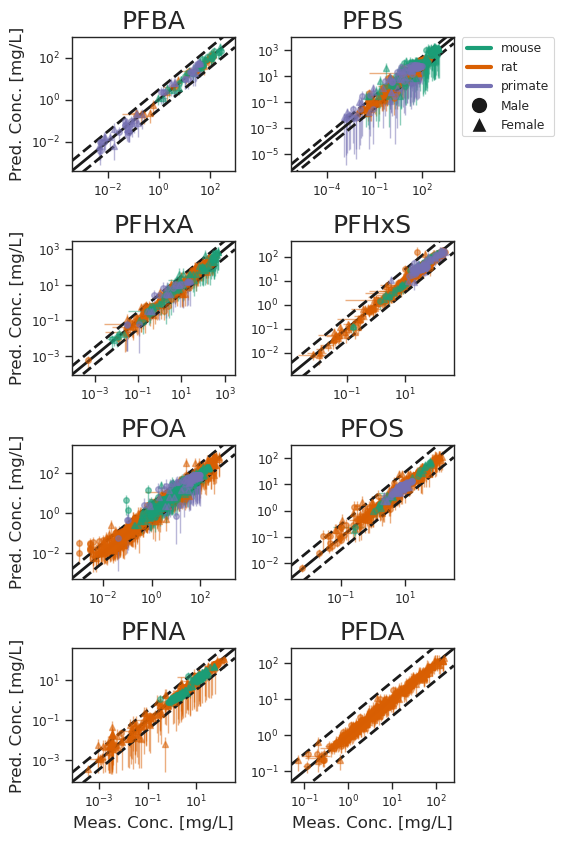

In [16]:
fig, axs = plt.subplots(4,2,figsize=(5.75, 8.5), sharex=False, sharey=False)
all_ax = axs.flatten()
ax_lims = dict(zip(pfas_order, [[1,1]]*len(pfas_order))) # initialize empty lists for axis limits

species_order.insert(0, species_order.pop(species_order.index('rat'))) # Move rat to first so mouse and primate can be seen
all_combos = list(itools.product(pfas_order, species_order, sex_order))
df = pd.read_csv('../auxiliary/model_selecton.csv')
df.dropna(inplace=True, axis=0, how='any') # Remove PFAS that don't have a model

# Dataframe to store stats as we loop through each trace
pk_params = ['fa', 'CLC (L/kg/d)', 'Vd (L/kg)', 'halft (d)']
meas = ['Pop mean (95% CI)', 'Pop GSD (95% CI)']

df1 = pd.DataFrame(index=pd.MultiIndex(levels=[[]]*3, 
                                      codes=[[]]*3, 
                                      names=['PFAS','Species','Sex']), 
                 columns=pd.MultiIndex.from_product([['Model summary'], ['Model', 'MSLE', 'R^2']]))
df2 = pd.DataFrame(index=pd.MultiIndex(levels=[[]]*3, 
                                      codes=[[]]*3, 
                                      names=['PFAS','Species','Sex']), 
                 columns=pd.MultiIndex.from_product([pk_params, meas]))
stats_df = pd.concat([df1, df2], axis=1)


for i, combo in enumerate(all_combos):
    #combo = ('PFNA', 'rat', 'Female')
    cur_PFAS, cur_species, cur_sex = combo
    pfas_df = df[(df.PFAS == cur_PFAS) & (df.species == cur_species) & (df.sex == cur_sex)]
    if pfas_df.empty:
        stats_df.loc[(cur_PFAS, cur_species, cur_sex), :] = '-'
        continue
    
    model_type = pfas_df.model.values[0]
    
    ax = all_ax[pfas_order.index(cur_PFAS)]
    
    pfas_data = pfas_tmp.get_processed_data(chemical=cur_PFAS, sex=cur_sex, species=cur_species)
    if ((cur_PFAS == 'PFOA') & (cur_sex == 'Female') & (cur_species=='rat')):
        print('Removing Ohmori data for Female rats because data only measured 6 hrs')
        pfas_data = pfas_data[~pfas_data.hero_id.isin([3858670])] # Remove 3858670
    
    if ((cur_PFAS == 'PFHxA') & (cur_species == 'primate')):
        if cur_sex == 'Male':
            print('Removing Male data with LoD issues')
            pfas_data = pfas_data[pfas_data.time_cor < 2]
        elif cur_sex == 'Female':
            print('Removing Female data with LoD issues')
            pfas_data = pfas_data[pfas_data.time_cor < 1]
    
    ### Add primate PFHxA adjustment here ###
    
    #if ((cur_PFAS == 'PFBS') & (cur_species == 'primate')) or ((cur_PFAS == 'PFOA') & (cur_species == 'mouse') & (cur_sex == 'Male')) or ((cur_PFAS == 'PFNA') & (cur_species == 'mouse')):
    #    hierarchy = 'single'
    if ((cur_PFAS == 'PFBA') & (cur_species == 'rat')):
        hierarchy = 'multi'
    else:
        hierarchy = 'default'
    
    pfas_model = PyPKMC(pfas_data, time_label='time_cor', y_obs_label='conc_mean_cor', sd_obs_label='conc_sd_cor',
                        route_label='route_idx', dose_label='dose_mg', BW_label='BW_cor', 
                        study_label='hero_id', dataset_label='dataset_str', indiv_label='aidx',)
    pfas_model.sample(model_type = pfas_df.model.values[0], load_trace=True, sample_prior=False, 
                      sample_posterior=False, nuts_sampler='numpyro', hierarchy=hierarchy)
    
    pop_GM = az.summary(pfas_model._trace, var_names = ['CLC [pop]', 'Vdss [pop]', 'halft [pop]'], hdi_prob=0.95, kind='stats', round_to=5)
    # Convert L --> ml
    pop_GM.loc[['CLC [pop]', 'Vdss [pop]']] *= 1000
    pop_GM['CI_str'] = pop_GM.apply(CI_str, axis=1)
    stats_df.loc[(cur_PFAS, cur_species, cur_sex), ('CLC (L/kg/d)', 'Pop mean (95% CI)')] = pop_GM.loc['CLC [pop]', 'CI_str']
    stats_df.loc[(cur_PFAS, cur_species, cur_sex), ('Vd (L/kg)', 'Pop mean (95% CI)')] = pop_GM.loc['Vdss [pop]', 'CI_str']
    stats_df.loc[(cur_PFAS, cur_species, cur_sex), ('halft (d)', 'Pop mean (95% CI)')] = pop_GM.loc['halft [pop]', 'CI_str']

    print(combo)
    if pfas_model.model_structure == 'hierarchical':
        pop_GSD = az.summary(pfas_model._trace, var_names = ['CLC [GSD]', 'Vdss [GSD]', 'halft [GSD]'], hdi_prob=0.95, kind='stats')
        pop_GSD['CI_str'] = pop_GSD.apply(CI_str, axis=1)
        if pfas_model.fit_fa:
            pop_fa = az.summary(pfas_model._trace, var_names = ['mu_fa', 'kappa'], hdi_prob=0.95, kind='stats')
            pop_fa['CI_str'] = pop_fa.apply(CI_str, axis=1)
            stats_df.loc[(cur_PFAS, cur_species, cur_sex), ('fa', 'Pop mean (95% CI)')] = pop_fa.loc['mu_fa', 'CI_str']
            stats_df.loc[(cur_PFAS, cur_species, cur_sex), ('fa', 'Pop GSD (95% CI)')] = pop_fa.loc['kappa', 'CI_str']
        stats_df.loc[(cur_PFAS, cur_species, cur_sex), ('CLC (L/kg/d)', 'Pop GSD (95% CI)')] = pop_GSD.loc['CLC [GSD]', 'CI_str']
        stats_df.loc[(cur_PFAS, cur_species, cur_sex), ('Vd (L/kg)', 'Pop GSD (95% CI)')] = pop_GSD.loc['Vdss [GSD]', 'CI_str']
        stats_df.loc[(cur_PFAS, cur_species, cur_sex), ('halft (d)', 'Pop GSD (95% CI)')] = pop_GSD.loc['halft [GSD]', 'CI_str']
    else:
        if pfas_model.fit_fa:
            single_fa = az.summary(pfas_model._trace, var_names = ['fa'], hdi_prob=0.95, kind='stats')
            single_fa['CI_str'] = single_fa.apply(CI_str, axis=1)
            stats_df.loc[(cur_PFAS, cur_species, cur_sex), ('fa', 'Pop mean (95% CI)')] = single_fa.loc['fa', 'CI_str']
    
    # Get posterior distributions for each measurement
    conc_summary = az.summary(pfas_model._trace.posterior,  var_names="conc_sample", hdi_prob=0.9, kind="stats", round_to=20)
    conc_reported = pfas_model.data[[pfas_model.y_obs_label, pfas_model.sd_obs_label]]
    MSLE = np.round(skm.mean_squared_log_error(conc_reported[pfas_model.y_obs_label], conc_summary.iloc[:,0]), 3)
    #R2 = np.round(skm.r2_score(conc_reported[pfas_model.y_obs_label], conc_summary.iloc[:,0]), 3)
    R2 = '%0.2f +/- %0.2f' % (pfas_model.bayes_r2.r2, pfas_model.bayes_r2.r2_std)
    
    stats_df.loc[(cur_PFAS, cur_species, cur_sex), ('Model summary', 'Model')] = model_type
    stats_df.loc[(cur_PFAS, cur_species, cur_sex), ('Model summary', 'MSLE')] = MSLE
    stats_df.loc[(cur_PFAS, cur_species, cur_sex), ('Model summary', 'R^2')] = R2
    label = '%s %s' % (cur_sex, cur_species)
    markers, caps, bars = ax.errorbar(conc_reported[pfas_model.y_obs_label], conc_summary.iloc[:,0], xerr=conc_reported[pfas_model.sd_obs_label], fmt=sex_marker[cur_sex], color=species_idx[cur_species], elinewidth=linewidth, markersize=markersize, alpha=0.5)
    [bar.set_alpha(0.5) for bar in bars]
    ax.vlines(conc_reported[pfas_model.y_obs_label], conc_summary.iloc[:,2], conc_summary.iloc[:,3], color=species_idx[cur_species], linewidth=linewidth, alpha=0.5)
    xlim, ylim = ax.get_xlim(), ax.get_ylim()
    axis_min = max(min(xlim[0], ylim[0]), min((conc_reported[pfas_model.y_obs_label]-conc_reported[pfas_model.sd_obs_label]).min(), conc_summary.iloc[:,0].min()))
    axis_max = max(xlim[1], ylim[1])
    ax_lims[cur_PFAS][0] = min(ax_lims[cur_PFAS][0], axis_min)
    ax_lims[cur_PFAS][1] = max(ax_lims[cur_PFAS][1], axis_max)
    #break
    #if i > 8:
    #    break

fold_error = 3
for i, PFAS in enumerate(pfas_order):
    ax = all_ax[i]
    ax.set_yscale('log')
    ax.set_xscale('log')
    #ax.xaxis.set_major_locator(mticker.LogLocator(numticks=999))
    #ax.yaxis.set_major_locator(mticker.LogLocator(numticks=999))
    # turn minor ticks off
    ax.yaxis.set_minor_locator(mticker.NullLocator())
    ax.xaxis.set_minor_locator(mticker.NullLocator())
    #axis_min, axis_max = ax_lims[PFAS]
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    axis_min, axis_max = min(xlim[0], ylim[0]), max(xlim[1], ylim[1])
    ax.plot([axis_min, axis_max], [axis_min, axis_max], 'k', linewidth=2)
    ax.plot([axis_min, axis_max], [axis_min*(fold_error**1), axis_max*(fold_error**1)], 'k--', linewidth=2)
    ax.plot([axis_min, axis_max], [axis_min*(fold_error**-1), axis_max*(fold_error**-1)], 'k--', linewidth=2)
    ax.set_xlim(axis_min, axis_max)
    ax.set_ylim(axis_min, axis_max)

    ax.set_title(PFAS, fontsize=18)
    if i in [0, 2, 4, 6]:
        ax.set_ylabel('Pred. Conc. [mg/L]', fontsize=12)
    if i in [6, 7]:
        ax.set_xlabel('Meas. Conc. [mg/L]', fontsize=12)
legend_elements = [Line2D([0], [0], color=species_idx[k], lw=3, label=k) for k in species_idx.keys()]
symbol_legend = [Line2D([0], [0], marker=sex_marker[k], color='w', label=k, markerfacecolor='k', markersize=12) for k in sex_marker.keys()]
legend_elements.extend(symbol_legend)
all_ax[1].legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
fig.tight_layout()
stats_df.fillna('-', inplace=True)

stats_df.to_csv('SUPPL_PFAS_PK_summary.csv')

fig.savefig('figures/SUPPL_UnityLine.svg')
fig.savefig('figures/SUPPL_UnityLine.pdf')

## Low vs. high dose HDI+ROPE

CURRENTLY ON PFBA
   PFAS   sex species          model
0  PFBA  Male     rat  2-compartment
Hero ID available:  [2325359]
dropping duplicated column
Hero ID used:  [2325359]
PFBA_Male_rat_2cmpt
single level model, 2-compartment
Checking metrics...
Pass all metrics = True
Assign pareto...
   PFAS   sex species          model
2  PFBA  Male   mouse  2-compartment
Hero ID available:  [2325359]
dropping duplicated column
Hero ID used:  [2325359]
PFBA_Male_mouse_2cmpt
hierarchical model, 2-compartment
Checking metrics...
Pass all metrics = True
Assign pareto...
['2325359-10.0 mg/kg-gavage', '2325359-100.0 mg/kg-gavage']
   PFAS     sex species          model
1  PFBA  Female     rat  2-compartment
Hero ID available:  [2325359]
dropping duplicated column
Hero ID used:  [2325359]
PFBA_Female_rat_2cmpt
single level model, 2-compartment
Checking metrics...
Pass all metrics = True
Assign pareto...
   PFAS     sex species          model
3  PFBA  Female   mouse  2-compartment
Hero ID available:  [23

,mean,sd,hdi_2.5%,hdi_97.5%,25%,75%,ROPE_prob,ROPE,sex,PFAS
"Chang, 2008 (M-m)\n100 vs. 10 mg/kg",1.960,0.204,1.569,2.378,1.823,2.089,0.005,Reject Null,Male,PFBA
"Chang, 2008 (F-m)\n100 vs. 10 mg/kg",1.976,0.292,1.406,2.544,1.775,2.164,0.065,Reject Null,Female,PFBA


DONE WITH PFBA
CURRENTLY ON PFBS
   PFAS   sex species          model
6  PFBS  Male     rat  2-compartment
Hero ID available:  [1326734 2850396 5387170 6579272]
dropping duplicated column
Hero ID used:  [1326734 2850396 5387170]
PFBS_Male_rat_2cmpt
hierarchical model, 2-compartment
Checking metrics...
Pass all metrics = True
Assign pareto...
['2850396-50.0 mg/kg-gavage', '2850396-300.0 mg/kg-gavage', '5387170-4.0 mg/kg-gavage', '5387170-100.0 mg/kg-gavage']
   PFAS   sex species          model
8  PFBS  Male   mouse  2-compartment
Hero ID available:  [1326734 2850396 5387170 6579272]
dropping duplicated column
Hero ID used:  [6579272]
PFBS_Male_mouse_2cmpt
single level model, 2-compartment
Checking metrics...
Pass all metrics = True
Assign pareto...
   PFAS     sex species          model
7  PFBS  Female     rat  2-compartment
Hero ID available:  [1326734 2850396 5387170 6579272]
dropping duplicated column
Hero ID used:  [1326734 2850396 5387170]
PFBS_Female_rat_2cmpt
hierarchical model,

,mean,sd,hdi_2.5%,hdi_97.5%,25%,75%,ROPE_prob,ROPE,sex,PFAS
"Chengelis, 2009 (M-r)\n300 vs. 50 mg/kg",1.755,1.024,0.369,3.577,1.104,2.131,20.650,No Decision,Male,PFBS
"Huang, 2019 (M-r)\n100 vs. 4 mg/kg",1.712,0.641,0.686,2.942,1.280,2.019,17.180,No Decision,Male,PFBS
"Huang, 2019 (F-r)\n100 vs. 4 mg/kg",1.182,0.307,0.614,1.777,0.980,1.338,50.555,No Decision,Female,PFBS


DONE WITH PFBS
CURRENTLY ON PFHxA
     PFAS   sex species          model
12  PFHxA  Male     rat  2-compartment
Hero ID available:  [2850314 2850396 3859701 5916078 6822782]
dropping duplicated column
Hero ID used:  [2850314 2850396 3859701 5916078]
PFHxA_Male_rat_2cmpt
hierarchical model, 2-compartment
Checking metrics...
Pass all metrics = True
Assign pareto...
['2850314-2.0 mg/kg-gavage', '2850314-100.0 mg/kg-gavage', '2850396-50.0 mg/kg-gavage', '2850396-300.0 mg/kg-gavage', '5916078-40.0 mg/kg-gavage', '5916078-160.0 mg/kg-gavage']
     PFAS   sex species          model
14  PFHxA  Male   mouse  2-compartment
Hero ID available:  [2850314 2850396 3859701 5916078 6822782]
dropping duplicated column
Hero ID used:  [2850314]
PFHxA_Male_mouse_2cmpt
single level model, 2-compartment
Checking metrics...
Pass all metrics = True
Assign pareto...
     PFAS     sex species          model
13  PFHxA  Female     rat  2-compartment
Hero ID available:  [2850314 2850396 3859701 5916078 6822782]
dro

,mean,sd,hdi_2.5%,hdi_97.5%,25%,75%,ROPE_prob,ROPE,sex,PFAS
"Gannon, 2011 (M-r)\n100 vs. 2 mg/kg",1.143,0.174,0.842,1.507,1.018,1.241,66.870,No Decision,Male,PFHxA
"Chengelis, 2009 (M-r)\n300 vs. 50 mg/kg",1.051,0.137,0.806,1.344,0.964,1.121,85.740,No Decision,Male,PFHxA
"Dzierlenga, 2019 (M-r)\n160 vs. 40 mg/kg",1.170,0.167,0.871,1.500,1.048,1.268,61.330,No Decision,Male,PFHxA
"Gannon, 2011 (F-r)\n100 vs. 2 mg/kg",0.989,0.242,0.538,1.459,0.835,1.110,65.220,No Decision,Female,PFHxA
"Dzierlenga, 2019 (F-r)\n160 vs. 40 mg/kg",1.147,0.303,0.601,1.746,0.959,1.291,55.455,No Decision,Female,PFHxA
"Gannon, 2011 (F-m)\n100 vs. 2 mg/kg",0.578,0.062,0.459,0.696,0.535,0.616,0.270,Reject Null,Female,PFHxA
"Daikin, 2010 (F-m)\n350 vs. 35 mg/kg",0.957,0.244,0.519,1.438,0.790,1.090,59.315,No Decision,Female,PFHxA


DONE WITH PFHxA
CURRENTLY ON PFHxS
     PFAS   sex species          model
18  PFHxS  Male     rat  2-compartment
Hero ID available:  [1289834 3749289 4239569 5387170]
dropping duplicated column
Hero ID used:  [1289834 3749289 4239569 5387170]
PFHxS_Male_rat_2cmpt
hierarchical model, 2-compartment
Checking metrics...
Pass all metrics = True
Assign pareto...
['5387170-4.0 mg/kg-gavage', '5387170-32.0 mg/kg-gavage']
     PFAS   sex species          model
20  PFHxS  Male   mouse  1-compartment
Hero ID available:  [1289834 3749289 4239569 5387170]
No BW info for mouse in 1289834, using defaults
No BW info for mouse in 1289834, using defaults
No BW info for mouse in 1289834, using defaults
No BW info for mouse in 1289834, using defaults
No BW info for mouse in 1289834, using defaults
No BW info for mouse in 1289834, using defaults
No BW info for mouse in 1289834, using defaults
No BW info for mouse in 1289834, using defaults
No BW info for mouse in 1289834, using defaults
No BW info for mous

,mean,sd,hdi_2.5%,hdi_97.5%,25%,75%,ROPE_prob,ROPE,sex,PFAS
"Huang, 2019 (M-r)\n32 vs. 4 mg/kg",1.692,0.425,0.915,2.485,1.415,1.923,9.396,No Decision,Male,PFHxS
"Kim, 2018 (F-r)\n4 vs. 1.0 mg/kg",1.353,0.306,0.729,1.947,1.185,1.487,24.245,No Decision,Female,PFHxS
"Huang, 2019 (F-r)\n32 vs. 4 mg/kg",1.958,0.401,1.129,2.738,1.722,2.176,2.620,No Decision,Female,PFHxS


DONE WITH PFHxS
CURRENTLY ON PFOA
    PFAS   sex species          model
24  PFOA  Male     rat  2-compartment
Hero ID available:  [2919359 2990271 3749227 3749289 3858670 3859701 5916078 6302380]
dropping duplicated column
Hero ID used:  [2990271 3749289 3858670 3859701 5916078 6302380]
PFOA_Male_rat_2cmpt
hierarchical model, 2-compartment
Checking metrics...
Pass all metrics = True
Assign pareto...
['5916078-6.0 mg/kg-gavage', '5916078-48.0 mg/kg-gavage', '6302380-0.1 mg/kg-gavage', '6302380-25.0 mg/kg-gavage']
    PFAS   sex species          model
26  PFOA  Male   mouse  2-compartment
Hero ID available:  [2919359 2990271 3749227 3749289 3858670 3859701 5916078 6302380]
No BW info for mouse in 2919359, using defaults
No BW info for mouse in 2919359, using defaults
No BW info for mouse in 2919359, using defaults
No BW info for mouse in 2919359, using defaults
No BW info for mouse in 2919359, using defaults
No BW info for mouse in 2919359, using defaults
No BW info for mouse in 2919359,

,mean,sd,hdi_2.5%,hdi_97.5%,25%,75%,ROPE_prob,ROPE,sex,PFAS
"Dzierlenga, 2019 (M-r)\n48 vs. 6 mg/kg",2.234,0.556,1.230,3.343,1.838,2.566,1.205,Reject Null,Male,PFOA
"Kemper, 2003 (M-r)\n25 vs. 0.1 mg/kg",1.667,0.354,0.961,2.335,1.437,1.854,6.660,No Decision,Male,PFOA
"Dzierlenga, 2019 (F-r)\n320 vs. 40 mg/kg",0.710,0.224,0.277,1.131,0.558,0.840,29.025,No Decision,Female,PFOA
"Kemper, 2003 (F-r)\n25 vs. 0.1 mg/kg",1.286,0.276,0.773,1.841,1.105,1.433,37.725,No Decision,Female,PFOA
"Lou, 2009 (F-m)\n60 vs. 1.0 mg/kg",5.442,1.342,0.974,7.065,5.071,6.234,3.025,No Decision,Female,PFOA


DONE WITH PFOA
CURRENTLY ON PFOS
    PFAS   sex species          model
30  PFOS  Male     rat  2-compartment
Hero ID available:  [1289832 3749289 3859701 5387170]
dropping duplicated column
Hero ID used:  [1289832 3749289 3859701 5387170]
PFOS_Male_rat_2cmpt
hierarchical model, 2-compartment
Checking metrics...
Pass all metrics = True
Assign pareto...
['1289832-2.0 mg/kg-gavage', '1289832-15.0 mg/kg-gavage', '5387170-2.0 mg/kg-gavage', '5387170-20.0 mg/kg-gavage']
    PFAS   sex species          model
32  PFOS  Male   mouse  1-compartment
Hero ID available:  [1289832 3749289 3859701 5387170]
No BW info for mouse in 1289832, using defaults
No BW info for mouse in 1289832, using defaults
No BW info for mouse in 1289832, using defaults
No BW info for mouse in 1289832, using defaults
No BW info for mouse in 1289832, using defaults
No BW info for mouse in 1289832, using defaults
No BW info for mouse in 1289832, using defaults
No BW info for mouse in 1289832, using defaults
No BW info for mo

,mean,sd,hdi_2.5%,hdi_97.5%,25%,75%,ROPE_prob,ROPE,sex,PFAS
"Chang, 2012 (M-r)\n15 vs. 2 mg/kg",0.801,0.301,0.294,1.370,0.588,0.962,36.325,No Decision,Male,PFOS
"Huang, 2019 (M-r)\n20 vs. 2 mg/kg",0.765,0.178,0.446,1.111,0.649,0.853,33.545,No Decision,Male,PFOS
"Chang, 2012 (F-r)\n15 vs. 2 mg/kg",0.959,0.398,0.318,1.686,0.715,1.117,44.000,No Decision,Female,PFOS
"Huang, 2019 (F-r)\n20 vs. 2 mg/kg",1.010,0.232,0.599,1.462,0.862,1.122,68.995,No Decision,Female,PFOS


DONE WITH PFOS
CURRENTLY ON PFNA
    PFAS   sex species          model
36  PFNA  Male     rat  2-compartment
Hero ID available:  [2919268 3858670 3859701 5063958]
dropping duplicated column
Hero ID used:  [2919268 3858670 3859701 5063958]
PFNA_Male_rat_2cmpt
hierarchical model, 2-compartment
Checking metrics...
Pass all metrics = True
Assign pareto...
['2919268-1.0 mg/kg-gavage', '2919268-10.0 mg/kg-gavage']
    PFAS   sex species          model
38  PFNA  Male   mouse  2-compartment
Hero ID available:  [2919268 3858670 3859701 5063958]
dropping duplicated column
Hero ID used:  [2919268]
PFNA_Male_mouse_2cmpt
single level model, 2-compartment
Checking metrics...
Pass all metrics = True
Assign pareto...
    PFAS     sex species          model
37  PFNA  Female     rat  2-compartment
Hero ID available:  [2919268 3858670 3859701 5063958]
dropping duplicated column
Hero ID used:  [2919268 3858670 5063958]
PFNA_Female_rat_2cmpt
hierarchical model, 2-compartment
Checking metrics...
Pass all me

,mean,sd,hdi_2.5%,hdi_97.5%,25%,75%,ROPE_prob,ROPE,sex,PFAS
"Tatum-Gibbs, 2011 (M-r)\n10 vs. 1.0 mg/kg",1.243,0.375,0.670,2.000,1.008,1.399,47.695,No Decision,Male,PFNA
"Tatum-Gibbs, 2011 (F-r)\n10 vs. 1.0 mg/kg",0.917,0.128,0.656,1.163,0.832,1.000,80.493,No Decision,Female,PFNA
"Kim, 2019 (F-r)\n10 vs. 0.5 mg/kg",1.003,0.139,0.716,1.272,0.916,1.087,84.700,No Decision,Female,PFNA


DONE WITH PFNA
CURRENTLY ON PFDA
    PFAS   sex species          model
42  PFDA  Male     rat  2-compartment
Hero ID available:  [3858670 5063958 5916078]
dropping duplicated column
Hero ID used:  [3858670 5063958 5916078]
PFDA_Male_rat_2cmpt
hierarchical model, 2-compartment
Checking metrics...
Pass all metrics = True
Assign pareto...
['5916078-2.0 mg/kg-gavage', '5916078-20.0 mg/kg-gavage']
Empty DataFrame
Columns: [PFAS, sex, species, model]
Index: []
    PFAS     sex species          model
43  PFDA  Female     rat  2-compartment
Hero ID available:  [3858670 5063958 5916078]
dropping duplicated column
Hero ID used:  [3858670 5063958 5916078]
PFDA_Female_rat_2cmpt
hierarchical model, 2-compartment
Checking metrics...
Pass all metrics = True
Assign pareto...
['5916078-2.0 mg/kg-gavage', '5916078-20.0 mg/kg-gavage']
Empty DataFrame
Columns: [PFAS, sex, species, model]
Index: []


,mean,sd,hdi_2.5%,hdi_97.5%,25%,75%,ROPE_prob,ROPE,sex,PFAS
"Dzierlenga, 2019 (M-r)\n20 vs. 2 mg/kg",1.266,0.458,0.532,2.115,1.008,1.418,44.995,No Decision,Male,PFDA
"Dzierlenga, 2019 (F-r)\n20 vs. 2 mg/kg",1.034,0.340,0.462,1.636,0.843,1.154,60.305,No Decision,Female,PFDA


DONE WITH PFDA


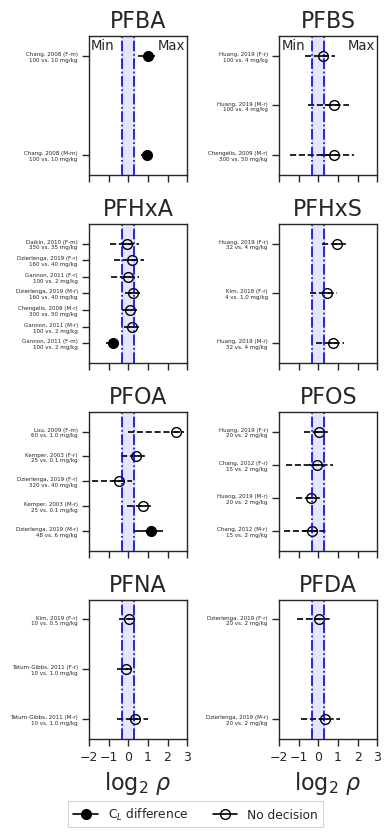

In [37]:
func_dict = {
            "25%": lambda x: np.percentile(x, 25),
            "75%": lambda x: np.percentile(x, 75)
            }
param = 'CLC [indiv]'
rope=[0.8, 1.2]
#fig, axs = plt.subplots(2, 4, figsize=(4*4, 2*4), sharex=True)
#fig, axs = plt.subplots(4, 2, figsize=(2*4, 4*4), sharey=True, sharex=True)

fig, axs = plt.subplots(4, 2, figsize=(4, 8), sharey=False, sharex=True)
#fig, axs = plt.subplots(2, 4, figsize=(8, 4), sharey=False, sharex=True)
markersize=7
ax = axs.flatten()
effect_df_list = []
for i, pfas in enumerate(pfas_order):
    print('CURRENTLY ON %s' % pfas)
    store_effect = []
    for sex in sex_order:
        for species in species_order:
            if species == 'primate':
                continue
            model_row = df.loc[(df.PFAS == pfas) & (df.sex == sex) & (df.species == species)]
            print(model_row)
            if model_row.empty:
                continue
            pfas_data = pfas_tmp.get_processed_data(chemical=pfas, sex=sex, species=species)
            if (pfas == 'PFOA') and (sex=='Female') and (species=='rat'):
                pfas_data = pfas_data[~pfas_data.hero_id.isin([3858670])] # Remove 3858670
            elif (pfas == 'PFHxA') and (sex == 'Male') and (species == 'primate'): # Remove LoD issue data
                pfas_data = pfas_data[pfas_data.time_cor < 2]
            elif (pfas == 'PFHxA') and (sex == 'Female') and (species == 'primate'): # Remove LoD issue data
                pfas_data = pfas_data[pfas_data.time_cor < 1]

            #if ((pfas == 'PFBS') & (species == 'primate')) or ((pfas == 'PFOA') & (species == 'mouse') & (sex == 'Male')) or ((pfas == 'PFNA') & (species == 'mouse')):
            #    hierarchy = 'single'
            if ((cur_PFAS == 'PFBA') & (cur_species == 'rat')):
                hierarchy = 'multi'
            else:
                hierarchy = 'default'
            
            pfas_model = PyPKMC(pfas_data, time_label='time_cor', y_obs_label='conc_mean_cor', sd_obs_label='conc_sd_cor',
                         route_label='route_idx', dose_label='dose_mg', BW_label='BW_cor', 
                         study_label='hero_id', dataset_label='dataset_str', indiv_label='aidx')
            pfas_model.sample(model_type=model_row['model'].values[0], load_trace=True, hierarchy=hierarchy)
            if pfas_model.model_structure == 'single':
                continue
            print(pfas_model.min_max_codes)
            if pfas_model.min_max_codes:
                min_max_pairs = [pfas_model.min_max_codes[i:i + 2] for i in range(0, len(pfas_model.min_max_codes), 2)]
                for j, min_max in enumerate(min_max_pairs):
                    min_dose, max_dose = min_max
                    #effect = (pfas_model._trace.posterior[param].sel(dataset=iv) - pfas_model._trace.posterior[param].sel(dataset=oral))/ pfas_model._trace.posterior[param].sel(dataset=iv)
                    effect = pfas_model._trace.posterior[param].sel(dataset=max_dose) / pfas_model._trace.posterior[param].sel(dataset=min_dose)
                    probability_within_rope = 100*((effect > rope[0]) & (effect <= rope[1])).mean()
                    effect_summary = az.summary(effect, hdi_prob=0.95, kind='stats', stat_funcs=func_dict)
                    effect_summary['ROPE_prob'] = np.round(probability_within_rope.values, 3)
                    
                    if (effect_summary.loc[param, 'hdi_2.5%'] > rope[0]) and (effect_summary.loc[param, 'hdi_97.5%'] < rope[1]):
                        effect_summary['ROPE'] = 'Accept Null'
                    #elif (effect < rope[0]).all() | (effect > rope[1]).all():
                    elif (effect_summary.loc[param, 'hdi_2.5%'] > rope[1]) or (effect_summary.loc[param, 'hdi_97.5%'] < rope[0]):
                        effect_summary['ROPE'] = 'Reject Null'
                    else:
                        effect_summary['ROPE'] = 'No Decision'
                    
                    hero_id, min_dose_str, _ = min_dose.split('-')
                    hero_id, max_dose_str, _ = max_dose.split('-')
                    #study_lbl = '%s\n%s %s: %s' % (study_mapper[hero_id], sex.lower(), species, dose)
                    mgkg_dose = float(min_dose_str.split(' ')[0])
                    if mgkg_dose > 1:
                        study_lbl = '%s (%s-%s)\n%s vs. %s mg/kg' % (study_mapper[hero_id], sex[0], species[0], int(float(max_dose_str.split(' ')[0])), int(float(min_dose_str.split(' ')[0])))
                    else:
                        study_lbl = '%s (%s-%s)\n%s vs. %0.1f mg/kg' % (study_mapper[hero_id], sex[0], species[0], int(float(max_dose_str.split(' ')[0])), float(min_dose_str.split(' ')[0]))
                
                    #if float(min_dose_str) >=1:
                    #    study_lbl = '%s (%s - %s)' % (study_mapper[hero_id], sex.lower(), species, max_dose.split(' ')[0], min_dose.split(' ')[0])
                    #    #study_lbl = '%s (%s,%s)' % (study_mapper[hero_id], int(mgkg_dose), sex.lower()[0])
                    #else:
                    #    study_lbl = '%s (%0.1f - %s)' % (study_mapper[hero_id], mgkg_dose, sex.lower()[0])
                    effect_summary = effect_summary.rename(index={param:study_lbl})
                    effect_summary['sex'] = sex
                    store_effect.append(effect_summary)
    
    effect_df = pd.concat(store_effect)
    effect_df['PFAS'] = pfas
    effect_df_list.append(effect_df)
    display(effect_df)
    ax[i].margins(y=0.2)
    # Reject Null plots
    if 'Reject Null' in effect_df.ROPE.values:
        l1 = ax[i].plot(effect_df.loc[effect_df.ROPE == 'Reject Null', 'mean'], effect_df.loc[effect_df.ROPE == 'Reject Null'].index, 'o', color='black', markersize=markersize, label='C$_L$ difference')
        ax[i].hlines(effect_df.loc[effect_df.ROPE == 'Reject Null'].index, effect_df.loc[effect_df.ROPE == 'Reject Null', '25%'], effect_df.loc[effect_df.ROPE == 'Reject Null', '75%'], color='black')#, linewidth=3)
        ax[i].hlines(effect_df.loc[effect_df.ROPE == 'Reject Null'].index, effect_df.loc[effect_df.ROPE == 'Reject Null', 'hdi_2.5%'], effect_df.loc[effect_df.ROPE == 'Reject Null', 'hdi_97.5%'], color='black')
    
    # Accept Null plots
    if 'Accept Null' in effect_df.ROPE.values:
        ax[i].plot(effect_df.loc[effect_df.ROPE == 'Accept Null', 'mean'], effect_df.loc[effect_df.ROPE == 'Accept Null'].index, 'x', color='black', markersize=markersize)
        ax[i].hlines(effect_df.loc[effect_df.ROPE == 'Accept Null'].index, effect_df.loc[effect_df.ROPE == 'Accept Null', '25%'], effect_df.loc[effect_df.ROPE == 'Accept Null', '75%'], color='black')#, linewidth=3)
        ax[i].hlines(effect_df.loc[effect_df.ROPE == 'Accept Null'].index, effect_df.loc[effect_df.ROPE == 'Accept Null', 'hdi_2.5%'], effect_df.loc[effect_df.ROPE == 'Accept Null', 'hdi_97.5%'], color='black')
   
    # No decicion plots
    if 'No Decision' in effect_df.ROPE.values:
        l2 = ax[i].plot(effect_df.loc[effect_df.ROPE == 'No Decision', 'mean'], effect_df.loc[effect_df.ROPE == 'No Decision'].index, 'o', color='black', fillstyle="none", markersize=markersize, label = 'No difference')
        ax[i].hlines(effect_df.loc[effect_df.ROPE == 'No Decision'].index, effect_df.loc[effect_df.ROPE == 'No Decision', '25%'], effect_df.loc[effect_df.ROPE == 'No Decision', '75%'], color='black', linestyle='-')#, linewidth=3, )
        ax[i].hlines(effect_df.loc[effect_df.ROPE == 'No Decision'].index, effect_df.loc[effect_df.ROPE == 'No Decision', 'hdi_2.5%'], effect_df.loc[effect_df.ROPE == 'No Decision', 'hdi_97.5%'], color='black', linestyle='--')

    ylims = ax[i].get_ylim()

    ax[i].axvspan(*rope, alpha=0.1, color='blue')
    ax[i].vlines(rope[0], *ylims, linestyle = '-.', color='blue')
    ax[i].vlines(rope[1], *ylims, linestyle = '-.', color='blue')
    _ = ax[i].set_ylim(ylims)
    ax[i].set_title(pfas, fontsize=16)
    ax[i].tick_params(axis='y', labelsize=4)
    ax[i].set_xscale('log', base=2)
    ax[i].xaxis.set_major_locator(mticker.LogLocator(numticks=999))
    ax[i].xaxis.set_minor_locator(mticker.NullLocator())
    print('DONE WITH %s' % pfas)
    #if i == 1:
    #break
    

for ax in axs[-1,:]:
    #ax.set_xlabel(r'log_2 $\rho$\nfold change', fontsize=16)
    ax.set_xlim([2**-2, 2**3])
    ax.xaxis.set_major_locator(mticker.LogLocator(numticks=999, base=2))
    ax.xaxis.set_major_formatter(mticker.LogFormatterExponent(base=2, labelOnlyBase=True))
    ax.set_xlabel(r'log$_2$ $\rho$', fontsize=16)
    ax.tick_params(axis='x', labelsize=9)
#fig.supxlabel(r'$log_2 \rho$', x=0.5, fontsize=16, horizontalalignment='center')
#axs[0,0].text(-0.3, 1.3, 'A', transform=axs[0,0].transAxes, fontsize=16, va='top', ha='right')
#axs[0,1].legend(loc='upper right')
#fig.text(0.02, 0.99, 'A', fontsize=16, va='top', ha='left')
#fig.text(0.55, 0.02, r'log$_2$ $\rho$', fontsize=16, va='top', ha='center')

axs[0,0].text(0.02, 0.9, 'Min', transform = axs[0,0].transAxes, ha='left')
axs[0,0].text(0.98, 0.9, 'Max', transform = axs[0,0].transAxes, ha='right')
axs[0,1].text(0.02, 0.9, 'Min', transform = axs[0,1].transAxes, ha='left')
axs[0,1].text(0.98, 0.9, 'Max', transform = axs[0,1].transAxes, ha='right')

fig.tight_layout()

fig.subplots_adjust(bottom=0.07)#, wspace=0.33)
legend_elements = [Line2D([0], [0], marker='o', color='black', markeredgecolor='black', markerfacecolor='black', label='C$_L$ difference', markersize=markersize),
                   Line2D([0], [0], marker='o', color='black', markeredgecolor='black', label='No decision', markersize=markersize, fillstyle="none"),
                  ]
                          
axs[0, 1].legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0), bbox_transform=fig.transFigure, fancybox=False, shadow=False, ncol=2)


summary_df = pd.concat(effect_df_list)
summary_df.to_csv('max_vs_min_dose_ROPE.csv')
fig.savefig('./figures/SUPPL_Min_Max_ROPE.svg', bbox_inches='tight')
fig.savefig('./figures/SUPPL_Min_Max_ROPE.pdf', bbox_inches='tight') 
#fig.savefig('Min_Max_ROPE.png', bbox_inches='tight')

## IV vs. Gavage terminal half-life

CURRENTLY ON PFBA
   PFAS   sex species          model
0  PFBA  Male     rat  2-compartment
Hero ID available:  [2325359]
dropping duplicated column
Hero ID used:  [2325359]
PFBA_Male_rat_2cmpt
single level model, 2-compartment
Checking metrics...
Pass all metrics = True
Assign pareto...
codes:  ['2325359-30.0 mg/kg-iv', '2325359-30.0 mg/kg-gavage']
   PFAS   sex species          model
2  PFBA  Male   mouse  2-compartment
Hero ID available:  [2325359]
dropping duplicated column
Hero ID used:  [2325359]
PFBA_Male_mouse_2cmpt
hierarchical model, 2-compartment
Checking metrics...
Pass all metrics = True
Assign pareto...
codes:  []
   PFAS     sex species          model
1  PFBA  Female     rat  2-compartment
Hero ID available:  [2325359]
dropping duplicated column
Hero ID used:  [2325359]
PFBA_Female_rat_2cmpt
single level model, 2-compartment
Checking metrics...
Pass all metrics = True
Assign pareto...
codes:  ['2325359-30.0 mg/kg-iv', '2325359-30.0 mg/kg-gavage']
   PFAS     sex species 

,mean,sd,hdi_2.5%,hdi_97.5%,25%,75%,ROPE_prob,ROPE,sex,PFAS
"Chang, 2008 (30,m)",1.240,6.319,0.007,3.176,0.524,1.192,19.185,No Decision,Male,PFBA
"Chang, 2008 (30,f)",1.703,1.056,0.082,3.488,0.968,2.230,7.835,No Decision,Female,PFBA


DONE WITH PFBA
CURRENTLY ON PFBS
   PFAS   sex species          model
6  PFBS  Male     rat  2-compartment
Hero ID available:  [1326734 2850396 5387170 6579272]
dropping duplicated column
Hero ID used:  [1326734 2850396 5387170]
PFBS_Male_rat_2cmpt
hierarchical model, 2-compartment
Checking metrics...
Pass all metrics = True
Assign pareto...
codes:  ['1326734-30.0 mg/kg-iv', '1326734-30.0 mg/kg-gavage', '5387170-4.0 mg/kg-iv', '5387170-4.0 mg/kg-gavage']
   PFAS   sex species          model
8  PFBS  Male   mouse  2-compartment
Hero ID available:  [1326734 2850396 5387170 6579272]
dropping duplicated column
Hero ID used:  [6579272]
PFBS_Male_mouse_2cmpt
single level model, 2-compartment
Checking metrics...
Pass all metrics = True
Assign pareto...
   PFAS     sex species          model
7  PFBS  Female     rat  2-compartment
Hero ID available:  [1326734 2850396 5387170 6579272]
dropping duplicated column
Hero ID used:  [1326734 2850396 5387170]
PFBS_Female_rat_2cmpt
hierarchical model, 2-

,mean,sd,hdi_2.5%,hdi_97.5%,25%,75%,ROPE_prob,ROPE,sex,PFAS
"Olsen, 2009 (30,m)",2.011,18.092,0.000,5.440,0.620,2.019,18.830,No Decision,Male,PFBS
"Huang, 2019 (4,m)",1.285,27.261,0.000,3.005,0.039,0.484,4.885,No Decision,Male,PFBS
"Olsen, 2009 (30,f)",0.597,0.198,0.238,0.982,0.459,0.709,13.230,No Decision,Female,PFBS
"Huang, 2019 (4,f)",0.782,1.011,0.051,1.836,0.368,0.958,19.255,No Decision,Female,PFBS


DONE WITH PFBS
CURRENTLY ON PFHxA
     PFAS   sex species          model
12  PFHxA  Male     rat  2-compartment
Hero ID available:  [2850314 2850396 3859701 5916078 6822782]
dropping duplicated column
Hero ID used:  [2850314 2850396 3859701 5916078]
PFHxA_Male_rat_2cmpt
hierarchical model, 2-compartment
Checking metrics...
Pass all metrics = True
Assign pareto...
codes:  ['5916078-40.0 mg/kg-iv', '5916078-40.0 mg/kg-gavage']
     PFAS   sex species          model
14  PFHxA  Male   mouse  2-compartment
Hero ID available:  [2850314 2850396 3859701 5916078 6822782]
dropping duplicated column
Hero ID used:  [2850314]
PFHxA_Male_mouse_2cmpt
single level model, 2-compartment
Checking metrics...
Pass all metrics = True
Assign pareto...
     PFAS     sex species          model
13  PFHxA  Female     rat  2-compartment
Hero ID available:  [2850314 2850396 3859701 5916078 6822782]
dropping duplicated column
Hero ID used:  [2850314 2850396 5916078]
PFHxA_Female_rat_2cmpt
hierarchical model, 2-comp

,mean,sd,hdi_2.5%,hdi_97.5%,25%,75%,ROPE_prob,ROPE,sex,PFAS
"Dzierlenga, 2019 (40,m)",2.685,1.251,0.322,4.997,1.806,3.425,5.955,No Decision,Male,PFHxA
"Dzierlenga, 2019 (40,f)",1.162,2.121,0.000,5.994,0.125,0.563,2.130,No Decision,Female,PFHxA


DONE WITH PFHxA
CURRENTLY ON PFHxS
     PFAS   sex species          model
18  PFHxS  Male     rat  2-compartment
Hero ID available:  [1289834 3749289 4239569 5387170]
dropping duplicated column
Hero ID used:  [1289834 3749289 4239569 5387170]
PFHxS_Male_rat_2cmpt
hierarchical model, 2-compartment
Checking metrics...
Pass all metrics = True
Assign pareto...
codes:  ['3749289-4.0 mg/kg-iv', '3749289-4.0 mg/kg-gavage', '4239569-10.0 mg/kg-iv', '4239569-10.0 mg/kg-gavage', '5387170-4.0 mg/kg-iv', '5387170-4.0 mg/kg-gavage']
     PFAS   sex species          model
20  PFHxS  Male   mouse  1-compartment
Hero ID available:  [1289834 3749289 4239569 5387170]
No BW info for mouse in 1289834, using defaults
No BW info for mouse in 1289834, using defaults
No BW info for mouse in 1289834, using defaults
No BW info for mouse in 1289834, using defaults
No BW info for mouse in 1289834, using defaults
No BW info for mouse in 1289834, using defaults
No BW info for mouse in 1289834, using defaults
No BW 

,mean,sd,hdi_2.5%,hdi_97.5%,25%,75%,ROPE_prob,ROPE,sex,PFAS
"Kim, 2016 (4,m)",1.084,0.212,0.809,1.376,0.981,1.167,79.643,No Decision,Male,PFHxS
"Kim, 2018 (10,m)",2.325,1.106,0.625,4.378,1.588,2.823,8.982,No Decision,Male,PFHxS
"Huang, 2019 (4,m)",1.383,0.433,0.652,2.295,1.115,1.578,30.361,No Decision,Male,PFHxS
"Kim, 2016 (4,f)",0.798,0.055,0.703,0.888,0.767,0.826,46.015,No Decision,Female,PFHxS
"Kim, 2018 (1,f)",1.046,0.048,0.964,1.126,1.019,1.073,99.890,Accept Null,Female,PFHxS
"Kim, 2018 (4,f)",1.071,0.065,0.951,1.202,1.027,1.109,96.700,No Decision,Female,PFHxS
"Huang, 2019 (4,f)",0.663,0.053,0.576,0.751,0.634,0.691,0.755,Reject Null,Female,PFHxS


DONE WITH PFHxS
CURRENTLY ON PFOA
    PFAS   sex species          model
24  PFOA  Male     rat  2-compartment
Hero ID available:  [2919359 2990271 3749227 3749289 3858670 3859701 5916078 6302380]
dropping duplicated column
Hero ID used:  [2990271 3749289 3858670 3859701 5916078 6302380]
PFOA_Male_rat_2cmpt
hierarchical model, 2-compartment
Checking metrics...
Pass all metrics = True
Assign pareto...
codes:  ['3749289-1.0 mg/kg-iv', '3749289-1.0 mg/kg-gavage', '5916078-6.0 mg/kg-iv', '5916078-6.0 mg/kg-gavage', '6302380-1.0 mg/kg-iv', '6302380-1.0 mg/kg-gavage']
    PFAS   sex species          model
26  PFOA  Male   mouse  2-compartment
Hero ID available:  [2919359 2990271 3749227 3749289 3858670 3859701 5916078 6302380]
No BW info for mouse in 2919359, using defaults
No BW info for mouse in 2919359, using defaults
No BW info for mouse in 2919359, using defaults
No BW info for mouse in 2919359, using defaults
No BW info for mouse in 2919359, using defaults
No BW info for mouse in 291935

,mean,sd,hdi_2.5%,hdi_97.5%,25%,75%,ROPE_prob,ROPE,sex,PFAS
"Kim, 2016 (1,m)",0.241,6.143,0.000,0.302,0.018,0.117,0.380,Reject Null,Male,PFOA
"Dzierlenga, 2019 (6,m)",16.826,294.069,0.000,26.672,0.600,3.878,10.590,No Decision,Male,PFOA
"Kemper, 2003 (1,m)",0.303,0.336,0.000,0.788,0.085,0.413,2.735,Reject Null,Male,PFOA
"Kim, 2016 (1,f)",1.415,2.123,0.008,4.243,0.465,1.624,16.810,No Decision,Female,PFOA
"Dzierlenga, 2019 (40,f)",0.800,0.373,0.275,1.444,0.574,0.946,30.900,No Decision,Female,PFOA
"Kemper, 2003 (1,f)",0.629,0.211,0.255,1.033,0.477,0.752,17.510,No Decision,Female,PFOA


DONE WITH PFOA
CURRENTLY ON PFOS
    PFAS   sex species          model
30  PFOS  Male     rat  2-compartment
Hero ID available:  [1289832 3749289 3859701 5387170]
dropping duplicated column
Hero ID used:  [1289832 3749289 3859701 5387170]
PFOS_Male_rat_2cmpt
hierarchical model, 2-compartment
Checking metrics...
Pass all metrics = True
Assign pareto...
codes:  ['3749289-2.0 mg/kg-iv', '3749289-2.0 mg/kg-gavage', '5387170-2.0 mg/kg-iv', '5387170-2.0 mg/kg-gavage']
    PFAS   sex species          model
32  PFOS  Male   mouse  1-compartment
Hero ID available:  [1289832 3749289 3859701 5387170]
No BW info for mouse in 1289832, using defaults
No BW info for mouse in 1289832, using defaults
No BW info for mouse in 1289832, using defaults
No BW info for mouse in 1289832, using defaults
No BW info for mouse in 1289832, using defaults
No BW info for mouse in 1289832, using defaults
No BW info for mouse in 1289832, using defaults
No BW info for mouse in 1289832, using defaults
No BW info for mous

,mean,sd,hdi_2.5%,hdi_97.5%,25%,75%,ROPE_prob,ROPE,sex,PFAS
"Kim, 2016 (2,m)",0.881,0.379,0.337,1.476,0.671,1.006,42.170,No Decision,Male,PFOS
"Huang, 2019 (2,m)",1.062,0.700,0.484,1.639,0.883,1.171,65.015,No Decision,Male,PFOS
"Kim, 2016 (2,f)",1.173,0.456,0.580,1.730,0.985,1.297,53.555,No Decision,Female,PFOS
"Huang, 2019 (2,f)",0.619,0.482,0.288,0.895,0.506,0.659,4.410,No Decision,Female,PFOS


DONE WITH PFOS
CURRENTLY ON PFNA
    PFAS   sex species          model
36  PFNA  Male     rat  2-compartment
Hero ID available:  [2919268 3858670 3859701 5063958]
dropping duplicated column
Hero ID used:  [2919268 3858670 3859701 5063958]
PFNA_Male_rat_2cmpt
hierarchical model, 2-compartment
Checking metrics...
Pass all metrics = True
Assign pareto...
codes:  ['5063958-3.0 mg/kg-iv', '5063958-3.0 mg/kg-gavage']
    PFAS   sex species          model
38  PFNA  Male   mouse  2-compartment
Hero ID available:  [2919268 3858670 3859701 5063958]
dropping duplicated column
Hero ID used:  [2919268]
PFNA_Male_mouse_2cmpt
single level model, 2-compartment
Checking metrics...
Pass all metrics = True
Assign pareto...
    PFAS     sex species          model
37  PFNA  Female     rat  2-compartment
Hero ID available:  [2919268 3858670 3859701 5063958]
dropping duplicated column
Hero ID used:  [2919268 3858670 5063958]
PFNA_Female_rat_2cmpt
hierarchical model, 2-compartment
Checking metrics...
Pass all

,mean,sd,hdi_2.5%,hdi_97.5%,25%,75%,ROPE_prob,ROPE,sex,PFAS
"Kim, 2019 (3,m)",1.366,0.708,0.302,2.655,0.943,1.626,31.870,No Decision,Male,PFNA
"Kim, 2019 (0.5,f)",1.296,0.724,0.072,2.441,0.970,1.532,33.389,No Decision,Female,PFNA
"Kim, 2019 (1,f)",0.981,0.860,0.540,1.259,0.794,0.991,68.582,No Decision,Female,PFNA
"Kim, 2019 (3,f)",0.873,0.129,0.618,1.114,0.804,0.954,75.754,No Decision,Female,PFNA


DONE WITH PFNA
CURRENTLY ON PFDA
    PFAS   sex species          model
42  PFDA  Male     rat  2-compartment
Hero ID available:  [3858670 5063958 5916078]
dropping duplicated column
Hero ID used:  [3858670 5063958 5916078]
PFDA_Male_rat_2cmpt
hierarchical model, 2-compartment
Checking metrics...
Pass all metrics = True
Assign pareto...
codes:  ['5063958-1.0 mg/kg-iv', '5063958-1.0 mg/kg-gavage', '5916078-2.0 mg/kg-iv', '5916078-2.0 mg/kg-gavage']
Empty DataFrame
Columns: [PFAS, sex, species, model]
Index: []
    PFAS     sex species          model
43  PFDA  Female     rat  2-compartment
Hero ID available:  [3858670 5063958 5916078]
dropping duplicated column
Hero ID used:  [3858670 5063958 5916078]
PFDA_Female_rat_2cmpt
hierarchical model, 2-compartment
Checking metrics...
Pass all metrics = True
Assign pareto...
codes:  ['5063958-1.0 mg/kg-iv', '5063958-1.0 mg/kg-gavage', '5916078-2.0 mg/kg-iv', '5916078-2.0 mg/kg-gavage']
Empty DataFrame
Columns: [PFAS, sex, species, model]
Index: []

,mean,sd,hdi_2.5%,hdi_97.5%,25%,75%,ROPE_prob,ROPE,sex,PFAS
"Kim, 2019 (1,m)",4.154,87.075,0.000,6.584,1.402,2.145,5.392,No Decision,Male,PFDA
"Dzierlenga, 2019 (2,m)",1.786,2.493,0.302,4.167,0.979,1.888,30.148,No Decision,Male,PFDA
"Kim, 2019 (1,f)",3.435,78.259,0.000,4.493,0.603,0.836,10.690,No Decision,Female,PFDA
"Dzierlenga, 2019 (2,f)",2.927,48.576,0.000,4.781,0.350,0.772,8.130,No Decision,Female,PFDA


DONE WITH PFDA


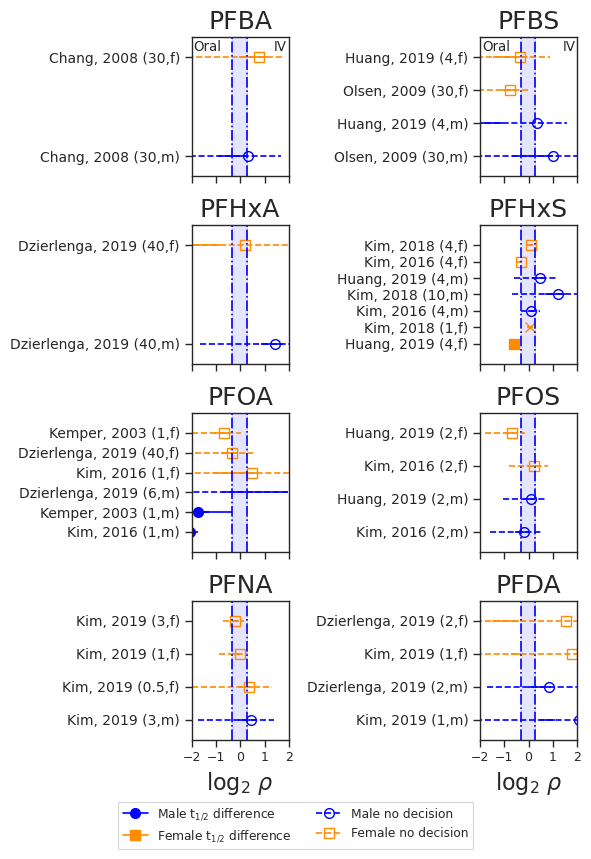

In [40]:
func_dict = {
            "25%": lambda x: np.percentile(x, 25),
            "75%": lambda x: np.percentile(x, 75)
            }
hdi_prob = 0.95
high_result = round(100*(1+hdi_prob)/2, 4)
low_result = round(100*(1-hdi_prob)/2, 4)
low_perc = str(int(low_result)) if low_result.is_integer() else str(low_result)
high_perc = str(int(high_result)) if high_result.is_integer() else str(high_result)

hdi_low = 'hdi_' + low_perc + '%'
hdi_high = 'hdi_' + high_perc + '%'
#param = 'CLC [indiv]'
param = 'halft_beta [indiv]'
#param = 'halft [indiv]'
#rope=[0.9, 1.1]
rope=[0.8, 1.2]
#fig, axs = plt.subplots(2, 4, figsize=(4*4, 2*4), sharex=True)
#fig, axs = plt.subplots(4, 2, figsize=(2*4, 4*4), sharex=True)
fig, axs = plt.subplots(4, 2, figsize=(6, 8), sharex=True)

ax = axs.flatten()
effect_df_list = []
for i, pfas in enumerate(pfas_order):
    print('CURRENTLY ON %s' % pfas)
    store_effect = []
    for sex in sex_order:
        for species in species_order:
            if species == 'primate':
                continue
            model_row = df.loc[(df.PFAS == pfas) & (df.sex == sex) & (df.species == species)]
            print(model_row)
            if model_row.empty:
                continue
            pfas_data = pfas_tmp.get_processed_data(chemical=pfas, sex=sex, species=species)
            if (pfas == 'PFOA') and (sex=='Female') and (species=='rat'):
                pfas_data = pfas_data[~pfas_data.hero_id.isin([3858670])] # Remove 3858670
            
            pfas_model = PyPKMC(pfas_data, time_label='time_cor', y_obs_label='conc_mean_cor', sd_obs_label='conc_sd_cor',
                         route_label='route_idx', dose_label='dose_mg', BW_label='BW_cor', 
                         study_label='hero_id', dataset_label='dataset_str', indiv_label='aidx')
            pfas_model.sample(model_type=model_row['model'].values[0], load_trace=True)
            if param not in pfas_model._trace.posterior:
                continue
            print('codes: ', pfas_model.iv_oral_codes)
            if pfas_model.iv_oral_codes:
                iv_oral_pairs = [pfas_model.iv_oral_codes[i:i + 2] for i in range(0, len(pfas_model.iv_oral_codes), 2)]
                for j, iv_oral in enumerate(iv_oral_pairs):
                    iv, oral = iv_oral
                    #effect = (pfas_model._trace.posterior[param].sel(dataset=iv) - pfas_model._trace.posterior[param].sel(dataset=oral))/ pfas_model._trace.posterior[param].sel(dataset=iv)
                    effect = pfas_model._trace.posterior[param].sel(dataset=iv) / pfas_model._trace.posterior[param].sel(dataset=oral)
                    probability_within_rope = 100*((effect > rope[0]) & (effect <= rope[1])).mean()
                    effect_summary = az.summary(effect, hdi_prob=hdi_prob, kind='stats', stat_funcs=func_dict)
                    effect_summary['ROPE_prob'] = np.round(probability_within_rope.values, 3)
                    
                    if (effect_summary.loc[param, hdi_low] > rope[0]) and (effect_summary.loc[param, hdi_high] < rope[1]):
                        effect_summary['ROPE'] = 'Accept Null'
                    #elif (effect < rope[0]).all() | (effect > rope[1]).all():
                    elif (effect_summary.loc[param, hdi_low] > rope[1]) or (effect_summary.loc[param, hdi_high] < rope[0]):
                        effect_summary['ROPE'] = 'Reject Null'
                    else:
                        effect_summary['ROPE'] = 'No Decision'
                    
                    hero_id, dose, _ = iv.split('-')
                    #study_lbl = '%s\n%s %s: %s' % (study_mapper[hero_id], sex.lower(), species, dose)
                    mgkg_dose = float(dose.split(' ')[0])
                    if mgkg_dose >=1:
                        study_lbl = '%s (%s,%s)' % (study_mapper[hero_id], int(mgkg_dose), sex.lower()[0])
                    else:
                        study_lbl = '%s (%0.1f,%s)' % (study_mapper[hero_id], mgkg_dose, sex.lower()[0])
                    effect_summary = effect_summary.rename(index={param:study_lbl})
                    effect_summary['sex'] = sex
                    store_effect.append(effect_summary)
    effect_df = pd.concat(store_effect)
    effect_df['PFAS'] = pfas
    effect_df_list.append(effect_df)
    display(effect_df)
    #ax[i].plot(effect_df.iloc[:, 0], effect_df.index, 'bo')
    ax[i].margins(y=0.2)
    # Reject Null plots
    if 'Reject Null' in effect_df.ROPE.values:
        #ax[i].plot(effect_df.loc[effect_df.ROPE == 'Reject Null', 'mean'], effect_df.loc[effect_df.ROPE == 'Reject Null'].index, 'o', color='blue', markersize=markersize)
        
        ax[i].plot(effect_df.loc[(effect_df.ROPE == 'Reject Null') & (effect_df.sex == 'Male'), 'mean'], effect_df.loc[(effect_df.ROPE == 'Reject Null') & (effect_df.sex == 'Male')].index, 'o', color='blue', markersize=markersize)
        ax[i].plot(effect_df.loc[(effect_df.ROPE == 'Reject Null') & (effect_df.sex == 'Female'), 'mean'], effect_df.loc[(effect_df.ROPE == 'Reject Null') & (effect_df.sex == 'Female')].index, 's', color='darkorange',  markersize=markersize)
        
        ax[i].hlines(effect_df.loc[(effect_df.ROPE == 'Reject Null') & (effect_df.sex == 'Male')].index, effect_df.loc[(effect_df.ROPE == 'Reject Null') & (effect_df.sex == 'Male'), '25%'], effect_df.loc[(effect_df.ROPE == 'Reject Null') & (effect_df.sex == 'Male'), '75%'], color='blue')#, linewidth=3)
        ax[i].hlines(effect_df.loc[(effect_df.ROPE == 'Reject Null') & (effect_df.sex == 'Female')].index, effect_df.loc[(effect_df.ROPE == 'Reject Null') & (effect_df.sex == 'Female'), '25%'], effect_df.loc[(effect_df.ROPE == 'Reject Null') & (effect_df.sex == 'Female'), '75%'], color='darkorange')#, linewidth=3)
        
        ax[i].hlines(effect_df.loc[(effect_df.ROPE == 'Reject Null') & (effect_df.sex == 'Male')].index, effect_df.loc[(effect_df.ROPE == 'Reject Null') & (effect_df.sex == 'Male'), hdi_low], effect_df.loc[(effect_df.ROPE == 'Reject Null') & (effect_df.sex == 'Male'), hdi_high], color='blue')
        ax[i].hlines(effect_df.loc[(effect_df.ROPE == 'Reject Null') & (effect_df.sex == 'Female')].index, effect_df.loc[(effect_df.ROPE == 'Reject Null') & (effect_df.sex == 'Female'), hdi_low], effect_df.loc[(effect_df.ROPE == 'Reject Null') & (effect_df.sex == 'Female'), hdi_high], color='darkorange')
    
    # Accept Null plots
    if 'Accept Null' in effect_df.ROPE.values:

        ax[i].plot(effect_df.loc[(effect_df.ROPE == 'Accept Null') & (effect_df.sex == 'Male'), 'mean'], 
                   effect_df.loc[(effect_df.ROPE == 'Accept Null') & (effect_df.sex == 'Male')].index, 'x', 
                   color='blue', fillstyle="none", markersize=markersize)
        ax[i].plot(effect_df.loc[(effect_df.ROPE == 'Accept Null') & (effect_df.sex == 'Female'), 'mean'], 
                   effect_df.loc[(effect_df.ROPE == 'Accept Null') & (effect_df.sex == 'Female')].index, 'x', 
                   color='darkorange', markersize=markersize)
        
        ax[i].hlines(effect_df.loc[(effect_df.ROPE == 'Accept Null') & (effect_df.sex == 'Male')].index, effect_df.loc[(effect_df.ROPE == 'Accept Null') & (effect_df.sex == 'Male'), hdi_low], effect_df.loc[(effect_df.ROPE == 'Accept Null') & (effect_df.sex == 'Male'), hdi_high], color='blue')
        ax[i].hlines(effect_df.loc[(effect_df.ROPE == 'Accept Null') & (effect_df.sex == 'Female')].index, effect_df.loc[(effect_df.ROPE == 'Accept Null') & (effect_df.sex == 'Female'), hdi_low], effect_df.loc[(effect_df.ROPE == 'Accept Null') & (effect_df.sex == 'Female'), hdi_high], color='darkorange')

    
    # No decicion plots
    if 'No Decision' in effect_df.ROPE.values:
        #ax[i].plot(effect_df.loc[effect_df.ROPE == 'No Decision', 'mean'], effect_df.loc[effect_df.ROPE == 'No Decision'].index, 's', color='darkorange', markersize=markersize)
        
        
        ax[i].plot(effect_df.loc[(effect_df.ROPE == 'No Decision') & (effect_df.sex == 'Male'), 'mean'], effect_df.loc[(effect_df.ROPE == 'No Decision') & (effect_df.sex == 'Male')].index, 'o', color='blue', fillstyle="none", markersize=markersize)
        ax[i].plot(effect_df.loc[(effect_df.ROPE == 'No Decision') & (effect_df.sex == 'Female'), 'mean'], effect_df.loc[(effect_df.ROPE == 'No Decision') & (effect_df.sex == 'Female')].index, 's', color='darkorange', fillstyle="none", markersize=markersize)
        
        ax[i].hlines(effect_df.loc[(effect_df.ROPE == 'No Decision') & (effect_df.sex == 'Male')].index, effect_df.loc[(effect_df.ROPE == 'No Decision') & (effect_df.sex == 'Male'), '25%'], effect_df.loc[(effect_df.ROPE == 'No Decision') & (effect_df.sex == 'Male'), '75%'], color='blue', linestyle='-')#, linewidth=3)
        ax[i].hlines(effect_df.loc[(effect_df.ROPE == 'No Decision') & (effect_df.sex == 'Female')].index, effect_df.loc[(effect_df.ROPE == 'No Decision') & (effect_df.sex == 'Female'), '25%'], effect_df.loc[(effect_df.ROPE == 'No Decision') & (effect_df.sex == 'Female'), '75%'], color='darkorange', linestyle='-')#, linewidth=3)
        
        ax[i].hlines(effect_df.loc[(effect_df.ROPE == 'No Decision') & (effect_df.sex == 'Male')].index, effect_df.loc[(effect_df.ROPE == 'No Decision') & (effect_df.sex == 'Male'), hdi_low], effect_df.loc[(effect_df.ROPE == 'No Decision') & (effect_df.sex == 'Male'), hdi_high], color='blue', linestyle='--')
        ax[i].hlines(effect_df.loc[(effect_df.ROPE == 'No Decision') & (effect_df.sex == 'Female')].index, effect_df.loc[(effect_df.ROPE == 'No Decision') & (effect_df.sex == 'Female'), hdi_low], effect_df.loc[(effect_df.ROPE == 'No Decision') & (effect_df.sex == 'Female'), hdi_high], color='darkorange', linestyle='--')

    ylims = ax[i].get_ylim()

    ax[i].axvspan(*rope, alpha=0.1, color='blue')
    ax[i].vlines(rope[0], *ylims, linestyle = '-.', color='blue')
    ax[i].vlines(rope[1], *ylims, linestyle = '-.', color='blue')
    _ = ax[i].set_ylim(ylims)
    ax[i].set_title(pfas, fontsize=18)
    ax[i].tick_params(axis='y', labelsize=10)
    
    ax[i].set_xscale('log', base=2)
    ax[i].xaxis.set_major_locator(mticker.LogLocator(numticks=999))
    ax[i].xaxis.set_minor_locator(mticker.NullLocator())
    print('DONE WITH %s' % pfas)
    #break

for ax in axs[-1,:]:
    #ax.set_xlabel(r'log_2 $\rho$\nfold change', fontsize=16)
    ax.set_xlim([2**-2, 2**2])
    ax.xaxis.set_major_locator(mticker.LogLocator(numticks=999, base=2))
    ax.xaxis.set_major_formatter(mticker.LogFormatterExponent(base=2, labelOnlyBase=True))
    ax.set_xlabel(r'log$_2$ $\rho$', fontsize=16)
    ax.tick_params(axis='x', labelsize=9)
#fig.supxlabel(r'$log_2 \rho$', x=0.5, fontsize=16, horizontalalignment='center')
#axs[0,0].text(-0.3, 1.3, 'A', transform=axs[0,0].transAxes, fontsize=16, va='top', ha='right')

axs[0,0].text(0.02, 0.9, 'Oral', transform = axs[0,0].transAxes, ha='left')
axs[0,0].text(0.98, 0.9, 'IV', transform = axs[0,0].transAxes, ha='right')
axs[0,1].text(0.02, 0.9, 'Oral', transform = axs[0,1].transAxes, ha='left')
axs[0,1].text(0.98, 0.9, 'IV', transform = axs[0,1].transAxes, ha='right')

#fig.text(0.02, 0.99, 'B', fontsize=16, va='top', ha='left')
#fig.text(0.55, 0.02, r'log$_2$ $\rho$', fontsize=16, va='top', ha='center')
fig.tight_layout()
fig.subplots_adjust(bottom=0.07)#, wspace=0.33)
legend_elements = [Line2D([0], [0], marker='o', color='blue', markeredgecolor='blue', markerfacecolor='blue', label='Male t$_{1/2}$ difference', markersize=markersize),
                   Line2D([0], [0], marker='s', color='darkorange', markeredgecolor='darkorange', markerfacecolor='darkorange', label='Female t$_{1/2}$ difference', markersize=markersize),
                   
                   Line2D([0], [0], marker='o', color='blue', markeredgecolor='blue', label='Male no decision', markersize=markersize, fillstyle="none", linestyle='--'),
                   Line2D([0], [0], marker='s', color='darkorange', markeredgecolor='darkorange', label='Female no decision', markersize=markersize, fillstyle="none",linestyle='--'),
                  
                   #Line2D([0], [0], marker='x', color='blue', markeredgecolor='blue', label='Male no t$_{1/2}$ difference', markersize=markersize),
                   #Line2D([0], [0], marker='x', color='darkorange', markeredgecolor='darkorange', label='Female no t$_{1/2}$ difference', markersize=markersize)
                  ]
                          
axs[0, 1].legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0), bbox_transform=fig.transFigure, fancybox=False, shadow=False, ncol=2)

summary_df = pd.concat(effect_df_list)

summary_df.to_csv('IV_vs_Gavage_ROPE_halft.csv')
fig.savefig('./figures/SUPPL_IV_Gavage_halft_ROPE.svg', bbox_inches='tight')
fig.savefig('./figures/SUPPL_IV_Gavage_halft_ROPE.pdf', bbox_inches='tight') 

## IV vs Gavage Volume of distribution

Compare the predicted volume of distribution for IV vs. gavage route of exposure in rats

CURRENTLY ON PFBA
   PFAS   sex species          model
0  PFBA  Male     rat  2-compartment
Hero ID available:  [2325359]
dropping duplicated column
Hero ID used:  [2325359]
PFBA_Male_rat_2cmpt
single level model, 2-compartment
Checking metrics...
Pass all metrics = True
Assign pareto...
codes:  ['2325359-30.0 mg/kg-iv', '2325359-30.0 mg/kg-gavage']
   PFAS   sex species          model
2  PFBA  Male   mouse  2-compartment
Hero ID available:  [2325359]
dropping duplicated column
Hero ID used:  [2325359]
PFBA_Male_mouse_2cmpt
hierarchical model, 2-compartment
Checking metrics...
Pass all metrics = True
Assign pareto...
codes:  []
   PFAS     sex species          model
1  PFBA  Female     rat  2-compartment
Hero ID available:  [2325359]
dropping duplicated column
Hero ID used:  [2325359]
PFBA_Female_rat_2cmpt
single level model, 2-compartment
Checking metrics...
Pass all metrics = True
Assign pareto...
codes:  ['2325359-30.0 mg/kg-iv', '2325359-30.0 mg/kg-gavage']
   PFAS     sex species 

,mean,sd,hdi_2.5%,hdi_97.5%,25%,75%,ROPE_prob,ROPE,sex,PFAS
"Chang, 2008 (30,m)",1.313,0.386,0.890,1.962,1.093,1.411,46.20,No Decision,Male,PFBA
"Chang, 2008 (30,f)",1.690,0.709,0.786,2.938,1.241,1.951,21.33,No Decision,Female,PFBA


DONE WITH PFBA
CURRENTLY ON PFBS
   PFAS   sex species          model
6  PFBS  Male     rat  2-compartment
Hero ID available:  [1326734 2850396 5387170 6579272]
dropping duplicated column
Hero ID used:  [1326734 2850396 5387170]
PFBS_Male_rat_2cmpt
hierarchical model, 2-compartment
Checking metrics...
Pass all metrics = True
Assign pareto...
codes:  ['1326734-30.0 mg/kg-iv', '1326734-30.0 mg/kg-gavage', '5387170-4.0 mg/kg-iv', '5387170-4.0 mg/kg-gavage']
   PFAS   sex species          model
8  PFBS  Male   mouse  2-compartment
Hero ID available:  [1326734 2850396 5387170 6579272]
dropping duplicated column
Hero ID used:  [6579272]
PFBS_Male_mouse_2cmpt
single level model, 2-compartment
Checking metrics...
Pass all metrics = True
Assign pareto...
   PFAS     sex species          model
7  PFBS  Female     rat  2-compartment
Hero ID available:  [1326734 2850396 5387170 6579272]
dropping duplicated column
Hero ID used:  [1326734 2850396 5387170]
PFBS_Female_rat_2cmpt
hierarchical model, 2-

,mean,sd,hdi_2.5%,hdi_97.5%,25%,75%,ROPE_prob,ROPE,sex,PFAS
"Olsen, 2009 (30,m)",1.167,0.396,0.557,1.986,0.963,1.277,61.035,No Decision,Male,PFBS
"Huang, 2019 (4,m)",1.134,0.363,0.569,1.870,0.950,1.243,63.000,No Decision,Male,PFBS
"Olsen, 2009 (30,f)",1.494,0.544,0.725,2.591,1.106,1.731,32.750,No Decision,Female,PFBS
"Huang, 2019 (4,f)",0.857,0.246,0.406,1.331,0.687,0.999,50.050,No Decision,Female,PFBS


DONE WITH PFBS
CURRENTLY ON PFHxA
     PFAS   sex species          model
12  PFHxA  Male     rat  2-compartment
Hero ID available:  [2850314 2850396 3859701 5916078 6822782]
dropping duplicated column
Hero ID used:  [2850314 2850396 3859701 5916078]
PFHxA_Male_rat_2cmpt
hierarchical model, 2-compartment
Checking metrics...
Pass all metrics = True
Assign pareto...
codes:  ['5916078-40.0 mg/kg-iv', '5916078-40.0 mg/kg-gavage']
     PFAS   sex species          model
14  PFHxA  Male   mouse  2-compartment
Hero ID available:  [2850314 2850396 3859701 5916078 6822782]
dropping duplicated column
Hero ID used:  [2850314]
PFHxA_Male_mouse_2cmpt
single level model, 2-compartment
Checking metrics...
Pass all metrics = True
Assign pareto...
     PFAS     sex species          model
13  PFHxA  Female     rat  2-compartment
Hero ID available:  [2850314 2850396 3859701 5916078 6822782]
dropping duplicated column
Hero ID used:  [2850314 2850396 5916078]
PFHxA_Female_rat_2cmpt
hierarchical model, 2-comp

,mean,sd,hdi_2.5%,hdi_97.5%,25%,75%,ROPE_prob,ROPE,sex,PFAS
"Dzierlenga, 2019 (40,m)",0.860,0.187,0.484,1.196,0.730,0.986,58.665,No Decision,Male,PFHxA
"Dzierlenga, 2019 (40,f)",0.661,0.246,0.250,1.080,0.471,0.839,27.035,No Decision,Female,PFHxA


DONE WITH PFHxA
CURRENTLY ON PFHxS
     PFAS   sex species          model
18  PFHxS  Male     rat  2-compartment
Hero ID available:  [1289834 3749289 4239569 5387170]
dropping duplicated column
Hero ID used:  [1289834 3749289 4239569 5387170]
PFHxS_Male_rat_2cmpt
hierarchical model, 2-compartment
Checking metrics...
Pass all metrics = True
Assign pareto...
codes:  ['3749289-4.0 mg/kg-iv', '3749289-4.0 mg/kg-gavage', '4239569-10.0 mg/kg-iv', '4239569-10.0 mg/kg-gavage', '5387170-4.0 mg/kg-iv', '5387170-4.0 mg/kg-gavage']
     PFAS   sex species          model
20  PFHxS  Male   mouse  1-compartment
Hero ID available:  [1289834 3749289 4239569 5387170]
No BW info for mouse in 1289834, using defaults
No BW info for mouse in 1289834, using defaults
No BW info for mouse in 1289834, using defaults
No BW info for mouse in 1289834, using defaults
No BW info for mouse in 1289834, using defaults
No BW info for mouse in 1289834, using defaults
No BW info for mouse in 1289834, using defaults
No BW 

,mean,sd,hdi_2.5%,hdi_97.5%,25%,75%,ROPE_prob,ROPE,sex,PFAS
"Kim, 2016 (4,m)",1.630,0.417,0.991,2.461,1.349,1.813,8.786,No Decision,Male,PFHxS
"Kim, 2018 (10,m)",1.667,0.486,0.993,2.638,1.329,1.883,11.036,No Decision,Male,PFHxS
"Huang, 2019 (4,m)",1.305,0.296,0.772,1.895,1.109,1.461,37.018,No Decision,Male,PFHxS
"Kim, 2016 (4,f)",1.745,0.484,1.130,2.619,1.452,1.891,1.490,No Decision,Female,PFHxS
"Kim, 2018 (1,f)",2.092,0.413,1.524,2.885,1.837,2.226,0.000,Reject Null,Female,PFHxS
"Kim, 2018 (4,f)",2.331,0.563,1.622,3.403,1.989,2.498,0.000,Reject Null,Female,PFHxS
"Huang, 2019 (4,f)",0.914,0.162,0.647,1.221,0.806,0.990,71.750,No Decision,Female,PFHxS


DONE WITH PFHxS
CURRENTLY ON PFOA
    PFAS   sex species          model
24  PFOA  Male     rat  2-compartment
Hero ID available:  [2919359 2990271 3749227 3749289 3858670 3859701 5916078 6302380]
dropping duplicated column
Hero ID used:  [2990271 3749289 3858670 3859701 5916078 6302380]
PFOA_Male_rat_2cmpt
hierarchical model, 2-compartment
Checking metrics...
Pass all metrics = True
Assign pareto...
codes:  ['3749289-1.0 mg/kg-iv', '3749289-1.0 mg/kg-gavage', '5916078-6.0 mg/kg-iv', '5916078-6.0 mg/kg-gavage', '6302380-1.0 mg/kg-iv', '6302380-1.0 mg/kg-gavage']
    PFAS   sex species          model
26  PFOA  Male   mouse  2-compartment
Hero ID available:  [2919359 2990271 3749227 3749289 3858670 3859701 5916078 6302380]
No BW info for mouse in 2919359, using defaults
No BW info for mouse in 2919359, using defaults
No BW info for mouse in 2919359, using defaults
No BW info for mouse in 2919359, using defaults
No BW info for mouse in 2919359, using defaults
No BW info for mouse in 291935

,mean,sd,hdi_2.5%,hdi_97.5%,25%,75%,ROPE_prob,ROPE,sex,PFAS
"Kim, 2016 (1,m)",1.403,0.489,0.739,2.386,1.092,1.563,38.165,No Decision,Male,PFOA
"Dzierlenga, 2019 (6,m)",0.963,0.216,0.569,1.404,0.830,1.067,69.600,No Decision,Male,PFOA
"Kemper, 2003 (1,m)",1.218,0.317,0.678,1.855,1.022,1.344,52.165,No Decision,Male,PFOA
"Kim, 2016 (1,f)",1.528,0.530,0.706,2.623,1.135,1.802,27.235,No Decision,Female,PFOA
"Dzierlenga, 2019 (40,f)",1.090,0.367,0.472,1.811,0.860,1.249,52.540,No Decision,Female,PFOA
"Kemper, 2003 (1,f)",1.579,0.543,0.705,2.621,1.167,1.882,25.010,No Decision,Female,PFOA


DONE WITH PFOA
CURRENTLY ON PFOS
    PFAS   sex species          model
30  PFOS  Male     rat  2-compartment
Hero ID available:  [1289832 3749289 3859701 5387170]
dropping duplicated column
Hero ID used:  [1289832 3749289 3859701 5387170]
PFOS_Male_rat_2cmpt
hierarchical model, 2-compartment
Checking metrics...
Pass all metrics = True
Assign pareto...
codes:  ['3749289-2.0 mg/kg-iv', '3749289-2.0 mg/kg-gavage', '5387170-2.0 mg/kg-iv', '5387170-2.0 mg/kg-gavage']
    PFAS   sex species          model
32  PFOS  Male   mouse  1-compartment
Hero ID available:  [1289832 3749289 3859701 5387170]
No BW info for mouse in 1289832, using defaults
No BW info for mouse in 1289832, using defaults
No BW info for mouse in 1289832, using defaults
No BW info for mouse in 1289832, using defaults
No BW info for mouse in 1289832, using defaults
No BW info for mouse in 1289832, using defaults
No BW info for mouse in 1289832, using defaults
No BW info for mouse in 1289832, using defaults
No BW info for mous

,mean,sd,hdi_2.5%,hdi_97.5%,25%,75%,ROPE_prob,ROPE,sex,PFAS
"Kim, 2016 (2,m)",1.350,0.301,0.879,1.950,1.150,1.481,33.635,No Decision,Male,PFOS
"Huang, 2019 (2,m)",1.544,0.419,0.870,2.359,1.268,1.736,17.170,No Decision,Male,PFOS
"Kim, 2016 (2,f)",1.745,0.511,1.040,2.700,1.441,1.901,3.805,No Decision,Female,PFOS
"Huang, 2019 (2,f)",1.640,0.394,1.007,2.396,1.389,1.815,7.485,No Decision,Female,PFOS


DONE WITH PFOS
CURRENTLY ON PFNA
    PFAS   sex species          model
36  PFNA  Male     rat  2-compartment
Hero ID available:  [2919268 3858670 3859701 5063958]
dropping duplicated column
Hero ID used:  [2919268 3858670 3859701 5063958]
PFNA_Male_rat_2cmpt
hierarchical model, 2-compartment
Checking metrics...
Pass all metrics = True
Assign pareto...
codes:  ['5063958-3.0 mg/kg-iv', '5063958-3.0 mg/kg-gavage']
    PFAS   sex species          model
38  PFNA  Male   mouse  2-compartment
Hero ID available:  [2919268 3858670 3859701 5063958]
dropping duplicated column
Hero ID used:  [2919268]
PFNA_Male_mouse_2cmpt
single level model, 2-compartment
Checking metrics...
Pass all metrics = True
Assign pareto...
    PFAS     sex species          model
37  PFNA  Female     rat  2-compartment
Hero ID available:  [2919268 3858670 3859701 5063958]
dropping duplicated column
Hero ID used:  [2919268 3858670 5063958]
PFNA_Female_rat_2cmpt
hierarchical model, 2-compartment
Checking metrics...
Pass all

,mean,sd,hdi_2.5%,hdi_97.5%,25%,75%,ROPE_prob,ROPE,sex,PFAS
"Kim, 2019 (3,m)",1.577,0.689,0.705,2.946,1.118,1.833,31.570,No Decision,Male,PFNA
"Kim, 2019 (0.5,f)",1.230,0.163,0.923,1.545,1.118,1.325,45.807,No Decision,Female,PFNA
"Kim, 2019 (1,f)",1.135,0.143,0.884,1.427,1.035,1.213,72.143,No Decision,Female,PFNA
"Kim, 2019 (3,f)",0.957,0.139,0.703,1.224,0.858,1.038,82.532,No Decision,Female,PFNA


DONE WITH PFNA
CURRENTLY ON PFDA
    PFAS   sex species          model
42  PFDA  Male     rat  2-compartment
Hero ID available:  [3858670 5063958 5916078]
dropping duplicated column
Hero ID used:  [3858670 5063958 5916078]
PFDA_Male_rat_2cmpt
hierarchical model, 2-compartment
Checking metrics...
Pass all metrics = True
Assign pareto...
codes:  ['5063958-1.0 mg/kg-iv', '5063958-1.0 mg/kg-gavage', '5916078-2.0 mg/kg-iv', '5916078-2.0 mg/kg-gavage']
Empty DataFrame
Columns: [PFAS, sex, species, model]
Index: []
    PFAS     sex species          model
43  PFDA  Female     rat  2-compartment
Hero ID available:  [3858670 5063958 5916078]
dropping duplicated column
Hero ID used:  [3858670 5063958 5916078]
PFDA_Female_rat_2cmpt
hierarchical model, 2-compartment
Checking metrics...
Pass all metrics = True
Assign pareto...
codes:  ['5063958-1.0 mg/kg-iv', '5063958-1.0 mg/kg-gavage', '5916078-2.0 mg/kg-iv', '5916078-2.0 mg/kg-gavage']
Empty DataFrame
Columns: [PFAS, sex, species, model]
Index: []

,mean,sd,hdi_2.5%,hdi_97.5%,25%,75%,ROPE_prob,ROPE,sex,PFAS
"Kim, 2019 (1,m)",1.032,0.333,0.556,1.725,0.833,1.136,62.522,No Decision,Male,PFDA
"Dzierlenga, 2019 (2,m)",2.156,1.382,0.866,4.577,1.415,2.381,8.990,No Decision,Male,PFDA
"Kim, 2019 (1,f)",0.770,0.236,0.451,1.235,0.617,0.860,27.900,No Decision,Female,PFDA
"Dzierlenga, 2019 (2,f)",1.505,0.514,0.649,2.415,1.196,1.717,21.860,No Decision,Female,PFDA


DONE WITH PFDA


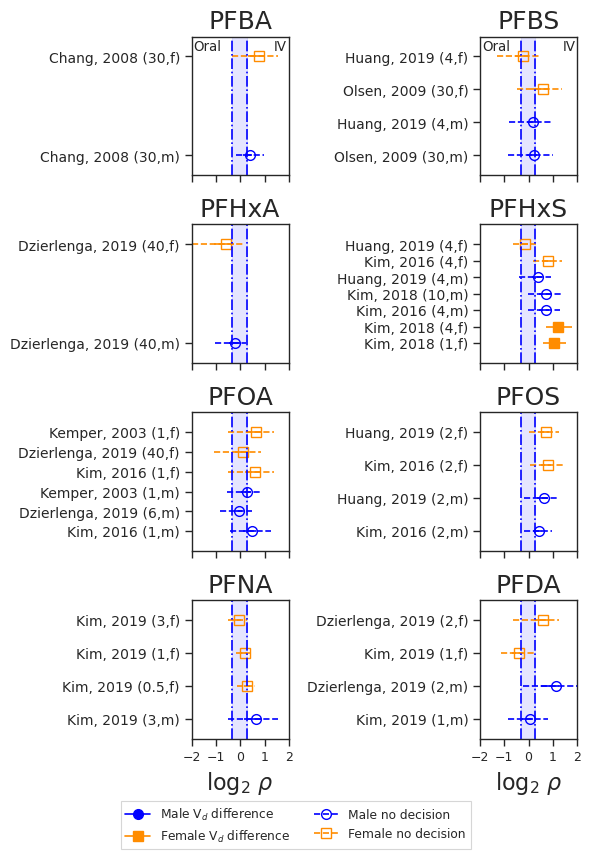

In [44]:
func_dict = {
            "25%": lambda x: np.percentile(x, 25),
            "75%": lambda x: np.percentile(x, 75)
            }
hdi_prob = 0.95
high_result = round(100*(1+hdi_prob)/2, 4)
low_result = round(100*(1-hdi_prob)/2, 4)
low_perc = str(int(low_result)) if low_result.is_integer() else str(low_result)
high_perc = str(int(high_result)) if high_result.is_integer() else str(high_result)

hdi_low = 'hdi_' + low_perc + '%'
hdi_high = 'hdi_' + high_perc + '%'
#param = 'CLC [indiv]'
param = 'Vdss [indiv]'
#param = 'halft_beta [indiv]'
#rope=[0.9, 1.1]
rope=[0.8, 1.2]
#fig, axs = plt.subplots(2, 4, figsize=(4*4, 2*4), sharex=True)
#fig, axs = plt.subplots(4, 2, figsize=(2*4, 4*4), sharex=True)
fig, axs = plt.subplots(4, 2, figsize=(6, 8), sharex=True)

ax = axs.flatten()
effect_df_list = []
for i, pfas in enumerate(pfas_order):
    print('CURRENTLY ON %s' % pfas)
    store_effect = []
    for sex in sex_order:
        for species in species_order:
            if species == 'primate':
                continue
            model_row = df.loc[(df.PFAS == pfas) & (df.sex == sex) & (df.species == species)]
            print(model_row)
            if model_row.empty:
                continue
            pfas_data = pfas_tmp.get_processed_data(chemical=pfas, sex=sex, species=species)
            if (pfas == 'PFOA') and (sex=='Female') and (species=='rat'):
                pfas_data = pfas_data[~pfas_data.hero_id.isin([3858670])] # Remove 3858670
            
            pfas_model = PyPKMC(pfas_data, time_label='time_cor', y_obs_label='conc_mean_cor', sd_obs_label='conc_sd_cor',
                         route_label='route_idx', dose_label='dose_mg', BW_label='BW_cor', 
                         study_label='hero_id', dataset_label='dataset_str', indiv_label='aidx')
            pfas_model.sample(model_type=model_row['model'].values[0], load_trace=True)
            if param not in pfas_model._trace.posterior:
                continue
            print('codes: ', pfas_model.iv_oral_codes)
            if pfas_model.iv_oral_codes:
                iv_oral_pairs = [pfas_model.iv_oral_codes[i:i + 2] for i in range(0, len(pfas_model.iv_oral_codes), 2)]
                for j, iv_oral in enumerate(iv_oral_pairs):
                    iv, oral = iv_oral
                    #effect = (pfas_model._trace.posterior[param].sel(dataset=iv) - pfas_model._trace.posterior[param].sel(dataset=oral))/ pfas_model._trace.posterior[param].sel(dataset=iv)
                    effect = pfas_model._trace.posterior[param].sel(dataset=iv) / pfas_model._trace.posterior[param].sel(dataset=oral)
                    probability_within_rope = 100*((effect > rope[0]) & (effect <= rope[1])).mean()
                    effect_summary = az.summary(effect, hdi_prob=hdi_prob, kind='stats', stat_funcs=func_dict)
                    effect_summary['ROPE_prob'] = np.round(probability_within_rope.values, 3)
                    
                    if (effect_summary.loc[param, hdi_low] > rope[0]) and (effect_summary.loc[param, hdi_high] < rope[1]):
                        effect_summary['ROPE'] = 'Accept Null'
                    #elif (effect < rope[0]).all() | (effect > rope[1]).all():
                    elif (effect_summary.loc[param, hdi_low] > rope[1]) or (effect_summary.loc[param, hdi_high] < rope[0]):
                        effect_summary['ROPE'] = 'Reject Null'
                    else:
                        effect_summary['ROPE'] = 'No Decision'
                    
                    hero_id, dose, _ = iv.split('-')
                    #study_lbl = '%s\n%s %s: %s' % (study_mapper[hero_id], sex.lower(), species, dose)
                    mgkg_dose = float(dose.split(' ')[0])
                    if mgkg_dose >=1:
                        study_lbl = '%s (%s,%s)' % (study_mapper[hero_id], int(mgkg_dose), sex.lower()[0])
                    else:
                        study_lbl = '%s (%0.1f,%s)' % (study_mapper[hero_id], mgkg_dose, sex.lower()[0])
                    effect_summary = effect_summary.rename(index={param:study_lbl})
                    effect_summary['sex'] = sex
                    store_effect.append(effect_summary)
    effect_df = pd.concat(store_effect)
    effect_df['PFAS'] = pfas
    effect_df_list.append(effect_df)
    display(effect_df)
    #ax[i].plot(effect_df.iloc[:, 0], effect_df.index, 'bo')
    ax[i].margins(y=0.2)
    # Reject Null plots
    if 'Reject Null' in effect_df.ROPE.values:
        #ax[i].plot(effect_df.loc[effect_df.ROPE == 'Reject Null', 'mean'], effect_df.loc[effect_df.ROPE == 'Reject Null'].index, 'o', color='blue', markersize=markersize)
        
        ax[i].plot(effect_df.loc[(effect_df.ROPE == 'Reject Null') & (effect_df.sex == 'Male'), 'mean'], effect_df.loc[(effect_df.ROPE == 'Reject Null') & (effect_df.sex == 'Male')].index, 'o', color='blue', markersize=markersize)
        ax[i].plot(effect_df.loc[(effect_df.ROPE == 'Reject Null') & (effect_df.sex == 'Female'), 'mean'], effect_df.loc[(effect_df.ROPE == 'Reject Null') & (effect_df.sex == 'Female')].index, 's', color='darkorange',  markersize=markersize)
        
        ax[i].hlines(effect_df.loc[(effect_df.ROPE == 'Reject Null') & (effect_df.sex == 'Male')].index, effect_df.loc[(effect_df.ROPE == 'Reject Null') & (effect_df.sex == 'Male'), '25%'], effect_df.loc[(effect_df.ROPE == 'Reject Null') & (effect_df.sex == 'Male'), '75%'], color='blue')#, linewidth=3)
        ax[i].hlines(effect_df.loc[(effect_df.ROPE == 'Reject Null') & (effect_df.sex == 'Female')].index, effect_df.loc[(effect_df.ROPE == 'Reject Null') & (effect_df.sex == 'Female'), '25%'], effect_df.loc[(effect_df.ROPE == 'Reject Null') & (effect_df.sex == 'Female'), '75%'], color='darkorange')#, linewidth=3)
        
        ax[i].hlines(effect_df.loc[(effect_df.ROPE == 'Reject Null') & (effect_df.sex == 'Male')].index, effect_df.loc[(effect_df.ROPE == 'Reject Null') & (effect_df.sex == 'Male'), hdi_low], effect_df.loc[(effect_df.ROPE == 'Reject Null') & (effect_df.sex == 'Male'), hdi_high], color='blue')
        ax[i].hlines(effect_df.loc[(effect_df.ROPE == 'Reject Null') & (effect_df.sex == 'Female')].index, effect_df.loc[(effect_df.ROPE == 'Reject Null') & (effect_df.sex == 'Female'), hdi_low], effect_df.loc[(effect_df.ROPE == 'Reject Null') & (effect_df.sex == 'Female'), hdi_high], color='darkorange')
    
    # Accept Null plots
    if 'Accept Null' in effect_df.ROPE.values:

        ax[i].plot(effect_df.loc[(effect_df.ROPE == 'Accept Null') & (effect_df.sex == 'Male'), 'mean'], 
                   effect_df.loc[(effect_df.ROPE == 'Accept Null') & (effect_df.sex == 'Male')].index, 'x', 
                   color='blue', fillstyle="none", markersize=markersize)
        ax[i].plot(effect_df.loc[(effect_df.ROPE == 'Accept Null') & (effect_df.sex == 'Female'), 'mean'], 
                   effect_df.loc[(effect_df.ROPE == 'Accept Null') & (effect_df.sex == 'Female')].index, 'x', 
                   color='darkorange', markersize=markersize)
        
        ax[i].hlines(effect_df.loc[(effect_df.ROPE == 'Accept Null') & (effect_df.sex == 'Male')].index, effect_df.loc[(effect_df.ROPE == 'Accept Null') & (effect_df.sex == 'Male'), hdi_low], effect_df.loc[(effect_df.ROPE == 'Accept Null') & (effect_df.sex == 'Male'), hdi_high], color='blue')
        ax[i].hlines(effect_df.loc[(effect_df.ROPE == 'Accept Null') & (effect_df.sex == 'Female')].index, effect_df.loc[(effect_df.ROPE == 'Accept Null') & (effect_df.sex == 'Female'), hdi_low], effect_df.loc[(effect_df.ROPE == 'Accept Null') & (effect_df.sex == 'Female'), hdi_high], color='darkorange')

    
    # No decicion plots
    if 'No Decision' in effect_df.ROPE.values:
        #ax[i].plot(effect_df.loc[effect_df.ROPE == 'No Decision', 'mean'], effect_df.loc[effect_df.ROPE == 'No Decision'].index, 's', color='darkorange', markersize=markersize)
        
        
        ax[i].plot(effect_df.loc[(effect_df.ROPE == 'No Decision') & (effect_df.sex == 'Male'), 'mean'], effect_df.loc[(effect_df.ROPE == 'No Decision') & (effect_df.sex == 'Male')].index, 'o', color='blue', fillstyle="none", markersize=markersize)
        ax[i].plot(effect_df.loc[(effect_df.ROPE == 'No Decision') & (effect_df.sex == 'Female'), 'mean'], effect_df.loc[(effect_df.ROPE == 'No Decision') & (effect_df.sex == 'Female')].index, 's', color='darkorange', fillstyle="none", markersize=markersize)
        
        ax[i].hlines(effect_df.loc[(effect_df.ROPE == 'No Decision') & (effect_df.sex == 'Male')].index, effect_df.loc[(effect_df.ROPE == 'No Decision') & (effect_df.sex == 'Male'), '25%'], effect_df.loc[(effect_df.ROPE == 'No Decision') & (effect_df.sex == 'Male'), '75%'], color='blue', linestyle='-')#, linewidth=3)
        ax[i].hlines(effect_df.loc[(effect_df.ROPE == 'No Decision') & (effect_df.sex == 'Female')].index, effect_df.loc[(effect_df.ROPE == 'No Decision') & (effect_df.sex == 'Female'), '25%'], effect_df.loc[(effect_df.ROPE == 'No Decision') & (effect_df.sex == 'Female'), '75%'], color='darkorange', linestyle='-')#, linewidth=3)
        
        ax[i].hlines(effect_df.loc[(effect_df.ROPE == 'No Decision') & (effect_df.sex == 'Male')].index, effect_df.loc[(effect_df.ROPE == 'No Decision') & (effect_df.sex == 'Male'), hdi_low], effect_df.loc[(effect_df.ROPE == 'No Decision') & (effect_df.sex == 'Male'), hdi_high], color='blue', linestyle='--')
        ax[i].hlines(effect_df.loc[(effect_df.ROPE == 'No Decision') & (effect_df.sex == 'Female')].index, effect_df.loc[(effect_df.ROPE == 'No Decision') & (effect_df.sex == 'Female'), hdi_low], effect_df.loc[(effect_df.ROPE == 'No Decision') & (effect_df.sex == 'Female'), hdi_high], color='darkorange', linestyle='--')

    ylims = ax[i].get_ylim()

    ax[i].axvspan(*rope, alpha=0.1, color='blue')
    ax[i].vlines(rope[0], *ylims, linestyle = '-.', color='blue')
    ax[i].vlines(rope[1], *ylims, linestyle = '-.', color='blue')
    _ = ax[i].set_ylim(ylims)
    ax[i].set_title(pfas, fontsize=18)
    ax[i].tick_params(axis='y', labelsize=10)
    
    ax[i].set_xscale('log', base=2)
    ax[i].xaxis.set_major_locator(mticker.LogLocator(numticks=999))
    ax[i].xaxis.set_minor_locator(mticker.NullLocator())
    print('DONE WITH %s' % pfas)
    #break

for ax in axs[-1,:]:
    #ax.set_xlabel(r'log_2 $\rho$\nfold change', fontsize=16)
    ax.set_xlim([2**-2, 2**2])
    ax.xaxis.set_major_locator(mticker.LogLocator(numticks=999, base=2))
    ax.xaxis.set_major_formatter(mticker.LogFormatterExponent(base=2, labelOnlyBase=True))
    ax.set_xlabel(r'log$_2$ $\rho$', fontsize=16)
    ax.tick_params(axis='x', labelsize=9)
#fig.supxlabel(r'$log_2 \rho$', x=0.5, fontsize=16, horizontalalignment='center')
#axs[0,0].text(-0.3, 1.3, 'A', transform=axs[0,0].transAxes, fontsize=16, va='top', ha='right')

axs[0,0].text(0.02, 0.9, 'Oral', transform = axs[0,0].transAxes, ha='left')
axs[0,0].text(0.98, 0.9, 'IV', transform = axs[0,0].transAxes, ha='right')
axs[0,1].text(0.02, 0.9, 'Oral', transform = axs[0,1].transAxes, ha='left')
axs[0,1].text(0.98, 0.9, 'IV', transform = axs[0,1].transAxes, ha='right')

#fig.text(0.02, 0.99, 'C', fontsize=16, va='top', ha='left')
#fig.text(0.55, 0.02, r'log$_2$ $\rho$', fontsize=16, va='top', ha='center')
fig.tight_layout()
fig.subplots_adjust(bottom=0.07)#, wspace=0.33)
legend_elements = [Line2D([0], [0], marker='o', color='blue', markeredgecolor='blue', markerfacecolor='blue', label='Male V$_d$ difference', markersize=markersize),
                   Line2D([0], [0], marker='s', color='darkorange', markeredgecolor='darkorange', markerfacecolor='darkorange', label='Female V$_d$ difference', markersize=markersize),
                   
                   Line2D([0], [0], marker='o', color='blue', markeredgecolor='blue', label='Male no decision', markersize=markersize, fillstyle="none", linestyle='--'),
                   Line2D([0], [0], marker='s', color='darkorange', markeredgecolor='darkorange', label='Female no decision', markersize=markersize, fillstyle="none",linestyle='--'),
                  
                   #Line2D([0], [0], marker='x', color='blue', markeredgecolor='blue', label='Male no V$_d$ difference', markersize=markersize),
                   #Line2D([0], [0], marker='x', color='darkorange', markeredgecolor='darkorange', label='Female no V$_d$ difference', markersize=markersize)
                  ]
                          
axs[0, 1].legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0), bbox_transform=fig.transFigure, fancybox=False, shadow=False, ncol=2)

summary_df = pd.concat(effect_df_list)
summary_df.to_csv('IV_vs_Gavage_ROPE_Vd.csv')
fig.savefig('./figures/SUPPL_IV_Gavage_Vd_ROPE.svg', bbox_inches='tight')
fig.savefig('./figures/SUPPL_IV_Gavage_Vd_ROPE.pdf', bbox_inches='tight') 

## Rat growth

Compare rat growth assumptions through interpolation to the values reported in studies where individual animal weights are measured.

In [41]:
def convert_init_age(row):
    init_age = row.initial_age
    age_units = row.initial_age_units
    if age_units in ['months', 'month']:
        init_age = init_age*30 # Convert months-->days
    elif age_units in ['weeks', 'week']:
        init_age = init_age*7 # Convert weeks-->days
    elif age_units in ['hour', 'hours']:
        init_age = init_age/24. # Convert hours-->days
    return init_age
def calc_BW(row):
    print(row)
    return pfas_tmp.calc_rat_BW(row.time_course, row.strain, row.sex)

Hero ID available:  [2325359]
dropping duplicated column
Hero ID used:  [2325359]
Hero ID available:  [1326734 2850396 5387170 6579272]
dropping duplicated column
Hero ID used:  [1326734 2850396 5387170]
Hero ID available:  [2850314 2850396 3859701 5916078 6822782]
dropping duplicated column
Hero ID used:  [2850314 2850396 3859701 5916078]
Hero ID available:  [1289834 3749289 4239569 5387170]
dropping duplicated column
Hero ID used:  [1289834 3749289 4239569 5387170]
Hero ID available:  [2919359 2990271 3749227 3749289 3858670 3859701 5916078 6302380]
dropping duplicated column
Hero ID used:  [2990271 3749289 3858670 3859701 5916078 6302380]
Hero ID available:  [1289832 3749289 3859701 5387170]
dropping duplicated column
Hero ID used:  [1289832 3749289 3859701 5387170]
Hero ID available:  [2919268 3858670 3859701 5063958]
dropping duplicated column
Hero ID used:  [2919268 3858670 3859701 5063958]
hero_id                                                           2919268
study_id        

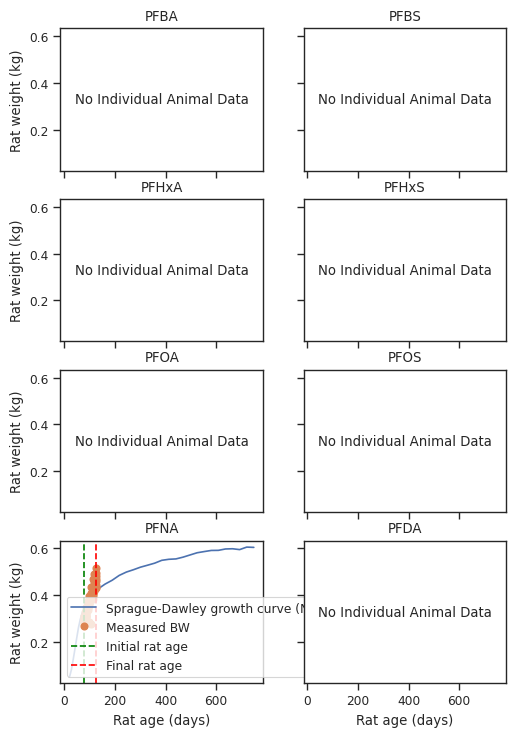

In [42]:
sex = 'Male'
fig, axs = plt.subplots(4,2, figsize=(5.75, 8.5), sharex=True, sharey=True)
ax = axs.flatten()

for i, pfas in enumerate(pfas_order):

    pfas_db = '../PFAS.db'
    pfas_tmp = PFAS_prep(pfas_db, pfas_file = '../auxiliary/pfas_master.csv')#, hero_only=1289834) # 
    pfas_data = pfas_tmp.get_processed_data(chemical=pfas, sex=sex, species='rat')

    indiv_animal = pfas_data[(pfas_data.aidx == True) & (~pfas_data.BW.isna()) & (~pfas_data.BW_units.isna())].copy()
    if indiv_animal.empty:
        ax[i].text(0.5, 0.5, 'No Individual Animal Data', ha='center', va='center', transform = ax[i].transAxes)
    else:
        indiv_animal['init_age_days'] = indiv_animal.apply(convert_init_age, axis=1)
        indiv_animal['time_course'] = indiv_animal['time_cor'] + indiv_animal['init_age_days']
        indiv_animal['BW_interp'] = indiv_animal.apply(calc_BW, axis=1)
        gc = pfas_tmp.rat_growth[(pfas_tmp.rat_growth.strain == 'sprague-dawley') & (pfas_tmp.rat_growth.sex == sex)]
        mean_reported = indiv_animal.groupby('time_course')['BW_cor'].mean()
        ax[i].plot(gc.age.astype(int), gc.BW_mean.astype(float)/1000, label = 'Sprague-Dawley growth curve (NTP 2-year control)')
        ax[i].plot(indiv_animal['time_course'], indiv_animal['BW_cor'], 'o', label='Measured BW')
        ax[i].axvline(min(indiv_animal.init_age_days), linestyle='--', color='green', label='Initial rat age')
        ax[i].axvline(max(indiv_animal.time_course), linestyle='--', color='red', label='Final rat age')
        ax[i].legend(loc='best')
    
    ax[i].set_title(pfas)
for ax_end in [axs[-1,0], axs[-1,1]]:
    ax_end.set_xlabel('Rat age (days)')
for ax_start in axs[:,0]:
    ax_start.set_ylabel('Rat weight (kg)')

Hero ID available:  [2919268 3858670 3859701 5063958]
dropping duplicated column
Hero ID used:  [2919268 3858670 3859701 5063958]
hero_id                                                           2919268
study_id                                                               22
animal_id                                                              B4
N_animals                                                               1
BW                                                                  292.0
BW_units                                                                g
BW_init                                                             0.286
BW_init_units                                                           g
species                                                               rat
strain                                                     sprague-dawley
dose                                                                  1.0
dose_units                                              

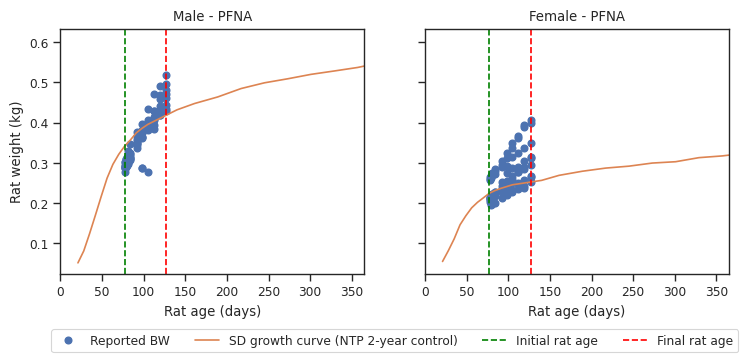

In [43]:
pfas_db = '../PFAS.db'
pfas='PFNA'
fig, ax = plt.subplots(1,2, figsize=(8.625, 3.1875), sharex=True, sharey=True)
for i, sex in enumerate(sex_order):
    pfas_tmp = PFAS_prep(pfas_db, pfas_file = '../auxiliary/pfas_master.csv')#, hero_only=1289834) # 
    pfas_data = pfas_tmp.get_processed_data(chemical=pfas, sex=sex, species='rat')
    
    indiv_animal = pfas_data[(pfas_data.aidx == True) & (~pfas_data.BW.isna()) & (~pfas_data.BW_units.isna())].copy()
    indiv_animal['init_age_days'] = indiv_animal.apply(convert_init_age, axis=1)
    indiv_animal['time_course'] = indiv_animal['time_cor'] + indiv_animal['init_age_days']
    indiv_animal['BW_interp'] = indiv_animal.apply(calc_BW, axis=1)
    
    gc = pfas_tmp.rat_growth[(pfas_tmp.rat_growth.strain == 'sprague-dawley') & (pfas_tmp.rat_growth.sex == sex)]
    mean_reported = indiv_animal.groupby('time_course')['BW_cor'].mean()
    ax[i].plot(indiv_animal['time_course'], indiv_animal['BW_cor'], 'o', label='Reported BW')
    ax[i].plot(gc.age.astype(int), gc.BW_mean.astype(float)/1000, label = 'SD growth curve (NTP 2-year control)')
    ax[i].axvline(min(indiv_animal.init_age_days), linestyle='--', color='green', label='Initial rat age')
    ax[i].axvline(max(indiv_animal.time_course), linestyle='--', color='red', label='Final rat age')
    #ax[i].plot(indiv_animal['BW_cor'], indiv_animal['BW_interp'], 'o')
    #ax[i].axline(tuple([min(indiv_animal['BW_cor'].min(), indiv_animal['BW_interp'].min())]*2), slope=1)
    ax[i].set_xlabel('Rat age (days)')
    ax[i].set_title('%s - %s' % (sex, pfas))
    ax[i].set_xlim([0,365])
ax[0].set_ylabel('Rat weight (kg)')
ax[1].legend(loc='upper center', bbox_to_anchor=(-0.1,-0.2),ncol=4)
fig.savefig('./figures/SUPPL_Rat_Growth.svg', bbox_inches='tight')
fig.savefig('./figures/SUPPL_Rat_Growth.pdf', bbox_inches='tight') 